# Table of Contents
 <p><div class="lev1 toc-item"><a href="#LSTM-Lecture" data-toc-modified-id="LSTM-Lecture-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LSTM Lecture</a></div><div class="lev1 toc-item"><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></div><div class="lev1 toc-item"><a href="#Many-to-One" data-toc-modified-id="Many-to-One-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Many to One</a></div><div class="lev2 toc-item"><a href="#Reshaping-the-Data-1-(X-:-Multiple,-Y-:-1)" data-toc-modified-id="Reshaping-the-Data-1-(X-:-Multiple,-Y-:-1)-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Reshaping the Data 1 (X : Multiple, Y : 1)</a></div><div class="lev3 toc-item"><a href="#Dimension" data-toc-modified-id="Dimension-311"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Dimension</a></div><div class="lev3 toc-item"><a href="#Assignment" data-toc-modified-id="Assignment-312"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Assignment</a></div><div class="lev3 toc-item"><a href="#Reshaping-:-1D-to-2D-(for-MinMaxScaler)" data-toc-modified-id="Reshaping-:-1D-to-2D-(for-MinMaxScaler)-313"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Reshaping : 1D to 2D (for <code>MinMaxScaler</code>)</a></div><div class="lev3 toc-item"><a href="#Scaling-:-MinMax,-0-~-1" data-toc-modified-id="Scaling-:-MinMax,-0-~-1-314"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Scaling : <code>MinMax</code>, 0 ~ 1</a></div><div class="lev3 toc-item"><a href="#Reshaping-X:-2D-to-3D,-(Samples,-Timestep-Sequence,-Features)" data-toc-modified-id="Reshaping-X:-2D-to-3D,-(Samples,-Timestep-Sequence,-Features)-315"><span class="toc-item-num">3.1.5&nbsp;&nbsp;</span>Reshaping <code>X</code>: 2D to 3D, (Samples, Timestep-Sequence, Features)</a></div><div class="lev3 toc-item"><a href="#Splitting-(Train-&amp;-Test)" data-toc-modified-id="Splitting-(Train-&amp;-Test)-316"><span class="toc-item-num">3.1.6&nbsp;&nbsp;</span>Splitting (Train &amp; Test)</a></div><div class="lev3 toc-item"><a href="#Callback-Objects" data-toc-modified-id="Callback-Objects-317"><span class="toc-item-num">3.1.7&nbsp;&nbsp;</span>Callback Objects</a></div><div class="lev2 toc-item"><a href="#LSTM-Model-:-Single-Output" data-toc-modified-id="LSTM-Model-:-Single-Output-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LSTM Model : Single Output</a></div><div class="lev3 toc-item"><a href="#Modeling" data-toc-modified-id="Modeling-321"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Modeling</a></div><div class="lev3 toc-item"><a href="#Training" data-toc-modified-id="Training-322"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Training</a></div><div class="lev3 toc-item"><a href="#Scoring" data-toc-modified-id="Scoring-323"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Scoring</a></div><div class="lev3 toc-item"><a href="#Testing" data-toc-modified-id="Testing-324"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Testing</a></div>

# LSTM Lecture

In Recurrent Neural Networks, we are quickly confronted to the so-called __gradient vanishing problem__:

In machine learning, __the vanishing gradient problem__ is a difficulty found in training artificial neural networks with gradient-based learning methods and backpropagation.  
In such methods, each of the neural network’s weights receives an update proportional to the gradient of the error function with respect to the current weight in each iteration of training.   
_Traditional activation functions such as the hyperbolic tangent function have gradients in the range `(−1,1)` or `(0,1)`_, and backpropagation computes gradients by the chain rule.  
This has the effect of multiplying n of these small numbers to compute gradients of the “front” layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n and the front layers train very slowly.

One solution is __to consider *adding the updates* instead of multiplying them__, and this is exactly what the LSTM does. The state of every cell is updated in an additive way (Equation 9) such that the gradient hardly vanishes.

![lstm](keras_stateful_lstm_2.png)
![lstm](lstm_basic.png)
![lstm](lstm_module.jpg)
![](LSTM.png)

!['lstm'](lstm.jpg)

In [1]:
import os
import math
import datetime as dt
import itertools as it
from glob import glob
from pprint import pprint

import numpy as np
import pandas as pd
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Flatten
from keras.callbacks import Callback, LambdaCallback

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.layers import TimeDistributed, Embedding, RepeatVector, Permute, Lambda
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.layers import Input, Reshape, dot, multiply

# Data

In [3]:
data_len = 100
data = pd.DataFrame({'col1': np.arange(data_len),
                     'col2': np.arange(data_len) * 1.5,
                     'col3': np.round(np.cos(np.arange(data_len)), 2),
                     'col4': np.round(np.cos(np.arange(data_len) * 2), 2),
                     'col5': np.arange(0, data_len*.2, .2)})

data.head(10)

,col1,col2,col3,col4,col5
0,0,0.0,1.00,1.00,0.0
1,1,1.5,0.54,-0.42,0.2
2,2,3.0,-0.42,-0.65,0.4
3,3,4.5,-0.99,0.96,0.6
4,4,6.0,-0.65,-0.15,0.8
5,5,7.5,0.28,-0.84,1.0
6,6,9.0,0.96,0.84,1.2
7,7,10.5,0.75,0.14,1.4
8,8,12.0,-0.15,-0.96,1.6
9,9,13.5,-0.91,0.66,1.8


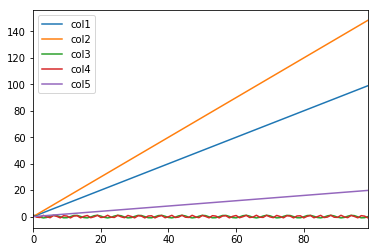

In [4]:
data.plot()

# Many to One

!['lstm_many_to_one'](lstm_many_to_one.jpg)

## Reshaping the Data 1 (X : Multiple, Y : 1)

### Dimension

In [5]:
xfeature = 3
yfeature = 1
look_back = timestep = xlen = 4
foresight = 2
ylen = 1

### Assignment

In [6]:
data_X_1d = data.iloc[:, :xfeature].values.astype('float32')
data_X_1d

array([[  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.50000000e+00,   5.40000021e-01],
       [  2.00000000e+00,   3.00000000e+00,  -4.19999987e-01],
       [  3.00000000e+00,   4.50000000e+00,  -9.90000010e-01],
       [  4.00000000e+00,   6.00000000e+00,  -6.49999976e-01],
       [  5.00000000e+00,   7.50000000e+00,   2.80000001e-01],
       [  6.00000000e+00,   9.00000000e+00,   9.59999979e-01],
       [  7.00000000e+00,   1.05000000e+01,   7.50000000e-01],
       [  8.00000000e+00,   1.20000000e+01,  -1.50000006e-01],
       [  9.00000000e+00,   1.35000000e+01,  -9.10000026e-01],
       [  1.00000000e+01,   1.50000000e+01,  -8.39999974e-01],
       [  1.10000000e+01,   1.65000000e+01,   0.00000000e+00],
       [  1.20000000e+01,   1.80000000e+01,   8.39999974e-01],
       [  1.30000000e+01,   1.95000000e+01,   9.10000026e-01],
       [  1.40000000e+01,   2.10000000e+01,   1.40000001e-01],
       [  1.50000000e+01,   2.25000000e+01,  -7.5999999

In [7]:
data_Y_1d = data.iloc[:, -yfeature:].values.astype('float32')
data_Y_1d

array([[  0.        ],
       [  0.2       ],
       [  0.40000001],
       [  0.60000002],
       [  0.80000001],
       [  1.        ],
       [  1.20000005],
       [  1.39999998],
       [  1.60000002],
       [  1.79999995],
       [  2.        ],
       [  2.20000005],
       [  2.4000001 ],
       [  2.5999999 ],
       [  2.79999995],
       [  3.        ],
       [  3.20000005],
       [  3.4000001 ],
       [  3.5999999 ],
       [  3.79999995],
       [  4.        ],
       [  4.19999981],
       [  4.4000001 ],
       [  4.5999999 ],
       [  4.80000019],
       [  5.        ],
       [  5.19999981],
       [  5.4000001 ],
       [  5.5999999 ],
       [  5.80000019],
       [  6.        ],
       [  6.19999981],
       [  6.4000001 ],
       [  6.5999999 ],
       [  6.80000019],
       [  7.        ],
       [  7.19999981],
       [  7.4000001 ],
       [  7.5999999 ],
       [  7.80000019],
       [  8.        ],
       [  8.19999981],
       [  8.39999962],
       [  8

### Reshaping : 1D to 2D (for `MinMaxScaler`)

In [8]:
data_X_1d.shape

(100, 3)

In [9]:
data_X_2d = data_X_1d.reshape(-1, xfeature)
print(data_X_2d.shape)
data_X_2d

(100, 3)


array([[  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   1.50000000e+00,   5.40000021e-01],
       [  2.00000000e+00,   3.00000000e+00,  -4.19999987e-01],
       [  3.00000000e+00,   4.50000000e+00,  -9.90000010e-01],
       [  4.00000000e+00,   6.00000000e+00,  -6.49999976e-01],
       [  5.00000000e+00,   7.50000000e+00,   2.80000001e-01],
       [  6.00000000e+00,   9.00000000e+00,   9.59999979e-01],
       [  7.00000000e+00,   1.05000000e+01,   7.50000000e-01],
       [  8.00000000e+00,   1.20000000e+01,  -1.50000006e-01],
       [  9.00000000e+00,   1.35000000e+01,  -9.10000026e-01],
       [  1.00000000e+01,   1.50000000e+01,  -8.39999974e-01],
       [  1.10000000e+01,   1.65000000e+01,   0.00000000e+00],
       [  1.20000000e+01,   1.80000000e+01,   8.39999974e-01],
       [  1.30000000e+01,   1.95000000e+01,   9.10000026e-01],
       [  1.40000000e+01,   2.10000000e+01,   1.40000001e-01],
       [  1.50000000e+01,   2.25000000e+01,  -7.5999999

In [10]:
data_Y_2d = data_Y_1d.reshape(-1, yfeature)
print(data_Y_2d.shape)
data_Y_2d

(100, 1)


array([[  0.        ],
       [  0.2       ],
       [  0.40000001],
       [  0.60000002],
       [  0.80000001],
       [  1.        ],
       [  1.20000005],
       [  1.39999998],
       [  1.60000002],
       [  1.79999995],
       [  2.        ],
       [  2.20000005],
       [  2.4000001 ],
       [  2.5999999 ],
       [  2.79999995],
       [  3.        ],
       [  3.20000005],
       [  3.4000001 ],
       [  3.5999999 ],
       [  3.79999995],
       [  4.        ],
       [  4.19999981],
       [  4.4000001 ],
       [  4.5999999 ],
       [  4.80000019],
       [  5.        ],
       [  5.19999981],
       [  5.4000001 ],
       [  5.5999999 ],
       [  5.80000019],
       [  6.        ],
       [  6.19999981],
       [  6.4000001 ],
       [  6.5999999 ],
       [  6.80000019],
       [  7.        ],
       [  7.19999981],
       [  7.4000001 ],
       [  7.5999999 ],
       [  7.80000019],
       [  8.        ],
       [  8.19999981],
       [  8.39999962],
       [  8

### Scaling : `MinMax`, 0 ~ 1

In [11]:
scalerX = MinMaxScaler(feature_range=(0, 1))
scalerY = MinMaxScaler(feature_range=(0, 1))

scaled_X = scalerX.fit_transform(data_X_2d)
scaled_Y = scalerY.fit_transform(data_Y_2d)

print(scaled_X)
print(scaled_Y)

[[ 0.          0.          1.        ]
 [ 0.01010101  0.01010101  0.76999998]
 [ 0.02020202  0.02020202  0.29000002]
 [ 0.03030303  0.03030303  0.005     ]
 [ 0.04040404  0.04040404  0.17500001]
 [ 0.05050505  0.05050505  0.63999999]
 [ 0.06060606  0.06060606  0.98000002]
 [ 0.07070707  0.07070707  0.875     ]
 [ 0.08080808  0.08080808  0.42500001]
 [ 0.09090909  0.09090909  0.04499999]
 [ 0.1010101   0.1010101   0.08000001]
 [ 0.11111111  0.11111111  0.5       ]
 [ 0.12121212  0.12121212  0.91999996]
 [ 0.13131313  0.13131313  0.95500004]
 [ 0.14141414  0.14141414  0.56999999]
 [ 0.15151516  0.15151514  0.12      ]
 [ 0.16161616  0.16161616  0.02000001]
 [ 0.17171717  0.17171717  0.36000001]
 [ 0.18181819  0.18181817  0.83000004]
 [ 0.19191919  0.19191919  0.995     ]
 [ 0.2020202   0.2020202   0.70499998]
 [ 0.21212122  0.2121212   0.22499999]
 [ 0.22222222  0.22222222  0.        ]
 [ 0.23232323  0.23232323  0.23500001]
 [ 0.24242425  0.24242423  0.70999998]
 [ 0.25252524  0.25252524

### Reshaping `X`: 2D to 3D, (Samples, Timestep-Sequence, Features)

In [12]:
len(scaled_X) - xlen - foresight - ylen

93

In [13]:
seq_X = np.array([scaled_X[i:i+xlen] for i in range(0, len(scaled_X) - xlen - (foresight - 1) - (ylen - 1))])
print('X Shape:', seq_X.shape)
seq_X

X Shape: (95, 4, 3)


array([[[ 0.        ,  0.        ,  1.        ],
        [ 0.01010101,  0.01010101,  0.76999998],
        [ 0.02020202,  0.02020202,  0.29000002],
        [ 0.03030303,  0.03030303,  0.005     ]],

       [[ 0.01010101,  0.01010101,  0.76999998],
        [ 0.02020202,  0.02020202,  0.29000002],
        [ 0.03030303,  0.03030303,  0.005     ],
        [ 0.04040404,  0.04040404,  0.17500001]],

       [[ 0.02020202,  0.02020202,  0.29000002],
        [ 0.03030303,  0.03030303,  0.005     ],
        [ 0.04040404,  0.04040404,  0.17500001],
        [ 0.05050505,  0.05050505,  0.63999999]],

       ..., 
       [[ 0.92929292,  0.92929292,  0.185     ],
        [ 0.93939394,  0.93939394,  0.65999997],
        [ 0.94949496,  0.9494949 ,  0.98500001],
        [ 0.95959598,  0.95959592,  0.86500001]],

       [[ 0.93939394,  0.93939394,  0.65999997],
        [ 0.94949496,  0.9494949 ,  0.98500001],
        [ 0.95959598,  0.95959592,  0.86500001],
        [ 0.969697  ,  0.96969694,  0.41      ]]

In [14]:
seq_Y = np.array([scaled_Y[i:i+ylen][0] for i in range(xlen + (foresight - 1), len(scaled_Y))])
print('Y Shape:', seq_Y.shape)
seq_Y

Y Shape: (95, 1)


array([[ 0.05050505],
       [ 0.06060607],
       [ 0.07070708],
       [ 0.08080809],
       [ 0.09090909],
       [ 0.10101011],
       [ 0.11111112],
       [ 0.12121213],
       [ 0.13131313],
       [ 0.14141415],
       [ 0.15151516],
       [ 0.16161618],
       [ 0.17171718],
       [ 0.18181819],
       [ 0.19191919],
       [ 0.20202021],
       [ 0.21212122],
       [ 0.22222224],
       [ 0.23232324],
       [ 0.24242426],
       [ 0.25252527],
       [ 0.26262626],
       [ 0.27272728],
       [ 0.2828283 ],
       [ 0.29292932],
       [ 0.30303031],
       [ 0.31313133],
       [ 0.32323235],
       [ 0.33333334],
       [ 0.34343436],
       [ 0.35353538],
       [ 0.36363637],
       [ 0.37373739],
       [ 0.38383839],
       [ 0.39393944],
       [ 0.40404043],
       [ 0.41414142],
       [ 0.42424244],
       [ 0.43434349],
       [ 0.44444448],
       [ 0.45454547],
       [ 0.46464649],
       [ 0.47474748],
       [ 0.48484853],
       [ 0.49494952],
       [ 0

### Splitting (Train & Test)

In [15]:
test_size = .3

(train_X, test_X,
 train_Y, test_Y)  = train_test_split(seq_X, seq_Y,
                                      test_size=test_size,
                                      shuffle=False,
                                      random_state=99)

print('Train_X\t: %s\nTrain_Y\t: %s\nTest_X\t: %s\nTest_Y\t: %s\n' % 
      (train_X.shape, train_Y.shape, test_X.shape, test_Y.shape))

Train_X	: (66, 4, 3)
Train_Y	: (66, 1)
Test_X	: (29, 4, 3)
Test_Y	: (29, 1)



### Callback Objects

In [16]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.weights = []

#    def on_batch_begin(self, batch, logs={}):
#        self.weights.append([{'begin_' + layer.name: layer.get_weights()} for layer in model.layers])

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.weights.append([{'end_' + layer.name: layer.get_weights()} for layer in model.layers])

history = LossHistory()

print_weights = LambdaCallback(on_epoch_end=lambda batch, logs: pprint(model.layers[0].get_weights()))

## LSTM Model : Single Output

### Modeling

In [17]:
_, timestepX, ndimX = train_X.shape
_, ndimY = train_Y.shape

HIDDEN_SIZE = 16

# simple lstm network learning
model = Sequential()
"""
2D: (batch_size, units)
3D: (batch_size, timesteps, input_dim)
"""
model.add(LSTM(HIDDEN_SIZE,  # Network Node
               input_shape=(timestepX, ndimX),  # Time-step, Feature Number
               #dropout=.3,  # Drop-Out Ratio; Among the Input
               recurrent_dropout=.3,  # Recurrent Drop-out Ratio; Among the Recurrent Network
               return_sequences=False,  # If LSTM Returns the sequence;the same dimension of the input.
               kernel_initializer=keras.initializers.Zeros(),
               recurrent_initializer='zeros',
               bias_initializer=keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None),
               use_bias=True
              ))
model.add(Dense(ndimY,  # Network Node
                #input_shape=(ylen, ndimX),  # Time-step, Feature Number
                activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None),
                bias_initializer=keras.initializers.Constant(value=0),))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

pprint(model.weights)
model.summary()

[<tf.Variable 'lstm_1/kernel:0' shape=(3, 64) dtype=float32_ref>,
 <tf.Variable 'lstm_1/recurrent_kernel:0' shape=(16, 64) dtype=float32_ref>,
 <tf.Variable 'lstm_1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'dense_1/kernel:0' shape=(16, 1) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32_ref>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16)                1280      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


### Training

In [18]:
EPOCH_NUM = 300
BATCH_SIZE = 32

fitted = model.fit(seq_X, seq_Y,
                   epochs=EPOCH_NUM,     # How many times to run back_propagation
                   batch_size=BATCH_SIZE,  # How many data to deal with at one epoch
                   verbose=2,       # 1: progress bar, 2: one line per epoch
                   validation_split=.2,
                   #validation_data=(testX, testY),  # Validation set
                   shuffle=False,
                   callbacks=[history, print_weights])

Train on 76 samples, validate on 19 samples
Epoch 1/300
[array([[ 0.00142218,  0.00221986, -0.00225323,  0.00222593, -0.00226329,
        -0.00061052,  0.00221671, -0.00226585,  0.00216384,  0.00223669,
        -0.00068485,  0.00222426, -0.00223396,  0.00223583,  0.00208681,
         0.00202199,  0.00136367,  0.00221849, -0.00224084,  0.00222573,
        -0.0022611 , -0.00064715,  0.00221487, -0.00226106,  0.00215799,
         0.00223784, -0.00074656,  0.00222396, -0.00221314,  0.00223671,
         0.0020629 ,  0.0019957 , -0.0022139 ,  0.00224617, -0.00226665,
         0.00224921,  0.00226015,  0.00114736, -0.00224428,  0.00226089,
         0.0022489 , -0.0022516 ,  0.00121087,  0.00224988, -0.00228468,
         0.0022508 , -0.00222133,  0.00224947,  0.00143758,  0.00222339,
        -0.00225934,  0.00222941, -0.00226748, -0.00063004,  0.00222074,
        -0.00227042,  0.00216858,  0.00224004, -0.0007159 ,  0.00222786,
        -0.00223955,  0.00223926,  0.00209529,  0.00202693],
      

Epoch 3/300
[array([[ 0.00569759,  0.00695278, -0.00626137,  0.00695706, -0.00680569,
         0.00315485,  0.00695078, -0.00655586,  0.00680345,  0.00697061,
         0.00281495,  0.00695133, -0.00602493,  0.00697143,  0.00672218,
         0.00650826,  0.00563257,  0.00695685, -0.00631025,  0.00696244,
        -0.00682252,  0.00295733,  0.0069544 , -0.00659252,  0.00680594,
         0.00697732,  0.00254146,  0.00695681, -0.00611261,  0.00697766,
         0.00670689,  0.006489  , -0.00695421,  0.00699215, -0.00685656,
         0.00698614,  0.00693072, -0.00286141, -0.00699442,  0.00692497,
         0.00698657, -0.0069791 , -0.00268039,  0.00698433, -0.00626255,
         0.00698176, -0.00697149,  0.00698495,  0.00572302,  0.00696763,
        -0.00628117,  0.00697192, -0.00682218,  0.00313911,  0.00696623,
        -0.00657344,  0.0068187 ,  0.00698553,  0.00279031,  0.00696629,
        -0.00604342,  0.00698644,  0.00674154,  0.00652206],
       [ 0.00569759,  0.00695278, -0.00626137,  0.

Epoch 5/300
[array([[ 0.01047777,  0.01208244, -0.00764644,  0.01207444, -0.01057186,
         0.0078757 ,  0.01208599, -0.00867784,  0.0118621 ,  0.01206257,
         0.00744424,  0.01206627, -0.00776953,  0.01206844,  0.01176474,
         0.01147203,  0.01042513,  0.01208924, -0.00785315,  0.01208249,
        -0.0106907 ,  0.00767335,  0.01209253, -0.00892998,  0.01187357,
         0.01207195,  0.00716561,  0.01207507, -0.00806071,  0.01207667,
         0.01176421,  0.01146161, -0.01213538,  0.0120578 , -0.01108429,
         0.01200101,  0.01154749, -0.00782097, -0.01208396,  0.01153434,
         0.01200711, -0.01194036, -0.00762492,  0.01198555, -0.00638089,
         0.01196269, -0.01215255,  0.01199439,  0.01051169,  0.01210785,
        -0.00767777,  0.01209999, -0.01059994,  0.00786846,  0.01211202,
        -0.00870901,  0.01188704,  0.01208861,  0.00742852,  0.01209185,
        -0.00779593,  0.01209459,  0.01179369,  0.0114947 ],
       [ 0.01047777,  0.01208244, -0.00764644,  0.

Epoch 7/300
[array([[ 0.01576087,  0.01754126, -0.00569245,  0.01750456, -0.01270023,
         0.0131552 ,  0.01755612, -0.00728466,  0.0172946 ,  0.01742469,
         0.0126634 ,  0.01749475, -0.00687698,  0.01744319,  0.01720202,
         0.01686411,  0.01572186,  0.01754469, -0.00601232,  0.0175089 ,
        -0.01304881,  0.01296271,  0.01755979, -0.00783839,  0.01731114,
         0.01743082,  0.01239527,  0.01750096, -0.00748663,  0.01744666,
         0.01721414,  0.01685994, -0.01767292,  0.01733584, -0.01502218,
         0.01717206,  0.01574768, -0.01331964, -0.01740994,  0.01592761,
         0.01719248, -0.01698985, -0.01311956,  0.01712688, -0.00267119,
         0.01705747, -0.01767314,  0.01715794,  0.01580306,  0.01757726,
        -0.00572758,  0.01754098, -0.01274046,  0.01315655,  0.01759266,
        -0.00732493,  0.01732906,  0.01746261,  0.01265639,  0.01753103,
        -0.00690557,  0.01748114,  0.01724001,  0.01689579],
       [ 0.01576087,  0.01754126, -0.00569245,  0.

Epoch 9/300
[array([[ 0.02151754,  0.02332794, -0.00104914,  0.02324221, -0.01296172,
         0.01892964,  0.02336049, -0.00309854,  0.02308659,  0.02304389,
         0.01840208,  0.02322903, -0.00231388,  0.02308741,  0.02303992,
         0.02264473,  0.02148979,  0.02331755, -0.0014652 ,  0.02323162,
        -0.01360944,  0.01874972,  0.02335132, -0.00386633,  0.02309981,
         0.02303595,  0.01814741,  0.02322193, -0.00321495,  0.0230742 ,
         0.02305919,  0.02263974, -0.02353368,  0.02280762, -0.01951825,
         0.02247646,  0.01942251, -0.01922509, -0.02295288,  0.02039615,
         0.0225235 , -0.02208851, -0.01902458,  0.02238316,  0.00266535,
         0.02223411, -0.02349947,  0.02245699,  0.02156768,  0.02337508,
        -0.00108075,  0.0232903 , -0.01301279,  0.01893933,  0.02340794,
        -0.00313866,  0.02313066,  0.02309537,  0.01840342,  0.02327667,
        -0.00233858,  0.02313873,  0.02308657,  0.02268562],
       [ 0.02151754,  0.02332794, -0.00104914,  0.

Epoch 11/300
[array([[ 0.02773415,  0.02946329,  0.00481177,  0.02930686, -0.01129811,
         0.02517506,  0.02951968,  0.00257537,  0.02924324,  0.02893575,
         0.02462876,  0.02928625,  0.00359922,  0.02902108,  0.02928872,
         0.02880414,  0.02771137,  0.02942329,  0.00437282,  0.02926407,
        -0.01229076,  0.02500431,  0.02948263,  0.0017003 ,  0.0292392 ,
         0.02889628,  0.02438467,  0.02924899,  0.00267012,  0.02897249,
         0.02930587,  0.02878555, -0.02970866,  0.02848867, -0.02498239,
         0.02793135,  0.02281327, -0.0254841 , -0.02872531,  0.02530811,
         0.02802014, -0.02724258, -0.02528541,  0.02777089,  0.00882015,
         0.02750426, -0.02962428,  0.02791305,  0.02779188,  0.02952281,
         0.00478638,  0.02936825, -0.01135601,  0.02519268,  0.0295791 ,
         0.00254038,  0.02929752,  0.0290038 ,  0.02463798,  0.0293467 ,
         0.00358274,  0.02908849,  0.02934392,  0.02885474],
       [ 0.02773415,  0.02946329,  0.00481177,  0

Epoch 13/300
[array([[ 0.03435686,  0.03592049,  0.01131497,  0.03567255, -0.00749172,
         0.03183276,  0.03600609,  0.00901744,  0.03572723,  0.03507362,
         0.03127981,  0.03563904,  0.01015645,  0.03522075,  0.03590889,
         0.03529731,  0.0343277 ,  0.03582896,  0.01087946,  0.03557333,
        -0.00893741,  0.03166183,  0.03592018,  0.00809074,  0.03568545,
         0.03497714,  0.03103759,  0.03554766,  0.00924378,  0.03511014,
         0.03590961,  0.03524568, -0.0361456 ,  0.03435354, -0.03123314,
         0.03351746,  0.02639646, -0.03202307, -0.03469756,  0.03080082,
         0.0336645 , -0.03242813, -0.03182818,  0.03327176,  0.01548066,
         0.03284729, -0.03599815,  0.03351034,  0.03442204,  0.03599472,
         0.01129553,  0.03575011, -0.00755122,  0.03185804,  0.03607956,
         0.00898865,  0.03579311,  0.03516303,  0.0312965 ,  0.03571492,
         0.0101479 ,  0.03530861,  0.03597304,  0.0353588 ],
       [ 0.03435686,  0.03592049,  0.01131497,  0

Epoch 15/300
[array([[ 0.04133052,  0.04266318,  0.01829895,  0.04230453, -0.00179266,
         0.03884505,  0.04278253,  0.01596127,  0.04249666,  0.04142309,
         0.03829432,  0.04225216,  0.01720724,  0.04165422,  0.04285409,
         0.04207867,  0.04127729,  0.0424911 ,  0.01786383,  0.04211685,
        -0.00369808,  0.03865786,  0.04261976,  0.01499722,  0.04238922,
         0.04123501,  0.03803856,  0.04207475,  0.01631341,  0.04144608,
         0.04281769,  0.04196712, -0.04278639,  0.04036618, -0.03800241,
         0.03920661,  0.03063368, -0.03877373, -0.04082953,  0.03682758,
         0.03942841, -0.03761701, -0.03858431,  0.03885948,  0.02248453,
         0.03823648, -0.04256566,  0.03922299,  0.04140387,  0.04275635,
         0.01828433,  0.04240326, -0.00184936,  0.03887852,  0.04287399,
         0.01593843,  0.04257721,  0.04154146,  0.03831873,  0.04234808,
         0.01720553,  0.04176947,  0.04292888,  0.04215369],
       [ 0.04133052,  0.04266318,  0.01829895,  0

Epoch 17/300
[array([[ 0.04857225,  0.04961988,  0.02565046,  0.04913305,  0.00505685,
         0.04612787,  0.04977675,  0.02326422,  0.04947802,  0.04791527,
         0.04558621,  0.04905603,  0.02463281,  0.04825384,  0.05004654,
         0.04907344,  0.0484695 ,  0.04932999,  0.0252    ,  0.04881626,
         0.00283173,  0.04590033,  0.04950089,  0.02225426,  0.04926863,
         0.04759132,  0.04529344,  0.04875202,  0.02374732,  0.04790319,
         0.04994437,  0.04886685, -0.0495392 ,  0.04645242, -0.04506826,
         0.0449337 ,  0.03571178, -0.04563972, -0.04704326,  0.04323556,
         0.04524551, -0.0427501 , -0.04545698,  0.04447178,  0.02968985,
         0.04361164, -0.04923719,  0.04498709,  0.04865683,  0.04973964,
         0.02564011,  0.04926149,  0.00500457,  0.04617214,  0.04989352,
         0.02324748,  0.04957942,  0.04807455,  0.04562057,  0.04918004,
         0.0246371 ,  0.04840747,  0.05013638,  0.04916742],
       [ 0.04857225,  0.04961988,  0.02565046,  0

Epoch 19/300
[array([[ 0.05600091,  0.05671271,  0.03327738,  0.05608086,  0.01252743,
         0.0536001 ,  0.05691051,  0.03082986,  0.05659379,  0.05447187,
         0.05307323,  0.05597391,  0.0323359 ,  0.05494233,  0.05740703,
         0.05620442,  0.05581304,  0.05625743,  0.03278556,  0.05558409,
         0.01009861,  0.05329794,  0.05647483,  0.02974996,  0.05623602,
         0.05395741,  0.05270978,  0.0554927 ,  0.03143747,  0.05439381,
         0.05720011,  0.0558579 , -0.05630387,  0.05252264, -0.05226402,
         0.05061738,  0.04152837, -0.0525198 , -0.05324632,  0.04985605,
         0.05103261, -0.04775599, -0.05234448,  0.05003041,  0.03697322,
         0.04889804, -0.05591372,  0.05072181,  0.0561046 ,  0.05687275,
         0.03327335,  0.05625368,  0.01247957,  0.05366223,  0.05706595,
         0.03082198,  0.05672796,  0.05469084,  0.0531242 ,  0.05613996,
         0.03234711,  0.05515188,  0.0575217 ,  0.05632807],
       [ 0.05600091,  0.05671271,  0.03327739,  0

Epoch 21/300
[array([[ 0.06344476,  0.06376996,  0.04100662,  0.06297727,  0.02028734,
         0.06109057,  0.06401164,  0.03848673,  0.06367394,  0.06092373,
         0.06058367,  0.0628362 ,  0.04014093,  0.06154989,  0.06476392,
         0.06330296,  0.06312449,  0.06309137,  0.04043585,  0.06224035,
         0.01770083,  0.06066778,  0.06335859,  0.03729928,  0.06311133,
         0.06015658,  0.06010388,  0.06211827,  0.0391962 ,  0.06073999,
         0.06440155,  0.06276207, -0.06288708,  0.05839742, -0.05936036,
         0.05609046,  0.0477557 , -0.05922015, -0.05925558,  0.05644426,
         0.05661887, -0.05249088, -0.05905244,  0.0553731 ,  0.04412787,
         0.05394218, -0.06240337,  0.05625919,  0.06358447,  0.06399361,
         0.04101727,  0.06321863,  0.02024574,  0.06118604,  0.0642288 ,
         0.03849671,  0.0638622 ,  0.06123064,  0.06066627,  0.06306732,
         0.0401646 ,  0.06184233,  0.06492262,  0.06347571],
       [ 0.06344476,  0.06376996,  0.04100662,  0

Epoch 23/300
[array([[ 0.07063726,  0.07052708,  0.04857373,  0.0695608 ,  0.02803203,
         0.06833334,  0.07081455,  0.04597327,  0.07045636,  0.06701827,
         0.06785099,  0.06938332,  0.04778275,  0.06781977,  0.07185058,
         0.0701089 ,  0.07012748,  0.06956193,  0.04787525,  0.06852045,
         0.02528629,  0.06773381,  0.06988046,  0.0446291 ,  0.06962726,
         0.06593755,  0.06719877,  0.06836665,  0.04674641,  0.066685  ,
         0.07127292,  0.06931441, -0.06901328,  0.06382377, -0.06605309,
         0.06111822,  0.05395912, -0.06546359, -0.06481278,  0.06268504,
         0.06176357, -0.05676122, -0.06530298,  0.06027217,  0.05086282,
         0.0585324 , -0.06843325,  0.06136157,  0.0708437 ,  0.07085039,
         0.0486192 ,  0.06990684,  0.02800541,  0.06849064,  0.0711294 ,
         0.04602154,  0.07073288,  0.06745156,  0.06799354,  0.06971404,
         0.04783347,  0.06823277,  0.07208623,  0.07036233],
       [ 0.07063726,  0.07052708,  0.04857373,  0

Epoch 25/300
[array([[ 0.07715787,  0.07658304,  0.05554491,  0.0754407 ,  0.03531365,
         0.07490627,  0.07691535,  0.05286121,  0.07654216,  0.07239518,
         0.07445159,  0.07522807,  0.05482491,  0.07337889,  0.07825059,
         0.07622452,  0.07640598,  0.07528222,  0.05466879,  0.0740511 ,
         0.03238691,  0.07407735,  0.07564969,  0.05131147,  0.07539854,
         0.07096326,  0.07357362,  0.07386848,  0.05364805,  0.07187792,
         0.07740451,  0.07513031, -0.07430895,  0.0684725 , -0.07192216,
         0.06540105,  0.05960704, -0.07087082, -0.06957996,  0.06816328,
         0.06615719, -0.06033437, -0.07071606,  0.06443843,  0.05676649,
         0.06240638, -0.07363618,  0.06572247,  0.07747468,  0.07705031,
         0.05565989,  0.07593432,  0.03532242,  0.07516637,  0.07737252,
         0.05298213,  0.07695042,  0.07299557,  0.07469532,  0.07569943,
         0.0549289 ,  0.07395376,  0.0786078 ,  0.07659943],
       [ 0.07715787,  0.07658304,  0.05554491,  0

Epoch 27/300
[array([[ 0.08247011,  0.0814549 ,  0.06132511,  0.08015572,  0.04148685,
         0.08026633,  0.08182555,  0.05856669,  0.08144897,  0.07665539,
         0.07983885,  0.07991461,  0.06066324,  0.07780348,  0.08344152,
         0.08116543,  0.08146011,  0.07981896,  0.06024816,  0.07842311,
         0.03837154,  0.07919004,  0.08022677,  0.05679266,  0.07999035,
         0.07488843,  0.07871596,  0.07821933,  0.05931783,  0.07595019,
         0.0823141 ,  0.07977108, -0.07838569,  0.07202114, -0.07650065,
         0.06865484,  0.06412976, -0.07504246, -0.07322304,  0.0724345 ,
         0.06950265, -0.06300917, -0.07489157,  0.06760006,  0.06137777,
         0.06532676, -0.07763438,  0.06904674,  0.08293586,  0.08209787,
         0.06154699,  0.08082578,  0.04155846,  0.08066574,  0.08245752,
         0.05879642,  0.08202186,  0.07744426,  0.08022115,  0.08055421,
         0.06084877,  0.07856387,  0.08395733,  0.08169334],
       [ 0.08247011,  0.0814549 ,  0.06132512,  0

Epoch 29/300
[array([[ 0.08622456,  0.08485855,  0.06547567,  0.0834444 ,  0.04601464,
         0.08405522,  0.08525562,  0.06266359,  0.08489108,  0.07960104,
         0.08365023,  0.08318597,  0.06484689,  0.08087122,  0.08709302,
         0.08464099,  0.08499735,  0.08295207,  0.0642246 ,  0.08143847,
         0.04274532,  0.08276881,  0.08338651,  0.0606995 ,  0.08317869,
         0.07757313,  0.08231848,  0.08122414,  0.0633481 ,  0.07874143,
         0.08573091,  0.08300544, -0.08107851,  0.0743541 , -0.07954995,
         0.07078934,  0.06719178, -0.07780413, -0.07561875,  0.07527912,
         0.07170063, -0.06474926, -0.07765485,  0.06967415,  0.06446233,
         0.06723398, -0.08027208,  0.07123462,  0.08684808,  0.0856747 ,
         0.06582075,  0.08428559,  0.04616574,  0.08460215,  0.08606059,
         0.06301689,  0.08562901,  0.08056431,  0.08418034,  0.0839887 ,
         0.06512454,  0.08180562,  0.08777287,  0.08532309],
       [ 0.08622456,  0.08485855,  0.06547567,  0

Epoch 31/300
[array([[ 0.08857593,  0.08696519,  0.06811527,  0.08548083,  0.04895847,
         0.08642549,  0.08737643,  0.06527269,  0.08703765,  0.08141533,
         0.08603708,  0.08521596,  0.06749327,  0.08276186,  0.08936652,
         0.0868173 ,  0.08719659,  0.084874  ,  0.06674177,  0.08329049,
         0.04559122,  0.08499037,  0.08532176,  0.06317765,  0.0851535 ,
         0.07921439,  0.08455708,  0.0830751 ,  0.06588   ,  0.08044747,
         0.08784027,  0.08501961, -0.08260193,  0.07567434, -0.08127888,
         0.07199894,  0.06894517, -0.07937131, -0.07697314,  0.07689489,
         0.07294723, -0.06573421, -0.07922179,  0.07085169,  0.06623073,
         0.06831393, -0.08176346,  0.07247952,  0.08934282,  0.08793017,
         0.06857875,  0.08646713,  0.04919037,  0.08710598,  0.0883307 ,
         0.06574354,  0.08791927,  0.0825206 ,  0.08670172,  0.08615687,
         0.06785649,  0.08383966,  0.09019282,  0.08763409],
       [ 0.08857593,  0.08696519,  0.06811528,  0

Epoch 33/300
[array([[ 0.09015525,  0.08835468,  0.06992906,  0.08682412,  0.05104461,
         0.08801538,  0.08877355,  0.06706793,  0.0884685 ,  0.08260144,
         0.08764059,  0.08655881,  0.06929957,  0.08399954,  0.09088051,
         0.08827623,  0.08865842,  0.08612508,  0.06846064,  0.08449756,
         0.04761   ,  0.08646419,  0.08657891,  0.06487352,  0.08645687,
         0.08027565,  0.08604456,  0.08428643,  0.06759258,  0.08155071,
         0.08922775,  0.08635911, -0.0834733 ,  0.07642834, -0.08227453,
         0.07269093,  0.06997357, -0.08027272, -0.07774548,  0.07782692,
         0.07366166, -0.06629594, -0.08012193,  0.07152742,  0.06726777,
         0.06893044, -0.08261526,  0.07319703,  0.09105926,  0.08945674,
         0.07050993,  0.08794275,  0.05135944,  0.08882347,  0.08986565,
         0.0676547 ,  0.0894837 ,  0.0838322 ,  0.0884342 ,  0.08762565,
         0.06974666,  0.08520529,  0.09184527,  0.08921861],
       [ 0.09015525,  0.08835468,  0.06992906,  0

Epoch 35/300
[array([[ 0.09163579,  0.08963656,  0.07166164,  0.08805942,  0.05307985,
         0.08950639,  0.09006282,  0.06878132,  0.08979452,  0.08367742,
         0.08914611,  0.08779442,  0.07102218,  0.08512744,  0.09229154,
         0.08963231,  0.09001412,  0.08726269,  0.07009201,  0.08559183,
         0.04957548,  0.08783182,  0.08772199,  0.06648137,  0.08764976,
         0.08122446,  0.08742655,  0.08538608,  0.06921554,  0.08254092,
         0.09050498,  0.08759051, -0.08421772,  0.07706277, -0.08314431,
         0.07326968,  0.07090139, -0.08104569, -0.0783961 ,  0.07863881,
         0.07426194, -0.06675637, -0.0808936 ,  0.07209243,  0.0681755 ,
         0.06944031, -0.08334007,  0.07380206,  0.09268714,  0.09088545,
         0.07236911,  0.08931977,  0.05348397,  0.0904521 ,  0.09130246,
         0.06949325,  0.09095323,  0.08504196,  0.09007871,  0.08899631,
         0.07156152,  0.08646971,  0.0934049 ,  0.09071001],
       [ 0.09163579,  0.08963656,  0.07166165,  0

Epoch 37/300
[array([[ 0.09341496,  0.09117587,  0.07374115,  0.08953901,  0.05551208,
         0.09129952,  0.09161262,  0.07083514,  0.09138177,  0.08495908,
         0.09095655,  0.0892723 ,  0.07309318,  0.08647516,  0.09398878,
         0.09125343,  0.09164223,  0.08862571,  0.07205141,  0.0868982 ,
         0.0519249 ,  0.08947665,  0.08909356,  0.0684086 ,  0.08907326,
         0.08234904,  0.08908867,  0.08669665,  0.07117196,  0.083719  ,
         0.0920402 ,  0.08905783, -0.0851607 ,  0.0778559 , -0.0842606 ,
         0.07398797,  0.07210986, -0.08202226, -0.07921141,  0.079678  ,
         0.07500955, -0.06731763, -0.08186959,  0.07279149,  0.06932118,
         0.07006711, -0.08425567,  0.07455426,  0.09462725,  0.09258887,
         0.07458356,  0.09095895,  0.05600806,  0.09239611,  0.0930167 ,
         0.07168117,  0.09270065,  0.086477  ,  0.09204105,  0.09062663,
         0.07373314,  0.08797292,  0.09526554,  0.0924824 ],
       [ 0.09341496,  0.09117587,  0.07374115,  0

Epoch 39/300
[array([[ 0.09558287,  0.09306285,  0.0762512 ,  0.09135234,  0.05841217,
         0.09348437,  0.09351346,  0.07331335,  0.09332044,  0.08653256,
         0.0931614 ,  0.09108164,  0.07559497,  0.08813026,  0.09606287,
         0.09322948,  0.09363593,  0.09030487,  0.07442757,  0.08850571,
         0.05473471,  0.09149166,  0.09078489,  0.07074398,  0.09081821,
         0.08373311,  0.09112395,  0.08830673,  0.07354933,  0.08517063,
         0.09392653,  0.09085169, -0.08639881,  0.07889351, -0.08572697,
         0.07492544,  0.07369996, -0.08329973, -0.08027911,  0.08104369,
         0.07598661, -0.06804621, -0.08314754,  0.07370223,  0.07080603,
         0.07088298, -0.0854568 ,  0.07553516,  0.09696309,  0.09465227,
         0.07722973,  0.09294543,  0.05899653,  0.09473872,  0.09509369,
         0.07429551,  0.09481096,  0.088221  ,  0.09440417,  0.09260171,
         0.07633816,  0.08979935,  0.09751163,  0.09462067],
       [ 0.09558287,  0.09306285,  0.0762512 ,  0

Epoch 41/300
[array([[ 0.09803934,  0.09521288,  0.07907204,  0.09342003,  0.06164171,
         0.09595884,  0.09567945,  0.07609911,  0.09552506,  0.08833273,
         0.09565758,  0.09314398,  0.07840552,  0.09002239,  0.09841818,
         0.09547371,  0.09590639,  0.09222829,  0.07711034,  0.09034746,
         0.05787496,  0.09378564,  0.09272292,  0.07338107,  0.09281139,
         0.08532245,  0.09344021,  0.09015002,  0.0762335 ,  0.08683743,
         0.0960802 ,  0.09289719, -0.0878734 ,  0.08012935, -0.08746891,
         0.07604206,  0.07558939, -0.0848171 , -0.08155093,  0.08266883,
         0.07715117, -0.06891366, -0.08466636,  0.07478646,  0.07255629,
         0.07185464, -0.08688691,  0.07670306,  0.099587  ,  0.09698276,
         0.08018247,  0.09519163,  0.06230829,  0.09737073,  0.0974393 ,
         0.07721382,  0.09719073,  0.09020069,  0.09705788,  0.09483521,
         0.07924989,  0.09187049,  0.10003974,  0.09703052],
       [ 0.09803934,  0.09521288,  0.07907204,  0

Epoch 43/300
[array([[ 0.10062499,  0.09748326,  0.08202713,  0.09560535,  0.06501181,
         0.0985618 ,  0.09796638,  0.07901879,  0.09785194,  0.09024021,
         0.09828296,  0.09532373,  0.08134674,  0.09202574,  0.10089988,
         0.09784119,  0.09830454,  0.09426676,  0.07993028,  0.09230058,
         0.06116235,  0.09620716,  0.09477679,  0.07615449,  0.09492201,
         0.08701108,  0.09588493,  0.09210453,  0.07905171,  0.08860764,
         0.09835768,  0.09506169, -0.08946571,  0.08146462, -0.08934613,
         0.07724939,  0.07762963, -0.08645275, -0.08292476,  0.08442352,
         0.07841119, -0.06985195, -0.08630417,  0.07595888,  0.07443427,
         0.07290547, -0.08843066,  0.07796643,  0.10233553,  0.09943163,
         0.08326375,  0.09755449,  0.06575543,  0.10012715,  0.09990348,
         0.08026069,  0.09969062,  0.0922893 ,  0.09983633,  0.09718543,
         0.08228878,  0.09405342,  0.10269033,  0.09956175],
       [ 0.10062499,  0.09748326,  0.08202713,  0

Epoch 45/300
[array([[ 0.10319326,  0.09974044,  0.08495796,  0.09777953,  0.06835651,
         0.1011456 ,  0.10023951,  0.08191593,  0.10016661,  0.09214053,
         0.10088909,  0.097493  ,  0.08425953,  0.09402049,  0.10336497,
         0.10019643,  0.10069113,  0.09629716,  0.08273318,  0.09424726,
         0.06443377,  0.09861529,  0.0968221 ,  0.07891298,  0.09702551,
         0.08869566,  0.09831627,  0.0940531 ,  0.08184782,  0.09037301,
         0.10062414,  0.09721909, -0.09105933,  0.08280124, -0.09122353,
         0.07845889,  0.07967828, -0.08808802, -0.0842995 ,  0.08618156,
         0.07967454, -0.07079197, -0.08794197,  0.07713386,  0.07630801,
         0.07395817, -0.08997491,  0.07923361,  0.10506034,  0.10186157,
         0.08631539,  0.09990104,  0.06917388,  0.10285863,  0.10234792,
         0.08327977,  0.10217274,  0.09436683,  0.10258956,  0.09952033,
         0.08529573,  0.09622328,  0.105318  ,  0.10207571],
       [ 0.10319326,  0.09974044,  0.08495796,  0

Epoch 47/300
[array([[ 0.10565501,  0.10190217,  0.08776961,  0.09986291,  0.07157763,
         0.10362057,  0.102416  ,  0.0846966 ,  0.10238626,  0.09396207,
         0.10338593,  0.09957256,  0.087049  ,  0.09593193,  0.10572615,
         0.10245604,  0.10298063,  0.09824289,  0.08542582,  0.09611385,
         0.06759191,  0.10092369,  0.09878152,  0.08156483,  0.09904443,
         0.09031101,  0.10064738,  0.09592245,  0.08452794,  0.09206542,
         0.10279649,  0.09929103, -0.09258009,  0.08407626, -0.0930159 ,
         0.07961349,  0.08164506, -0.08964756, -0.08561042,  0.08786267,
         0.08088176, -0.0716889 , -0.08950417,  0.07825612,  0.07809463,
         0.07496271, -0.09144755,  0.0804454 ,  0.10767192,  0.10418882,
         0.08924329,  0.10214972,  0.07246705,  0.1054752 ,  0.10468835,
         0.08617776,  0.10455288,  0.09635872,  0.10522729,  0.10175885,
         0.08817634,  0.09830283,  0.10783476,  0.10448771],
       [ 0.10565501,  0.10190217,  0.08776961,  0

Epoch 49/300
[array([[ 0.1079828 ,  0.1039425 ,  0.09043388,  0.10183007,  0.07464693,
         0.10595927,  0.10446977,  0.08733273,  0.10448468,  0.09568146,
         0.1057459 ,  0.10153705,  0.08968726,  0.09773593,  0.10795636,
         0.10459363,  0.10514612,  0.10007928,  0.08797988,  0.09787641,
         0.070608  ,  0.10310534,  0.10063022,  0.0840819 ,  0.10095374,
         0.09183555,  0.10285115,  0.09768868,  0.08706394,  0.09366247,
         0.10484844,  0.10125215, -0.09400343,  0.08526861, -0.09469546,
         0.08069389,  0.08350005, -0.09110656, -0.08683588,  0.08944026,
         0.08201272, -0.07252746, -0.09096584,  0.07930687,  0.07976738,
         0.07590212, -0.09282469,  0.0815817 ,  0.1101431 ,  0.1063872 ,
         0.09201986,  0.10427477,  0.07560742,  0.10794965,  0.10689855,
         0.08892713,  0.10680469,  0.09824088,  0.10772228,  0.10387525,
         0.09090313,  0.10026731,  0.1102137 ,  0.10677122],
       [ 0.1079828 ,  0.1039425 ,  0.09043388,  0

Epoch 51/300
[array([[ 0.11019458,  0.10587712,  0.09297148,  0.10369587,  0.07758758,
         0.10817993,  0.10641672,  0.0898445 ,  0.10647762,  0.09731142,
         0.10798743,  0.10340117,  0.0921953 ,  0.09944597,  0.11007299,
         0.10662504,  0.1072041 ,  0.10182029,  0.09041463,  0.09954812,
         0.07350372,  0.10517704,  0.10238239,  0.0864829 ,  0.10276752,
         0.0932805 ,  0.10494455,  0.09936483,  0.08947571,  0.09517605,
         0.10679577,  0.10311671, -0.09534263,  0.08638926, -0.09627809,
         0.08170984,  0.0852598 , -0.09247865, -0.08798725,  0.09092881,
         0.08307756, -0.07331522, -0.0923407 ,  0.08029553,  0.08134192,
         0.07678488, -0.09411925,  0.08265252,  0.11249234,  0.10847302,
         0.09466608,  0.10629166,  0.07861811,  0.1103007 ,  0.10899503,
         0.09154838,  0.10894448,  0.10002661,  0.11009341,  0.1058848 ,
         0.0934973 ,  0.10213085,  0.11247274,  0.10894264],
       [ 0.11019458,  0.10587712,  0.09297148,  0

Epoch 53/300
[array([[ 0.11232798,  0.10773986,  0.09542402,  0.10549281,  0.08044478,
         0.11032057,  0.10829102,  0.09227287,  0.10839912,  0.09888054,
         0.11014876,  0.10519711,  0.09461498,  0.10109209,  0.11211257,
         0.1085846 ,  0.10918987,  0.10349684,  0.09276995,  0.10115843,
         0.07632248,  0.10717461,  0.10406931,  0.08880667,  0.10451697,
         0.09467157,  0.10696363,  0.10098012,  0.09180371,  0.09663314,
         0.10867257,  0.10491626, -0.09662815,  0.08746373, -0.0977994 ,
         0.08268438,  0.08696219, -0.09379487, -0.08909087,  0.09236147,
         0.08410031, -0.07407019, -0.09365987,  0.08124433,  0.0828529 ,
         0.0776311 , -0.09536079,  0.08368176,  0.11475775,  0.11048095,
         0.09722362,  0.10823376,  0.08154398,  0.11256679,  0.11101278,
         0.09408253,  0.11100706,  0.10174568,  0.11237931,  0.10782056,
         0.09600081,  0.10392453,  0.11464901,  0.11103693],
       [ 0.11232798,  0.10773986,  0.09542402,  0

Epoch 55/300
[array([[ 0.11441757,  0.10956193,  0.09782951,  0.10725087,  0.08325972,
         0.11241601,  0.11012419,  0.09465527,  0.11028061,  0.10041539,
         0.11226495,  0.10695466,  0.09698444,  0.10270216,  0.11410876,
         0.11050393,  0.11113597,  0.10513753,  0.09508232,  0.10273464,
         0.07910392,  0.10913097,  0.10571991,  0.09108891,  0.10623097,
         0.09603266,  0.10894156,  0.10256167,  0.09408492,  0.09805883,
         0.1105103 ,  0.10668001, -0.09788869,  0.08851612, -0.09929278,
         0.0836393 ,  0.08864303, -0.09508439, -0.09017156,  0.09376955,
         0.0851037 , -0.07480939, -0.09495264,  0.08217438,  0.08433273,
         0.07845981, -0.09657714,  0.08469199,  0.11697421,  0.11244285,
         0.09973044,  0.11013183,  0.08442586,  0.11478308,  0.11298394,
         0.096567  ,  0.11302442,  0.10342561,  0.11461534,  0.10971306,
         0.0984518 ,  0.10567711,  0.1167766 ,  0.11308633],
       [ 0.11441757,  0.10956193,  0.09782951,  0

Epoch 57/300
[array([[ 0.11648267,  0.11136079,  0.10020933,  0.10898683,  0.08605561,
         0.11448579,  0.11193389,  0.0970127 ,  0.1121396 ,  0.10193077,
         0.11435561,  0.10869046,  0.09932511,  0.10429169,  0.11608037,
         0.11240068,  0.11306051,  0.10675826,  0.09737206,  0.10429196,
         0.08187014,  0.11106451,  0.1073503 ,  0.09334946,  0.10792556,
         0.09737705,  0.11089686,  0.10412456,  0.09633996,  0.09946704,
         0.11232647,  0.10842416, -0.09914058,  0.08956011, -0.10077729,
         0.08458696,  0.09032276, -0.09636377, -0.09124342,  0.09517084,
         0.08610063, -0.07554254, -0.09623563,  0.08309761,  0.08579984,
         0.07928181, -0.09778411,  0.08569604,  0.11916122,  0.11437654,
         0.10220786,  0.11200301,  0.0872867 ,  0.11696925,  0.11492649,
         0.09902279,  0.1150144 ,  0.10508171,  0.11682126,  0.11157928,
         0.10087169,  0.10740458,  0.11887453,  0.11510875],
       [ 0.11648267,  0.11136079,  0.10020933,  0

Epoch 59/300
[array([[ 0.11852624,  0.11313901,  0.10256691,  0.11070309,  0.08883631,
         0.11653292,  0.11372272,  0.09934848,  0.11397858,  0.10342866,
         0.11642382,  0.11040681,  0.10164061,  0.10586284,  0.11803029,
         0.11427736,  0.11496601,  0.10836122,  0.09964215,  0.10583236,
         0.08462436,  0.11297784,  0.10896271,  0.09559113,  0.10960283,
         0.0987064 ,  0.11283216,  0.10567073,  0.09857202,  0.10085957,
         0.11412357,  0.11015078, -0.10038626,  0.09059776, -0.10225588,
         0.08552916,  0.09200446, -0.09763555, -0.09230858,  0.09656803,
         0.08709296, -0.07627097, -0.09751143,  0.08401574,  0.08725721,
         0.08009865, -0.09898411,  0.08669574,  0.12132181,  0.11628469,
         0.10465939,  0.11384979,  0.09013039,  0.11912842,  0.11684313,
         0.10145327,  0.1169796 ,  0.10671603,  0.11900023,  0.1134216 ,
         0.10326412,  0.10910917,  0.1209458 ,  0.11710674],
       [ 0.11852624,  0.11313901,  0.10256691,  0

Epoch 61/300
[array([[ 0.12054057,  0.11488947,  0.10489409,  0.11239264,  0.09159309,
         0.11854975,  0.11548355,  0.10165447,  0.11579029,  0.10490264,
         0.11846185,  0.11209671,  0.10392297,  0.107409  ,  0.119951  ,
         0.11612654,  0.11684484,  0.10993955,  0.10188422,  0.10734919,
         0.08735748,  0.11486333,  0.11055026,  0.09780563,  0.11125572,
         0.10001472,  0.11473976,  0.10719348,  0.10077295,  0.1022302 ,
         0.1158942 ,  0.11185268, -0.10161895,  0.09162328, -0.10372079,
         0.08646058,  0.09367944, -0.09889293, -0.09336113,  0.09795365,
         0.0880751 , -0.07699049, -0.09877317,  0.08492358,  0.08869749,
         0.08090565, -0.10017061,  0.08768546,  0.12344836,  0.11816016,
         0.10707696,  0.11566509,  0.09294834,  0.12125297,  0.11872673,
         0.10385045,  0.11891267,  0.10832196,  0.12114459,  0.11523296,
         0.10562117,  0.11078411,  0.12298293,  0.11907289],
       [ 0.12054057,  0.11488947,  0.10489409,  0

         7.98919722e-02], dtype=float32)]
 - 0s - loss: 0.0105 - mean_absolute_error: 0.0837 - val_loss: 0.0165 - val_mean_absolute_error: 0.1253
Epoch 63/300
[array([[ 0.12251474,  0.1166022 ,  0.10717919,  0.11404575,  0.09431332,
         0.12052541,  0.11720634,  0.10391913,  0.11756451,  0.10634384,
         0.12045878,  0.11375043,  0.10616081,  0.10892096,  0.12183192,
         0.11793794,  0.11868635,  0.11148375,  0.1040866 ,  0.10883325,
         0.09005664,  0.11671034,  0.11210341,  0.0999814 ,  0.1128745 ,
         0.10129376,  0.11660895,  0.10868359,  0.10293128,  0.10357037,
         0.11762809,  0.11351994, -0.10282899,  0.09262849, -0.10516091,
         0.08737371,  0.09533521, -0.10012618, -0.09439271,  0.09931704,
         0.08903914, -0.07769516, -0.10001107,  0.0858138 ,  0.0901102 ,
         0.08169623, -0.10133428,  0.08865728,  0.12553005,  0.11999289,
         0.10944909,  0.11743908,  0.09572815,  0.12333211,  0.12056725,
         0.10620289,  0.12080343,  0.

Epoch 65/300
[array([[ 0.12444036,  0.11826947,  0.1094132 ,  0.11565487,  0.09698713,
         0.12245154,  0.11888338,  0.10613348,  0.11929338,  0.1077454 ,
         0.12240619,  0.11536041,  0.10834534,  0.11039164,  0.12366489,
         0.11970354,  0.12048227,  0.11298649,  0.10624013,  0.11027738,
         0.09271171,  0.1185106 ,  0.11361476,  0.10210941,  0.11445159,
         0.10253713,  0.11843142,  0.11013391,  0.1050381 ,  0.10487347,
         0.11931731,  0.11514483, -0.10400876,  0.09360698, -0.1065675 ,
         0.08826267,  0.09696185, -0.10132772, -0.09539673,  0.10064982,
         0.08997881, -0.0783803 , -0.10121748,  0.08668064,  0.09148714,
         0.0824652 , -0.10246781,  0.08960494,  0.1275586 ,  0.12177522,
         0.11176689,  0.1191642 ,  0.09846006,  0.12535755,  0.12235698,
         0.10850177,  0.12264399,  0.11141437,  0.12528871,  0.11872564,
         0.11018652,  0.11400983,  0.12691519,  0.12287059],
       [ 0.12444036,  0.11826947,  0.1094132 ,  0

Epoch 67/300
[array([[ 0.12631376,  0.11988797,  0.11159219,  0.11721671,  0.09961007,
         0.12432454,  0.12051131,  0.10829361,  0.12097339,  0.10910425,
         0.12430046,  0.11692332,  0.11047287,  0.11181788,  0.12544636,
         0.1214198 ,  0.12222893,  0.11444449,  0.10834074,  0.11167837,
         0.09531794,  0.12026049,  0.11508102,  0.10418556,  0.11598355,
         0.10374193,  0.12020347,  0.11154118,  0.10708954,  0.10613647,
         0.12095832,  0.11672384, -0.10515489,  0.09455586, -0.1079367 ,
         0.08912474,  0.09855471, -0.1024942 , -0.09637027,  0.10194815,
         0.09089126, -0.07904378, -0.10238902,  0.08752146,  0.09282473,
         0.08321021, -0.10356796,  0.09052553,  0.12953044,  0.12350386,
         0.11402652,  0.12083715,  0.10113973,  0.12732579,  0.12409264,
         0.11074323,  0.12443092,  0.11289068,  0.12727661,  0.12039605,
         0.11238241,  0.11555023,  0.12879878,  0.1246906 ],
       [ 0.12631376,  0.11988797,  0.11159219,  0

Epoch 69/300
[array([[ 0.12813538,  0.12145808,  0.11371665,  0.11873157,  0.10218247,
         0.12614489,  0.12209056,  0.11039993,  0.12260485,  0.11042061,
         0.12614207,  0.11843946,  0.11254402,  0.11319996,  0.12717684,
         0.12308699,  0.12392654,  0.11585796,  0.11038865,  0.11303637,
         0.09787525,  0.12196031,  0.11650246,  0.10620999,  0.11747051,
         0.10490824,  0.12192542,  0.11290555,  0.10908604,  0.10735951,
         0.12255139,  0.11825705, -0.10626764,  0.09547537, -0.1092689 ,
         0.08996009,  0.10011388, -0.10362597, -0.09731361,  0.10321227,
         0.09177661, -0.07968567, -0.10352603,  0.08833637,  0.09412346,
         0.08393138, -0.10463505,  0.0914191 ,  0.13144605,  0.12517925,
         0.11622848,  0.12245833,  0.10376742,  0.12923735,  0.12577476,
         0.11292773,  0.12616456,  0.11431964,  0.12920776,  0.12201507,
         0.11451985,  0.1170416 ,  0.13062672,  0.12645718],
       [ 0.12813538,  0.12145808,  0.11371665,  0

 - 0s - loss: 0.0083 - mean_absolute_error: 0.0736 - val_loss: 0.0114 - val_mean_absolute_error: 0.1036
Epoch 71/300
[array([[ 0.12990758,  0.12298201,  0.11578912,  0.12020154,  0.10470682,
         0.12791501,  0.12362335,  0.11245494,  0.12418989,  0.11169627,
         0.12793344,  0.11991083,  0.11456149,  0.1145398 ,  0.1288586 ,
         0.12470721,  0.12557723,  0.11722884,  0.1123861 ,  0.1143532 ,
         0.10038573,  0.12361225,  0.11788104,  0.10818487,  0.1189143 ,
         0.10603762,  0.12359946,  0.11422875,  0.11103005,  0.10854425,
         0.12409863,  0.11974626, -0.10734915,  0.09636727, -0.11056655,
         0.09077028,  0.10164179, -0.10472521, -0.09822857,  0.10444442,
         0.09263642, -0.08030721, -0.1046307 ,  0.08912686,  0.09538584,
         0.08463006, -0.10567117,  0.09228723,  0.13330787,  0.1268037 ,
         0.11837532,  0.1240299 ,  0.10634555,  0.13109471,  0.12740563,
         0.11505772,  0.12784714,  0.11570316,  0.13108464,  0.12358483,
      

Epoch 73/300
[array([[ 0.13163255,  0.12446181,  0.11781192,  0.1216286 ,  0.10718527,
         0.12963721,  0.1251118 ,  0.11446088,  0.12573051,  0.112933  ,
         0.12967682,  0.1213394 ,  0.11652773,  0.11583924,  0.13049389,
         0.12628247,  0.12718295,  0.11855896,  0.11433517,  0.11563057,
         0.10285113,  0.12521838,  0.11921865,  0.11011215,  0.12031668,
         0.10713162,  0.12522765,  0.11551246,  0.11292382,  0.1096923 ,
         0.12560204,  0.12119323, -0.10840146,  0.0972333 , -0.11183207,
         0.09155686,  0.10314075, -0.10579406, -0.09911698,  0.10564676,
         0.09347229, -0.08090959, -0.10570516,  0.08989441,  0.09661424,
         0.08530763, -0.10667835,  0.09313146,  0.13511813,  0.12837934,
         0.1204693 ,  0.12555391,  0.10887621,  0.13290015,  0.12898745,
         0.11713546,  0.1294807 ,  0.11704303,  0.13290951,  0.12510732,
         0.11862976,  0.11988521,  0.13412522,  0.12983863],
       [ 0.13163255,  0.12446181,  0.11781192,  0

Epoch 75/300
[array([[ 0.13331117,  0.12589844,  0.11978586,  0.12301359,  0.10961825,
         0.1313124 ,  0.12655686,  0.11641851,  0.12722751,  0.11413158,
         0.13137314,  0.12272597,  0.1184437 ,  0.1170991 ,  0.13208362,
         0.12781353,  0.12874447,  0.11984912,  0.11623649,  0.11686923,
         0.10527156,  0.12677951,  0.12051608,  0.11199243,  0.12167834,
         0.10819088,  0.12681076,  0.11675741,  0.11476819,  0.11080436,
         0.12706241,  0.1225986 , -0.10942553,  0.0980743 , -0.11306649,
         0.09232054,  0.10461154, -0.1068335 , -0.09997968,  0.10682019,
         0.0942849 , -0.08149339, -0.10675038,  0.09063968,  0.09780978,
         0.0859647 , -0.10765751,  0.09395246,  0.13687773,  0.12990715,
         0.12251123,  0.12703124,  0.11135974,  0.13465466,  0.13052121,
         0.11916169,  0.13106613,  0.1183401 ,  0.13468337,  0.12658341,
         0.12060555,  0.12124026,  0.13579898,  0.13145633],
       [ 0.13331117,  0.12589844,  0.11978586,  0

Epoch 77/300
[array([[ 0.1349424 ,  0.12729108,  0.12170954,  0.1243558 ,  0.11200355,
         0.13293959,  0.12795776,  0.11832644,  0.12868004,  0.11529137,
         0.13302143,  0.12406977,  0.12030821,  0.11831874,  0.13362691,
         0.12929945,  0.1302608 ,  0.12109859,  0.1180886 ,  0.11806846,
         0.10764458,  0.12829468,  0.12177263,  0.11382419,  0.12299839,
         0.10921484,  0.12834783,  0.11796284,  0.11656193,  0.11187983,
         0.12847887,  0.12396142, -0.11042078,  0.09888981, -0.11426906,
         0.09306089,  0.10605282, -0.107843  , -0.10081625,  0.10796391,
         0.09507375, -0.08205831, -0.10776582,  0.09136225,  0.09897185,
         0.08660094, -0.10860816,  0.09474967,  0.13858563,  0.13138638,
         0.12449967,  0.12846121,  0.11379386,  0.13635725,  0.1320062 ,
         0.12113495,  0.13260254,  0.11959375,  0.13640517,  0.12801233,
         0.12252764,  0.12255045,  0.13742183,  0.13302468],
       [ 0.1349424 ,  0.12729108,  0.12170954,  0

Epoch 79/300
[array([[ 0.13652557,  0.12863936,  0.12358204,  0.12565477,  0.11433954,
         0.13451824,  0.12931408,  0.12018372,  0.13008751,  0.11641205,
         0.13462102,  0.12537037,  0.1221205 ,  0.11949781,  0.13512318,
         0.13073964,  0.13173123,  0.12230697,  0.11989047,  0.11922785,
         0.10996838,  0.12976329,  0.12298789,  0.11560642,  0.1242763 ,
         0.11020318,  0.1298382 ,  0.11912832,  0.11830422,  0.11291837,
         0.12985086,  0.12528113, -0.11138661,  0.09967945, -0.11543901,
         0.09377753,  0.10746326, -0.10882204, -0.10162627,  0.10907712,
         0.09583836, -0.08260407, -0.10875092,  0.09206172,  0.10009988,
         0.08721602, -0.10952982,  0.0955226 ,  0.14024127,  0.13281669,
         0.12643373,  0.12984343,  0.11617694,  0.13800737,  0.13344204,
         0.12305435,  0.13408946,  0.12080366,  0.13807434,  0.12939368,
         0.12439524,  0.12381549,  0.13899335,  0.13454312],
       [ 0.13652557,  0.12863936,  0.12358204,  0

Epoch 81/300
[array([[ 0.13805981,  0.12994263,  0.12540212,  0.12690991,  0.11662418,
         0.13604745,  0.13062516,  0.12198912,  0.13144921,  0.11749313,
         0.13617103,  0.12662713,  0.12387955,  0.12063579,  0.13657169,
         0.13213335,  0.13315491,  0.12347366,  0.12164088,  0.12034683,
         0.11224074,  0.13118452,  0.1241613 ,  0.11733785,  0.12551141,
         0.11115547,  0.13128105,  0.12025327,  0.119994  ,  0.11391953,
         0.13117769,  0.12655696, -0.11232233,  0.10044269, -0.11657538,
         0.09446997,  0.10884133, -0.10976996, -0.10240925,  0.11015883,
         0.09657815, -0.08313034, -0.10970502,  0.0927376 ,  0.10119312,
         0.08780956, -0.11042184,  0.09627063,  0.14184381,  0.13419749,
         0.12831216,  0.13117734,  0.11850687,  0.13960418,  0.13482819,
         0.12491865,  0.13552618,  0.12196943,  0.13969007,  0.13072689,
         0.12620732,  0.12503493,  0.14051281,  0.13601093],
       [ 0.13805981,  0.12994263,  0.12540212,  0

Epoch 83/300
[array([[ 0.13954388,  0.13120002,  0.12716804,  0.12812039,  0.11885466,
         0.13752607,  0.13189018,  0.12374091,  0.13276413,  0.11853397,
         0.13767025,  0.12783921,  0.12558387,  0.12173199,  0.13797136,
         0.13347949,  0.13453072,  0.12459792,  0.12333807,  0.12142469,
         0.11445871,  0.13255732,  0.12529206,  0.11901674,  0.12670276,
         0.11207116,  0.1326752 ,  0.12133693,  0.1216298 ,  0.11488272,
         0.13245839,  0.12778795, -0.11322723,  0.10117902, -0.11767719,
         0.09513775,  0.11018533, -0.11068608, -0.10316467,  0.11120803,
         0.09729256, -0.0836368 , -0.1106274 ,  0.09338941,  0.10225076,
         0.08838119, -0.11128362,  0.09699317,  0.14339206,  0.13552795,
         0.13013324,  0.13246211,  0.12078079,  0.14114656,  0.13616385,
         0.12672611,  0.13691176,  0.12309039,  0.14125116,  0.13201112,
         0.12796229,  0.12620808,  0.14197916,  0.13742705],
       [ 0.13954388,  0.13120002,  0.12716804,  0

Epoch 85/300
[array([[ 0.14097749,  0.13241149,  0.12887916,  0.12928618,  0.12102938,
         0.13895383,  0.13310911,  0.12543841,  0.13403212,  0.11953465,
         0.13911842,  0.12900658,  0.12723297,  0.12278648,  0.139322  ,
         0.13477787,  0.13585842,  0.12567976,  0.1249814 ,  0.12246146,
         0.11662053,  0.13388148,  0.12638023,  0.12064242,  0.12785028,
         0.11295038,  0.13402046,  0.12237932,  0.12321115,  0.11580803,
         0.13369283,  0.12897396, -0.11410132,  0.10188855, -0.11874431,
         0.09578095,  0.11149457, -0.11157048, -0.10389262,  0.11222454,
         0.0979816 , -0.08412357, -0.11151811,  0.09401725,  0.10327282,
         0.08893105, -0.11211522,  0.09769022,  0.14488572,  0.13680808,
         0.13189626,  0.13369782,  0.12299702,  0.14263426,  0.13744903,
         0.12847599,  0.13824607,  0.12416669,  0.14275734,  0.13324639,
         0.12965967,  0.12733507,  0.14339228,  0.13879129],
       [ 0.14097749,  0.13241149,  0.12887916,  0

Epoch 87/300
[array([[ 0.14236064,  0.13357732,  0.13053508,  0.13040756,  0.12314704,
         0.14033082,  0.13428217,  0.12708122,  0.13525335,  0.12049552,
         0.14051554,  0.13012947,  0.12882666,  0.12379958,  0.14062375,
         0.13602863,  0.13713801,  0.1267195 ,  0.12657051,  0.12345743,
         0.11872476,  0.13515711,  0.12742613,  0.1222145 ,  0.12895414,
         0.11379349,  0.13531689,  0.12338071,  0.12473793,  0.11669582,
         0.13488121,  0.13011511, -0.11494491,  0.10257165, -0.11977696,
         0.09639993,  0.11276877, -0.11242349, -0.10459352,  0.11320848,
         0.09864557, -0.08459098, -0.1123775 ,  0.09462141,  0.10425963,
         0.08945946, -0.11291701,  0.09836204,  0.14632489,  0.13803822,
         0.13360085,  0.13488476,  0.12515421,  0.14406738,  0.13868405,
         0.13016796,  0.13952932,  0.12519872,  0.14420868,  0.13443297,
         0.13129923,  0.12841626,  0.14475235,  0.14010379],
       [ 0.14236064,  0.13357732,  0.13053508,  0

Epoch 89/300
[array([[ 0.1436934 ,  0.13469782,  0.13213553,  0.13148488,  0.12520635,
         0.14165716,  0.13540971,  0.12866902,  0.13642803,  0.12141702,
         0.14186171,  0.13120821,  0.13036489,  0.1247717 ,  0.14187682,
         0.13723195,  0.13836969,  0.12771749,  0.12810509,  0.12441298,
         0.12077   ,  0.13638438,  0.12843013,  0.12373265,  0.13001464,
         0.11460093,  0.13656469,  0.12434147,  0.12621008,  0.11754654,
         0.13602379,  0.13121161, -0.11575839,  0.10322874, -0.12077539,
         0.09699503,  0.1140077 , -0.11324555, -0.10526779,  0.11416007,
         0.09928479, -0.08503938, -0.11320596,  0.09520226,  0.10521157,
         0.0899668 , -0.11368942,  0.09900893,  0.14770965,  0.13921875,
         0.13524671,  0.13602331,  0.12725095,  0.14544608,  0.13986929,
         0.13180168,  0.14076176,  0.12618694,  0.14560531,  0.13557126,
         0.13288082,  0.12945212,  0.14605963,  0.14136481],
       [ 0.1436934 ,  0.13469782,  0.13213553,  0

Epoch 91/300
[array([[ 0.1449758 ,  0.13577329,  0.13368009,  0.13251838,  0.12720583,
         0.14293289,  0.13649204,  0.13020141,  0.13755631,  0.1222995 ,
         0.14315696,  0.13224307,  0.13184741,  0.12570319,  0.14308134,
         0.13838792,  0.1395535 ,  0.1286741 ,  0.12958479,  0.12532848,
         0.12275466,  0.13756348,  0.12939255,  0.12519649,  0.13103199,
         0.11537311,  0.1377639 ,  0.12526192,  0.1276274 ,  0.11836056,
         0.13712078,  0.13226372, -0.11654206,  0.10386018, -0.12173977,
         0.09756663,  0.11521103, -0.11403698, -0.1059158 ,  0.11507943,
         0.09989956, -0.08546912, -0.11400381,  0.09576012,  0.10612892,
         0.0904534 , -0.11443278,  0.09963117,  0.14904006,  0.14035   ,
         0.13683338,  0.13711384,  0.12928574,  0.14677043,  0.1410051 ,
         0.13337667,  0.14194365,  0.1271318 ,  0.14694725,  0.13666156,
         0.1344042 ,  0.1304431 ,  0.14731428,  0.14257449],
       [ 0.1449758 ,  0.13577329,  0.13368009,  0

Epoch 93/300
[array([[ 0.14620773,  0.13680387,  0.13516822,  0.13350832,  0.12914385,
         0.14415801,  0.13752931,  0.13167787,  0.13863832,  0.12314332,
         0.14440119,  0.13323431,  0.13327393,  0.12659438,  0.14423734,
         0.13949665,  0.14068951,  0.12958957,  0.13100916,  0.12620416,
         0.12467704,  0.13869447,  0.13031369,  0.12660556,  0.13200633,
         0.11611043,  0.13891459,  0.12614235,  0.12898971,  0.11913829,
         0.1381723 ,  0.13327153, -0.11729614,  0.10446629, -0.12267017,
         0.098115  ,  0.11637828, -0.11479807, -0.10653788,  0.11596657,
         0.10049012, -0.0858805 , -0.11477134,  0.09629527,  0.10701192,
         0.09091961, -0.1151474 ,  0.10022898,  0.1503161 ,  0.14143221,
         0.13836038,  0.13815664,  0.13125683,  0.14804047,  0.14209172,
         0.13489243,  0.14307514,  0.12803371,  0.1482345 ,  0.13770413,
         0.13586903,  0.13138954,  0.14851642,  0.14373292],
       [ 0.14620773,  0.13680387,  0.13516822,  0

Epoch 95/300
[array([[ 0.14738914,  0.13778982,  0.13659944,  0.13445495,  0.13101873,
         0.14533249,  0.13852176,  0.13309784,  0.13967413,  0.12394881,
         0.14559439,  0.13418211,  0.13464411,  0.12744561,  0.14534488,
         0.1405582 ,  0.14177771,  0.13046421,  0.13237776,  0.12704039,
         0.12653542,  0.13977741,  0.13119388,  0.1279594 ,  0.13293791,
         0.11681326,  0.14001679,  0.12698306,  0.13029675,  0.11988007,
         0.13917857,  0.1342352 , -0.11802088,  0.10504736, -0.12356666,
         0.09864044,  0.11750893, -0.11552908, -0.10713433,  0.11682152,
         0.1010567 , -0.08627383, -0.11550875,  0.09680802,  0.10786074,
         0.0913657 , -0.11583354,  0.10080256,  0.15153775,  0.14246567,
         0.13982719,  0.13915201,  0.13316253,  0.1492562 ,  0.14312948,
         0.13634846,  0.1441564 ,  0.12889309,  0.14946704,  0.13869931,
         0.13727497,  0.13229187,  0.14966618,  0.14484027],
       [ 0.14738914,  0.13778982,  0.13659944,  0

Epoch 97/300
[array([[ 0.14852004,  0.13873145,  0.13797331,  0.13535856,  0.13282888,
         0.14645644,  0.13946967,  0.13446094,  0.14066397,  0.12471642,
         0.14673656,  0.13508677,  0.13595775,  0.12825724,  0.14640413,
         0.14157277,  0.14281829,  0.13129844,  0.13369027,  0.12783755,
         0.12832814,  0.1408125 ,  0.13203347,  0.12925769,  0.133827  ,
         0.11748213,  0.14107066,  0.12778445,  0.13154842,  0.1205864 ,
         0.14013983,  0.13515504, -0.11871656,  0.10560376, -0.12442939,
         0.0991433 ,  0.1186026 , -0.11623035, -0.10770554,  0.11764438,
         0.10159962, -0.08664945, -0.11621638,  0.09729866,  0.10867565,
         0.09179205, -0.11649157,  0.10135224,  0.1527051 ,  0.14345078,
         0.1412334 ,  0.14010035,  0.13500114,  0.15041775,  0.14411877,
         0.13774434,  0.14518769,  0.12971042,  0.15064496,  0.13964747,
         0.13862179,  0.13315056,  0.15076378,  0.14589676],
       [ 0.14852004,  0.13873145,  0.13797331,  0

Epoch 99/300
[array([[ 0.14960034,  0.13962892,  0.13928922,  0.13621938,  0.13457242,
         0.14752974,  0.14037324,  0.13576652,  0.14160791,  0.12544647,
         0.14782758,  0.13594855,  0.13721447,  0.12902963,  0.14741512,
         0.14254038,  0.14381124,  0.13209254,  0.1349462 ,  0.12859601,
         0.13005333,  0.14179985,  0.1328328 ,  0.1304999 ,  0.1346738 ,
         0.1181174 ,  0.14207624,  0.1285468 ,  0.13274443,  0.12125764,
         0.14105625,  0.13603117, -0.1193834 ,  0.10613582, -0.12525839,
         0.09962389,  0.11965875, -0.11690211, -0.10825182,  0.11843515,
         0.1021191 , -0.08700766, -0.11689448,  0.09776751,  0.10945682,
         0.09219898, -0.11712173,  0.10187821,  0.15381812,  0.14438778,
         0.14257839,  0.14100194,  0.13677076,  0.15152508,  0.14505981,
         0.13907945,  0.1461692 ,  0.13048613,  0.15176819,  0.14054888,
         0.13990907,  0.133966  ,  0.15180933,  0.14690247],
       [ 0.14960034,  0.13962892,  0.13928922,  0

Epoch 101/300
[array([[ 0.15063097,  0.14048329,  0.14054783,  0.1370385 ,  0.13624907,
         0.14855337,  0.14123353,  0.13701519,  0.14250697,  0.12614004,
         0.14886843,  0.13676849,  0.13841505,  0.12976381,  0.14837885,
         0.14346203,  0.14475754,  0.13284758,  0.13614626,  0.12931676,
         0.13171068,  0.14274047,  0.1335929 ,  0.1316867 ,  0.13547936,
         0.11872013,  0.14303452,  0.12927122,  0.13388567,  0.12189486,
         0.14192887,  0.13686465, -0.12002233,  0.1066444 , -0.12605457,
         0.100083  ,  0.12067795, -0.11754532, -0.10877407,  0.11919468,
         0.10261598, -0.08734918, -0.11754398,  0.09821535,  0.11020525,
         0.09258723, -0.11772498,  0.10238129,  0.15487778,  0.14527784,
         0.14386287,  0.14185791,  0.13847104,  0.15257925,  0.14595376,
         0.14035444,  0.147102  ,  0.13122138,  0.15283777,  0.14140469,
         0.14113763,  0.13473935,  0.1528039 ,  0.14785847],
       [ 0.15063097,  0.14048329,  0.14054783,  

Epoch 103/300
[array([[ 0.151612  ,  0.14129493,  0.14174879,  0.13781628,  0.13785723,
         0.14952748,  0.14205088,  0.13820663,  0.1433614 ,  0.1267976 ,
         0.14985918,  0.13754696,  0.13955937,  0.13046026,  0.14929551,
         0.14433797,  0.14565744,  0.13356403,  0.13729024,  0.13000031,
         0.13329859,  0.14363462,  0.13431425,  0.13281785,  0.13624403,
         0.11929083,  0.14394572,  0.12995815,  0.1349721 ,  0.12249856,
         0.14275801,  0.13765579, -0.12063371,  0.10712992, -0.12681815,
         0.10052105,  0.12165988, -0.1181604 , -0.10927269,  0.11992314,
         0.1030906 , -0.08767439, -0.11816525,  0.09864256,  0.11092124,
         0.09295721, -0.11830171,  0.10286182,  0.1558843 ,  0.14612138,
         0.14508651,  0.14266878,  0.14010035,  0.15358043,  0.14680108,
         0.14156899,  0.14798644,  0.13191672,  0.15385382,  0.14221533,
         0.14230728,  0.13547118,  0.15374778,  0.1487651 ],
       [ 0.151612  ,  0.14129493,  0.14174879,  

Epoch 105/300
[array([[ 0.15254392,  0.14206454,  0.1428922 ,  0.13855338,  0.13939589,
         0.15045258,  0.14282598,  0.13934092,  0.14417183,  0.12741989,
         0.1508003 ,  0.13828465,  0.14064769,  0.13111973,  0.15016571,
         0.14516877,  0.14651151,  0.13424261,  0.13837831,  0.13064739,
         0.13481608,  0.14448291,  0.13499756,  0.13389356,  0.13696848,
         0.11983027,  0.14481042,  0.13060832,  0.13600412,  0.12306952,
         0.14354438,  0.13840529, -0.12121812,  0.10759297, -0.1275496 ,
         0.1009386 ,  0.12260463, -0.11874793, -0.10974833,  0.120621  ,
         0.10354349, -0.08798381, -0.11875891,  0.09904972,  0.11160541,
         0.09330945, -0.11885254,  0.10332032,  0.15683816,  0.14691921,
         0.14624946,  0.14343531,  0.14165761,  0.15452921,  0.14760257,
         0.14272323,  0.14882323,  0.13257298,  0.15481693,  0.14298159,
         0.14341833,  0.1361623 ,  0.15464164,  0.14962302],
       [ 0.15254392,  0.14206454,  0.1428922 ,  

Epoch 107/300
[array([[ 0.15342729,  0.14279279,  0.14397828,  0.13925061,  0.14086424,
         0.15132931,  0.14355953,  0.14041823,  0.14493895,  0.1280077 ,
         0.15169242,  0.13898231,  0.1416804 ,  0.13174294,  0.15099007,
         0.14595513,  0.14732037,  0.13488412,  0.13941082,  0.13125879,
         0.13626231,  0.14528607,  0.13564368,  0.13491414,  0.13765347,
         0.12033924,  0.14562933,  0.13122249,  0.13698222,  0.12360853,
         0.14428867,  0.13911386, -0.12177622,  0.1080342 , -0.12824956,
         0.10133626,  0.12351238, -0.11930862, -0.11020162,  0.1212888 ,
         0.10397526, -0.08827797, -0.11932561,  0.09943739,  0.1122584 ,
         0.09364454, -0.11937814,  0.10375739,  0.15774007,  0.14767209,
         0.14735194,  0.14415833,  0.14314197,  0.15542628,  0.14835902,
         0.14381741,  0.14961313,  0.13319105,  0.1557277 ,  0.14370428,
         0.14447115,  0.13681355,  0.1554862 ,  0.15043296],
       [ 0.15342729,  0.14279279,  0.14397828,  

Epoch 109/300
[array([[ 0.15426257,  0.14348036,  0.14500718,  0.13990855,  0.14226127,
         0.15215814,  0.14425221,  0.14143872,  0.14566331,  0.12856172,
         0.15253596,  0.13964058,  0.1426578 ,  0.13233063,  0.15176916,
         0.14669763,  0.14808464,  0.13548924,  0.14038804,  0.13183519,
         0.13763638,  0.14604467,  0.13625328,  0.13587981,  0.13829961,
         0.12081847,  0.14640301,  0.13180141,  0.13790682,  0.1241163 ,
         0.14499155,  0.13978215, -0.12230854,  0.10845417, -0.12891844,
         0.10171454,  0.12438317, -0.11984304, -0.11063312,  0.12192693,
         0.1043864 , -0.08855735, -0.11986595,  0.09980609,  0.11288079,
         0.09396297, -0.11987908,  0.10417353,  0.15859054,  0.14838079,
         0.14839414,  0.1448386 ,  0.14455241,  0.1562722 ,  0.14907114,
         0.14485165,  0.15035684,  0.13377172,  0.15658675,  0.14438419,
         0.14546607,  0.13742575,  0.1562821 ,  0.1511956 ],
       [ 0.15426257,  0.14348036,  0.14500718,  

Epoch 111/300
[array([[ 0.15505098,  0.14412847,  0.14597985,  0.14052849,  0.14358717,
         0.15294026,  0.14490522,  0.14240332,  0.14634611,  0.1290831 ,
         0.15333211,  0.14026068,  0.14358099,  0.13288397,  0.15250419,
         0.14739743,  0.14880548,  0.13605919,  0.141311  ,  0.13237782,
         0.13893846,  0.14675997,  0.13682757,  0.13679159,  0.13890815,
         0.12126905,  0.14713266,  0.13234623,  0.13877909,  0.12459398,
         0.14565423,  0.14041138, -0.12281612,  0.10885377, -0.12955728,
         0.1020743 ,  0.12521783, -0.12035221, -0.11104377,  0.1225364 ,
         0.1047778 , -0.08882266, -0.12038092,  0.10015666,  0.11347363,
         0.09426552, -0.12035636,  0.10456959,  0.15939087,  0.14904663,
         0.14937708,  0.14547743,  0.14588909,  0.15706822,  0.14974029,
         0.14582698,  0.15105563,  0.13431627,  0.15739527,  0.1450226 ,
         0.14640419,  0.13800019,  0.15703066,  0.1519122 ],
       [ 0.15505098,  0.14412847,  0.14597985,  

Epoch 113/300
[array([[ 0.15579313,  0.1447379 ,  0.14689671,  0.14111114,  0.14484136,
         0.15367636,  0.14551935,  0.14331241,  0.14698808,  0.12957264,
         0.15408155,  0.14084338,  0.14445047,  0.13340375,  0.15319587,
         0.14805527,  0.14948367,  0.13659479,  0.14218019,  0.13288744,
         0.14016803,  0.14743274,  0.13736735,  0.13764994,  0.13947982,
         0.1216918 ,  0.14781904,  0.13285777,  0.13959964,  0.12504235,
         0.1462775 ,  0.14100231, -0.12329954,  0.10923363, -0.13016668,
         0.10241612,  0.12601659, -0.12083678, -0.1114342 ,  0.12311773,
         0.10515   , -0.08907439, -0.12087117,  0.10048967,  0.11403758,
         0.09455273, -0.12081062,  0.10494613,  0.16014177,  0.14967051,
         0.15030117,  0.14607567,  0.14715141,  0.15781514,  0.15036735,
         0.1467438 ,  0.15171032,  0.1348256 ,  0.15815404,  0.14562039,
         0.14728604,  0.13853773,  0.1577327 ,  0.15258358],
       [ 0.15579313,  0.1447379 ,  0.14689671,  

Epoch 115/300
[array([[ 0.1564898 ,  0.14530951,  0.14775829,  0.14165741,  0.14602351,
         0.15436727,  0.14609544,  0.14416653,  0.14759006,  0.13003123,
         0.15478507,  0.14138953,  0.14526694,  0.13389084,  0.15384503,
         0.148672  ,  0.15012001,  0.13709691,  0.14299624,  0.13336496,
         0.14132483,  0.14806387,  0.13787353,  0.1384555 ,  0.14001553,
         0.12208755,  0.14846301,  0.13333692,  0.14036924,  0.12546228,
         0.14686225,  0.14155585, -0.12375952,  0.1095944 , -0.13074729,
         0.10274059,  0.12677982, -0.12129747, -0.11180506,  0.12367155,
         0.10550363, -0.08931307, -0.12133742,  0.10080569,  0.1145734 ,
         0.09482514, -0.12124255,  0.10530376,  0.16084413,  0.15025339,
         0.15116708,  0.14663431,  0.14833906,  0.15851384,  0.15095329,
         0.14760277,  0.15232188,  0.13530067,  0.15886392,  0.1461785 ,
         0.14811239,  0.13903943,  0.15838911,  0.1532107 ],
       [ 0.1564898 ,  0.14530951,  0.14775829,  

Epoch 117/300
[array([[ 0.15714218,  0.14584444,  0.14856564,  0.1421684 ,  0.14713404,
         0.15501416,  0.1466347 ,  0.14496669,  0.14815323,  0.13045992,
         0.15544382,  0.14190032,  0.14603154,  0.13434635,  0.15445286,
         0.14924878,  0.15071571,  0.13756669,  0.14376029,  0.13381146,
         0.14240932,  0.14865454,  0.13834722,  0.13920934,  0.1405164 ,
         0.12245733,  0.14906576,  0.13378479,  0.14108908,  0.12585483,
         0.14740966,  0.14207314, -0.12419695,  0.10993688, -0.13130006,
         0.10304848,  0.12750831, -0.12173519, -0.11215717,  0.12419876,
         0.10583943, -0.08953933, -0.12178057,  0.10110547,  0.11508203,
         0.09508345, -0.12165304,  0.10564326,  0.1614992 ,  0.1507965 ,
         0.15197586,  0.14715463,  0.14945243,  0.15916561,  0.15149936,
         0.14840493,  0.15289156,  0.13574266,  0.15952617,  0.14669822,
         0.14888436,  0.13950643,  0.15900119,  0.15379478],
       [ 0.15714218,  0.14584444,  0.14856564,  

Epoch 119/300
[array([[ 0.15775153,  0.14634398,  0.14931998,  0.14264539,  0.1481736 ,
         0.15561832,  0.14713831,  0.14571412,  0.14867881,  0.13085985,
         0.15605909,  0.14237693,  0.14674556,  0.13477145,  0.15502062,
         0.14978687,  0.15127207,  0.13800535,  0.1444736 ,  0.13422811,
         0.1434222 ,  0.14920607,  0.13878962,  0.13991277,  0.14098364,
         0.12280219,  0.14962859,  0.13420253,  0.14176051,  0.12622111,
         0.14792101,  0.1425554 , -0.12461281,  0.11026193, -0.13182604,
         0.10334058,  0.128203  , -0.12215096, -0.11249143,  0.12470035,
         0.10615825, -0.08975381, -0.12220164,  0.1013898 ,  0.11556455,
         0.09532838, -0.12204305,  0.10596544,  0.16210836,  0.15130122,
         0.15272884,  0.14763795,  0.15049222,  0.15977181,  0.15200694,
         0.14915156,  0.15342073,  0.13615283,  0.16014215,  0.14718089,
         0.14960329,  0.13994005,  0.15957032,  0.15433721],
       [ 0.15775153,  0.14634398,  0.14931998,  

Epoch 121/300
[array([[ 0.15831888,  0.1468091 ,  0.15002224,  0.14308934,  0.14914258,
         0.15618083,  0.14760736,  0.14640972,  0.14916784,  0.13123198,
         0.15663193,  0.1428204 ,  0.14740999,  0.13516711,  0.15554938,
         0.15028732,  0.15179011,  0.13841386,  0.14513718,  0.13461591,
         0.14436391,  0.14971954,  0.13920178,  0.14056671,  0.14141828,
         0.12312304,  0.15015258,  0.13459115,  0.1423846 ,  0.126562  ,
         0.14839731,  0.1430037 , -0.12500785,  0.11057024, -0.13232607,
         0.10361753,  0.12886457, -0.12254553, -0.11280851,  0.12517709,
         0.10646072, -0.08995704, -0.1226014 ,  0.10165928,  0.11602181,
         0.0955605 , -0.12241333,  0.10627097,  0.16267273,  0.15176867,
         0.15342702,  0.14808537,  0.15145878,  0.1603336 ,  0.15247715,
         0.14984365,  0.15391049,  0.13653226,  0.16071302,  0.14762758,
         0.15027027,  0.14034134,  0.16009766,  0.15483914],
       [ 0.15831888,  0.1468091 ,  0.15002224,  

Epoch 123/300
[array([[ 0.15884547,  0.14724101,  0.15067367,  0.14350145,  0.15004182,
         0.15670292,  0.14804299,  0.1470547 ,  0.14962147,  0.13157734,
         0.15716361,  0.1432319 ,  0.14802612,  0.13553441,  0.15604036,
         0.15075132,  0.15227109,  0.13879333,  0.14575227,  0.13497597,
         0.14523537,  0.15019618,  0.13958478,  0.14117241,  0.14182144,
         0.12342087,  0.15063897,  0.13495176,  0.14296268,  0.12687854,
         0.1488398 ,  0.14341921, -0.12538296,  0.11086258, -0.13280106,
         0.10388002,  0.12949391, -0.12291981, -0.1131092 ,  0.12562987,
         0.10674758, -0.0901496 , -0.1229807 ,  0.10191462,  0.11645478,
         0.09578042, -0.12276474,  0.10656057,  0.16319366,  0.1522001 ,
         0.15407166,  0.14849815,  0.15235299,  0.16085231,  0.15291125,
         0.15048248,  0.15436214,  0.13688208,  0.1612401 ,  0.14803956,
         0.15088663,  0.14071153,  0.16058449,  0.15530185],
       [ 0.15884547,  0.14724101,  0.15067367,  

Epoch 125/300
[array([[ 0.15933265,  0.1476409 ,  0.15127562,  0.14388286,  0.15087233,
         0.15718591,  0.14844644,  0.14765044,  0.150041  ,  0.13189703,
         0.15765543,  0.14361256,  0.14859536,  0.13587448,  0.15649483,
         0.15118015,  0.15271628,  0.13914494,  0.14632031,  0.13530935,
         0.1460377 ,  0.15063727,  0.13993977,  0.14173126,  0.14219433,
         0.12369667,  0.15108904,  0.13528545,  0.14349614,  0.12717178,
         0.1492497 ,  0.14380315, -0.12573899,  0.1111397 , -0.13325198,
         0.10412877,  0.13009194, -0.1232747 , -0.1133943 ,  0.12605965,
         0.10701957, -0.09033205, -0.12334048,  0.1021565 ,  0.11686444,
         0.09598879, -0.12309813,  0.10683499,  0.16367257,  0.15259691,
         0.15466423,  0.14887759,  0.15317589,  0.16132937,  0.1533106 ,
         0.15106949,  0.15477705,  0.13720351,  0.16172484,  0.14841814,
         0.15145376,  0.14105183,  0.16103226,  0.1557267 ],
       [ 0.15933265,  0.1476409 ,  0.15127562,  

Epoch 127/300
[array([[ 0.15978172,  0.14801003,  0.15182956,  0.14423479,  0.15163547,
         0.15763119,  0.14881894,  0.14819829,  0.15042767,  0.13219215,
         0.15810879,  0.14396366,  0.14911914,  0.13618845,  0.15691411,
         0.1515751 ,  0.153127  ,  0.13946982,  0.1468427 ,  0.13561723,
         0.14677221,  0.15104419,  0.14026792,  0.14224467,  0.14253816,
         0.12395144,  0.15150416,  0.1355934 ,  0.14398646,  0.12744275,
         0.14962828,  0.14415674, -0.12607686,  0.11140237, -0.13367988,
         0.10436448,  0.1306597 , -0.12361109, -0.11366456,  0.12646736,
         0.10727742, -0.09050495, -0.12368165,  0.10238561,  0.1172518 ,
         0.0961862 , -0.12341435,  0.10709497,  0.16411091,  0.1529604 ,
         0.15520625,  0.14922501,  0.15392882,  0.16176623,  0.15367652,
         0.15160617,  0.15515655,  0.13749775,  0.16216867,  0.14876465,
         0.15197323,  0.14136347,  0.16144235,  0.15611511],
       [ 0.15978172,  0.14801003,  0.15182956,  

Epoch 129/300
[array([[ 0.16019407,  0.14834961,  0.1523369 ,  0.14455843,  0.15233253,
         0.15804012,  0.14916171,  0.14869973,  0.15078272,  0.13246371,
         0.15852502,  0.14428635,  0.14959894,  0.1364774 ,  0.15729953,
         0.15193743,  0.15350457,  0.13976911,  0.14732096,  0.13590068,
         0.14744031,  0.15141822,  0.14057039,  0.14271408,  0.14285408,
         0.1241861 ,  0.15188561,  0.13587666,  0.14443511,  0.12769242,
         0.1499768 ,  0.1444812 , -0.12639742,  0.1116513 , -0.1340857 ,
         0.10458779,  0.13119821, -0.12392986, -0.11392073,  0.12685393,
         0.10752182, -0.09066882, -0.12400506,  0.10260259,  0.11761784,
         0.09637323, -0.12371424,  0.10734119,  0.16451013,  0.1532919 ,
         0.15569924,  0.14954168,  0.15461315,  0.16216432,  0.15401036,
         0.15209401,  0.15550205,  0.13776594,  0.16257307,  0.14908035,
         0.15244654,  0.14164767,  0.16181616,  0.15646845],
       [ 0.16019407,  0.14834961,  0.1523369 ,  

Epoch 131/300
[array([[ 0.16057128,  0.14866105,  0.15279944,  0.14485514,  0.15296543,
         0.15841426,  0.14947616,  0.14915654,  0.15110759,  0.13271293,
         0.15890574,  0.14458202,  0.15003653,  0.13674256,  0.1576526 ,
         0.15226862,  0.15385047,  0.14004409,  0.1477568 ,  0.1361609 ,
         0.14804396,  0.15176088,  0.14084843,  0.14314127,  0.14314346,
         0.12440176,  0.15223497,  0.13613649,  0.14484383,  0.12792191,
         0.15029669,  0.14477792, -0.12670164,  0.11188732, -0.13447066,
         0.10479949,  0.13170879, -0.12423202, -0.11416365,  0.12722048,
         0.10775358, -0.09082425, -0.12431173,  0.10280818,  0.1179637 ,
         0.09655055, -0.12399875,  0.10757449,  0.16487192,  0.15359288,
         0.15614505,  0.14982906,  0.15523085,  0.16252536,  0.15431359,
         0.15253486,  0.15581506,  0.1380094 ,  0.1629397 ,  0.14936672,
         0.15287553,  0.14190577,  0.16215535,  0.1567883 ],
       [ 0.16057128,  0.14866105,  0.15279944,  

Epoch 133/300
[array([[  1.60914749e-01,   1.48945510e-01,   1.53218791e-01,
          1.45126075e-01,   1.53535858e-01,   1.58755034e-01,
          1.49763510e-01,   1.49570301e-01,   1.51403591e-01,
          1.32940829e-01,   1.59252375e-01,   1.44851804e-01,
          1.50433436e-01,   1.36985049e-01,   1.57974660e-01,
          1.52569979e-01,   1.54166058e-01,   1.40295878e-01,
          1.48151845e-01,   1.36398986e-01,   1.48584887e-01,
          1.52073488e-01,   1.41103163e-01,   1.43527746e-01,
          1.43407449e-01,   1.24599308e-01,   1.52553558e-01,
          1.36373937e-01,   1.45214170e-01,   1.28132194e-01,
          1.50589168e-01,   1.45048112e-01,  -1.26990348e-01,
          1.12111121e-01,  -1.34835675e-01,   1.05000176e-01,
          1.32192507e-01,  -1.24518402e-01,  -1.14394024e-01,
          1.27567962e-01,   1.07973360e-01,  -9.09717008e-02,
         -1.24602504e-01,   1.03003010e-01,   1.18290350e-01,
          9.67187062e-02,  -1.24268666e-01,   1.0779554

Epoch 135/300
[array([[ 0.16122597,  0.14920433,  0.15359665,  0.1453725 ,  0.15404575,
         0.15906391,  0.15002504,  0.14994265,  0.15167202,  0.13314845,
         0.15956642,  0.14509694,  0.15079136,  0.13720596,  0.1582671 ,
         0.15284288,  0.15445271,  0.14052562,  0.14850771,  0.13661607,
         0.14906512,  0.15235746,  0.14133576,  0.1438752 ,  0.14364727,
         0.12477972,  0.15284277,  0.13659014,  0.14554776,  0.12832427,
         0.15085557,  0.14529307, -0.12726441,  0.11232341, -0.13518178,
         0.10519052,  0.13265057, -0.12478987, -0.11461259,  0.12789731,
         0.10818183, -0.09111168, -0.12487826,  0.1031877 ,  0.11859877,
         0.09687825, -0.12452481,  0.10800503,  0.16548921,  0.1541087 ,
         0.15690202,  0.15032119,  0.1562735 ,  0.16314225,  0.15483366,
         0.15328243,  0.15634921,  0.13842666,  0.16356584,  0.14985661,
         0.15360717,  0.1423485 ,  0.16273558,  0.15733323],
       [ 0.16122597,  0.14920433,  0.15359665,  

Epoch 137/300
[array([[ 0.16150649,  0.14943875,  0.15393479,  0.14559563,  0.15449722,
         0.15934236,  0.15026203,  0.15027539,  0.15191424,  0.13333689,
         0.15984938,  0.1453187 ,  0.15111202,  0.13740641,  0.15853135,
         0.15308867,  0.15471186,  0.14073443,  0.14882618,  0.13681319,
         0.14948677,  0.15261419,  0.14154735,  0.14418532,  0.14386414,
         0.12494391,  0.15310408,  0.13678621,  0.14584626,  0.12849909,
         0.15109719,  0.14551403, -0.12752467,  0.11252487, -0.13551001,
         0.10537113,  0.13308419, -0.12504731, -0.11482004,  0.12820952,
         0.1083797 , -0.09124468, -0.12513986,  0.10336287,  0.11889   ,
         0.09702973, -0.124768  ,  0.10820365,  0.1657479 ,  0.15432629,
         0.15721682,  0.15052859,  0.15670265,  0.16340128,  0.15505326,
         0.15359275,  0.15657321,  0.13860285,  0.16382855,  0.15006281,
         0.15391336,  0.14253554,  0.16297966,  0.1575612 ],
       [ 0.16150649,  0.14943875,  0.15393479,  

Epoch 139/300
[array([[ 0.16175775,  0.14965005,  0.15423499,  0.14579666,  0.15489252,
         0.15959196,  0.15047576,  0.15057032,  0.15213154,  0.13350719,
         0.16010277,  0.14551826,  0.15139715,  0.13758753,  0.15876885,
         0.15330873,  0.15494487,  0.14092349,  0.14910898,  0.13699149,
         0.14985213,  0.15284508,  0.14173909,  0.14445986,  0.14405929,
         0.12509282,  0.15333886,  0.13696323,  0.14611134,  0.12865762,
         0.15131532,  0.14571224, -0.12777197,  0.1127162 , -0.13582139,
         0.10554264,  0.13349462, -0.12529156, -0.11501708,  0.12850557,
         0.10856763, -0.09137115, -0.12538818,  0.10352911,  0.119165  ,
         0.09717365, -0.12499902,  0.10839207,  0.16597542,  0.15451881,
         0.15749167,  0.15071198,  0.15707333,  0.16362947,  0.15524772,
         0.15386321,  0.15677039,  0.13875893,  0.16405982,  0.15024497,
         0.15418218,  0.14270131,  0.16319504,  0.15776151],
       [ 0.16175775,  0.14965005,  0.15423499,  

Epoch 141/300
[array([[ 0.16198128,  0.14983949,  0.15449908,  0.14597683,  0.15523392,
         0.15981416,  0.15066749,  0.1508292 ,  0.15232527,  0.13366035,
         0.16032813,  0.14569688,  0.15164851,  0.13775034,  0.15898098,
         0.15350443,  0.15515317,  0.14109388,  0.14935783,  0.137152  ,
         0.1501635 ,  0.15305153,  0.14191206,  0.14470053,  0.1442339 ,
         0.12522729,  0.15354854,  0.13712229,  0.14634471,  0.12880082,
         0.15151121,  0.14588894, -0.12800713,  0.11289802, -0.13611691,
         0.10570564,  0.1338831 , -0.12552345, -0.11520439,  0.1287864 ,
         0.10874623, -0.09149154, -0.12562402,  0.10368703,  0.11942475,
         0.09731054, -0.12521863,  0.10857094,  0.16617338,  0.15468761,
         0.15772843,  0.15087266,  0.15738793,  0.16382845,  0.15541837,
         0.15409574,  0.15694217,  0.13889599,  0.16426124,  0.15040433,
         0.15441547,  0.14284699,  0.16338323,  0.1579356 ],
       [ 0.16198128,  0.14983949,  0.15449908,  

Epoch 143/300
[array([[ 0.16217859,  0.15000828,  0.1547289 ,  0.1461373 ,  0.15552381,
         0.16001046,  0.15083845,  0.15105385,  0.15249676,  0.13379736,
         0.16052698,  0.14585571,  0.15186781,  0.13789596,  0.15916912,
         0.15367711,  0.15533809,  0.14124666,  0.14957453,  0.13729575,
         0.15042329,  0.15323485,  0.14206737,  0.14490905,  0.14438912,
         0.12534824,  0.15373451,  0.13726443,  0.14654802,  0.12892962,
         0.15168616,  0.14604536, -0.12823091,  0.113071  , -0.13639756,
         0.1058607 ,  0.13425088, -0.12574376, -0.1153826 ,  0.12905298,
         0.10891615, -0.09160629, -0.1258482 ,  0.10383717,  0.11967019,
         0.09744086, -0.1254276 ,  0.1087409 ,  0.16634333,  0.15483402,
         0.157929  ,  0.15101191,  0.15764886,  0.16399972,  0.15556656,
         0.15429218,  0.15708995,  0.13901514,  0.16443439,  0.15054223,
         0.15461504,  0.14297372,  0.16354571,  0.15808487],
       [ 0.16217859,  0.15000828,  0.1547289 ,  

Epoch 145/300
[array([[ 0.1623511 ,  0.15015763,  0.15492624,  0.1462792 ,  0.15576461,
         0.16018228,  0.15098983,  0.15124606,  0.15264723,  0.13391921,
         0.16070077,  0.1459959 ,  0.15205677,  0.13802533,  0.15933467,
         0.15382804,  0.15550099,  0.14138292,  0.14976075,  0.13742375,
         0.15063395,  0.15339641,  0.14220607,  0.14508717,  0.14452611,
         0.12545644,  0.15389811,  0.13739066,  0.14672291,  0.12904485,
         0.1518414 ,  0.14618264, -0.12844412,  0.11323573, -0.13666429,
         0.10600836,  0.13459915, -0.12595327, -0.11555232,  0.12930621,
         0.10907795, -0.09171578, -0.12606148,  0.10398007,  0.11990224,
         0.09756508, -0.12562665,  0.10890253,  0.16648678,  0.15495932,
         0.15809527,  0.15113093,  0.15785863,  0.16414484,  0.15569358,
         0.15445442,  0.15721506,  0.13911745,  0.16458085,  0.15065986,
         0.15478264,  0.14308262,  0.16368391,  0.15821072],
       [ 0.1623511 ,  0.15015763,  0.15492624,  

Epoch 147/300
[array([[ 0.16250025,  0.1502887 ,  0.15509288,  0.14640366,  0.15595874,
         0.16033106,  0.15112284,  0.15140758,  0.15277794,  0.13402683,
         0.16085096,  0.14611858,  0.15221709,  0.13813949,  0.15947895,
         0.15395853,  0.15564319,  0.14150365,  0.14991826,  0.137537  ,
         0.15079792,  0.15353748,  0.14232919,  0.14523658,  0.1446459 ,
         0.12555273,  0.15404065,  0.13750193,  0.146871  ,  0.1291474 ,
         0.15197808,  0.14630195, -0.12864746,  0.1133928 , -0.13691802,
         0.10614916,  0.13492917, -0.12615271, -0.11571418,  0.12954699,
         0.10923222, -0.09182039, -0.12626462,  0.10411624,  0.12012178,
         0.09768365, -0.12581645,  0.10905641,  0.16660532,  0.15506475,
         0.15822914,  0.15123096,  0.15801974,  0.16426533,  0.15580064,
         0.15458432,  0.15731885,  0.13920395,  0.16470215,  0.15075843,
         0.15492006,  0.14317478,  0.16379924,  0.15831451],
       [ 0.16250026,  0.1502887 ,  0.15509288,  

Epoch 149/300
[array([[ 0.1626275 ,  0.15040261,  0.15523058,  0.14651178,  0.15610866,
         0.16045819,  0.15123859,  0.15154025,  0.1528901 ,  0.13412106,
         0.16097896,  0.14622483,  0.15235044,  0.1382394 ,  0.15960322,
         0.15406983,  0.15576592,  0.14160983,  0.1500487 ,  0.13763641,
         0.15091768,  0.15365934,  0.14243771,  0.14535892,  0.14474963,
         0.12563789,  0.15416345,  0.13759921,  0.14699388,  0.12923805,
         0.15209736,  0.14640443, -0.12884164,  0.11354276, -0.13715965,
         0.10628358,  0.13524206, -0.12634283, -0.11586874,  0.12977614,
         0.10937949, -0.09192049, -0.12645833,  0.10424617,  0.12032969,
         0.09779697, -0.12599766,  0.10920312,  0.16670038,  0.15515153,
         0.15833242,  0.15131316,  0.1581347 ,  0.16436264,  0.15588902,
         0.15468369,  0.1574026 ,  0.13927563,  0.16479976,  0.15083916,
         0.15502906,  0.14325121,  0.1638931 ,  0.15839759],
       [ 0.16262752,  0.15040261,  0.15523058,  

Epoch 151/300
[array([[ 0.16273417,  0.15050048,  0.1553411 ,  0.1466046 ,  0.15621684,
         0.160565  ,  0.15133819,  0.15164573,  0.15298486,  0.13420285,
         0.16108616,  0.14631571,  0.15245847,  0.13832599,  0.15970878,
         0.15416314,  0.15587045,  0.14170243,  0.15015373,  0.13772286,
         0.15099567,  0.1537632 ,  0.14253259,  0.14545584,  0.14483833,
         0.12571262,  0.15426774,  0.13768344,  0.14709309,  0.12931763,
         0.15220039,  0.14649114, -0.12902732,  0.11368612, -0.13739006,
         0.10641212,  0.13553905, -0.12652428, -0.11601653,  0.1299945 ,
         0.10952029, -0.09201644, -0.12664331,  0.10437031,  0.12052678,
         0.09790544, -0.12617093,  0.10934317,  0.16677339,  0.15522085,
         0.15840691,  0.15137865,  0.15820605,  0.1644382 ,  0.15595986,
         0.15475436,  0.15746757,  0.13933341,  0.16487516,  0.15090312,
         0.15511133,  0.14331293,  0.16396682,  0.15846123],
       [ 0.16273418,  0.15050048,  0.1553411 ,  

Epoch 153/300
[array([[ 0.16282159,  0.15058334,  0.15542611,  0.14668311,  0.1562857 ,
         0.16065283,  0.15142269,  0.15172571,  0.15306339,  0.13427301,
         0.16117388,  0.14639223,  0.15254276,  0.13840014,  0.15979682,
         0.15423961,  0.15595794,  0.14178236,  0.15023492,  0.13779725,
         0.15103437,  0.15385024,  0.14261474,  0.14552891,  0.14491297,
         0.12577765,  0.15435475,  0.13775545,  0.14717013,  0.12938684,
         0.15228824,  0.14656313, -0.12920515,  0.11382341, -0.13761006,
         0.1065352 ,  0.13582125, -0.12669775, -0.11615808,  0.13020286,
         0.10965513, -0.09210856, -0.12682024,  0.10448913,  0.12071384,
         0.09800944, -0.12633687,  0.10947707,  0.16682577,  0.15527384,
         0.15845437,  0.15142851,  0.15823627,  0.16449338,  0.15601434,
         0.15479803,  0.15751496,  0.13937825,  0.16492973,  0.15095145,
         0.15516852,  0.14336091,  0.16402167,  0.15850668],
       [ 0.16282161,  0.15058334,  0.15542611,  

Epoch 155/300
[array([[  1.62891030e-01,   1.50652230e-01,   1.55487254e-01,
          1.46748319e-01,   1.56317607e-01,   1.60722941e-01,
          1.51493162e-01,   1.51781797e-01,   1.53126732e-01,
          1.34332299e-01,   1.61243424e-01,   1.46455333e-01,
          1.52604818e-01,   1.38462692e-01,   1.59868538e-01,
          1.54300362e-01,   1.56029552e-01,   1.41850457e-01,
          1.50293842e-01,   1.37860417e-01,   1.51036128e-01,
          1.53921604e-01,   1.42685026e-01,   1.45579666e-01,
          1.44974515e-01,   1.25833660e-01,   1.54425636e-01,
          1.37816086e-01,   1.47226438e-01,   1.29446447e-01,
          1.52361944e-01,   1.46621332e-01,  -1.29375741e-01,
          1.13955088e-01,  -1.37820467e-01,   1.06653273e-01,
          1.36089712e-01,  -1.26863822e-01,  -1.16293862e-01,
          1.30401999e-01,   1.09784447e-01,  -9.21971351e-02,
         -1.26989722e-01,   1.04603015e-01,   1.20891616e-01,
          9.81093273e-02,  -1.26496047e-01,   1.0960529

Epoch 157/300
[array([[ 0.16294375,  0.15070808,  0.15552613,  0.14680111,  0.15631489,
         0.16077653,  0.15155053,  0.15181559,  0.15317596,  0.13438153,
         0.16129602,  0.146506  ,  0.15264614,  0.13851446,  0.15992506,
         0.15434651,  0.1560864 ,  0.14190759,  0.15033197,  0.13791312,
         0.15100329,  0.15397836,  0.14274427,  0.14560962,  0.14502387,
         0.12588128,  0.1544815 ,  0.13786615,  0.14726341,  0.1294971 ,
         0.15242246,  0.14666675, -0.12953968,  0.1140816 , -0.13802199,
         0.10676672,  0.13634549, -0.1270231 , -0.11642435,  0.13059261,
         0.1099087 , -0.09228247, -0.12715234,  0.10471239,  0.12106084,
         0.09820543, -0.12664899,  0.1097283 ,  0.16687395,  0.1553351 ,
         0.15847494,  0.15148549,  0.15818304,  0.16454794,  0.15607846,
         0.15481117,  0.15756156,  0.13943247,  0.1649818 ,  0.15100519,
         0.15521397,  0.14341931,  0.16407968,  0.15854779],
       [ 0.16294377,  0.15070808,  0.15552613,  

Epoch 159/300
[array([[ 0.16298088,  0.15075187,  0.15554422,  0.14684239,  0.1562798 ,
         0.16081476,  0.15159574,  0.1518286 ,  0.15321206,  0.13442141,
         0.16133288,  0.14654508,  0.15266816,  0.13855621,  0.15996741,
         0.15437905,  0.15612951,  0.14195453,  0.15035075,  0.13795613,
         0.15093811,  0.15402156,  0.14279333,  0.14562015,  0.14506191,
         0.12592113,  0.1545234 ,  0.1379064 ,  0.14728241,  0.12953947,
         0.15247075,  0.14670029, -0.12969753,  0.11420339, -0.13821538,
         0.10687593,  0.13658957, -0.12717614, -0.11654998,  0.13077539,
         0.11002829, -0.09236484, -0.12730867,  0.10481761,  0.12122219,
         0.09829805, -0.1267962 ,  0.10984651,  0.16687229,  0.15534543,
         0.15845129,  0.15149458,  0.1581043 ,  0.1645498 ,  0.15609014,
         0.15478384,  0.15756293,  0.13944352,  0.16498183,  0.15101261,
         0.15520528,  0.14343145,  0.16408518,  0.15854567],
       [ 0.1629809 ,  0.15075187,  0.15554422,  

Epoch 161/300
[array([[ 0.16300355,  0.15078446,  0.15554303,  0.14687297,  0.15621454,
         0.16083872,  0.15162969,  0.1518223 ,  0.15323596,  0.13445261,
         0.16135509,  0.14657344,  0.15267223,  0.13858867,  0.15999666,
         0.15439895,  0.15615988,  0.14199202,  0.15035154,  0.13799013,
         0.1508428 ,  0.15405218,  0.14283291,  0.14561264,  0.14508942,
         0.12595376,  0.15455237,  0.13793758,  0.1472847 ,  0.12957413,
         0.15250771,  0.14672278, -0.12984978,  0.11432085, -0.13840131,
         0.10698127,  0.13682294, -0.12732345, -0.11667116,  0.13095099,
         0.11014362, -0.09244449, -0.12745924,  0.10491904,  0.12137631,
         0.09838749, -0.12693819,  0.10996034,  0.16685504,  0.15534346,
         0.15840706,  0.15149193,  0.15799387,  0.16453627,  0.1560895 ,
         0.15473597,  0.15755107,  0.13944484,  0.16496612,  0.15100826,
         0.15517755,  0.1434333 ,  0.16407645,  0.15852985],
       [ 0.16300356,  0.15078446,  0.15554303,  

Epoch 163/300
[array([[ 0.16301285,  0.15080665,  0.15552391,  0.14689365,  0.15612122,
         0.1608495 ,  0.1516532 ,  0.15179805,  0.15324858,  0.13447578,
         0.16136377,  0.14659184,  0.15265967,  0.13861255,  0.16001378,
         0.15440716,  0.15617846,  0.14202078,  0.15033564,  0.13801582,
         0.15071943,  0.15407117,  0.14286374,  0.14558838,  0.14510721,
         0.12597974,  0.15456934,  0.13796031,  0.14727148,  0.12960169,
         0.15253419,  0.14673507, -0.12999694,  0.11443436, -0.13858046,
         0.10708307,  0.13704647, -0.12746555, -0.11678828,  0.13112006,
         0.11025506, -0.09252165, -0.12760456,  0.10501699,  0.1215238 ,
         0.09847404, -0.12707542,  0.11007015,  0.1668233 ,  0.15533009,
         0.15834373,  0.15147838,  0.15785389,  0.16450848,  0.15607744,
         0.15466899,  0.15752691,  0.13943718,  0.16493583,  0.15099299,
         0.15513216,  0.14342561,  0.16405454,  0.15850127],
       [ 0.16301286,  0.15080665,  0.15552391,  

Epoch 165/300
[array([[ 0.16300978,  0.15081926,  0.15548819,  0.14690521,  0.15600188,
         0.16084805,  0.15166706,  0.1517572 ,  0.15325077,  0.13449153,
         0.16135991,  0.14660107,  0.15263169,  0.13862853,  0.16001968,
         0.15440454,  0.15618616,  0.14204149,  0.1503043 ,  0.13803382,
         0.15057003,  0.15407941,  0.14288646,  0.14554863,  0.14511603,
         0.12599954,  0.15457524,  0.13797528,  0.14724392,  0.12962267,
         0.15255098,  0.14673792, -0.13013944,  0.11454425, -0.13875335,
         0.10718163,  0.13726103, -0.12760288, -0.1169017 ,  0.13128312,
         0.11036295, -0.09259655, -0.12774509,  0.10511176,  0.12166524,
         0.09855794, -0.12720829,  0.1101763 ,  0.16677816,  0.15530621,
         0.15826264,  0.15145476,  0.15768644,  0.16446747,  0.15605482,
         0.15458426,  0.15749137,  0.13942119,  0.16489202,  0.15096763,
         0.15507035,  0.14340907,  0.16402043,  0.15846092],
       [ 0.16300979,  0.15081926,  0.15548819,  

Epoch 167/300
[array([[ 0.16299528,  0.15082303,  0.15543716,  0.14690833,  0.15585844,
         0.16083537,  0.15167205,  0.15170096,  0.15324335,  0.13450046,
         0.16134451,  0.14660181,  0.15258949,  0.13863717,  0.16001523,
         0.15439194,  0.15618381,  0.14205477,  0.15025871,  0.13804474,
         0.15039656,  0.15407774,  0.14290173,  0.14549455,  0.14511654,
         0.12601368,  0.15457097,  0.13798307,  0.1472031 ,  0.12963758,
         0.15255885,  0.14673205, -0.13027771,  0.11465086, -0.13892059,
         0.10727724,  0.13746741, -0.12773585, -0.11701174,  0.13144071,
         0.11046761, -0.09266939, -0.12788124,  0.10520364,  0.12180115,
         0.09863944, -0.12733719,  0.11027911,  0.16672064,  0.15527257,
         0.15816514,  0.15142184,  0.15749358,  0.16441424,  0.15602244,
         0.15448311,  0.15744528,  0.13939752,  0.16483571,  0.15093294,
         0.1549934 ,  0.14338438,  0.16397505,  0.15840967],
       [ 0.16299529,  0.15082303,  0.15543716,  

Epoch 169/300
[array([[  1.62970230e-01,   1.50818646e-01,   1.55371979e-01,
          1.46903679e-01,   1.55692697e-01,   1.60812274e-01,
          1.51668832e-01,   1.51630521e-01,   1.53227016e-01,
          1.34503052e-01,   1.61318436e-01,   1.46594733e-01,
          1.52534112e-01,   1.38639048e-01,   1.60001233e-01,
          1.54370159e-01,   1.56172201e-01,   1.42061174e-01,
          1.50199935e-01,   1.38049141e-01,   1.50200769e-01,
          1.54066920e-01,   1.42910123e-01,   1.45427227e-01,
          1.45109385e-01,   1.26022533e-01,   1.54557273e-01,
          1.37984231e-01,   1.47150010e-01,   1.29646927e-01,
          1.52558491e-01,   1.46718130e-01,  -1.30412161e-01,
          1.14754491e-01,  -1.39082715e-01,   1.07370205e-01,
          1.37666404e-01,  -1.27864927e-01,  -1.17118739e-01,
          1.31593376e-01,   1.10569343e-01,  -9.27403495e-02,
         -1.28013462e-01,   1.05292916e-01,   1.21932037e-01,
          9.87187475e-02,  -1.27462506e-01,   1.1037889

Epoch 171/300
[array([[  1.62935510e-01,   1.50806785e-01,   1.55293778e-01,
          1.46891892e-01,   1.55506417e-01,   1.60779655e-01,
          1.51658118e-01,   1.51547015e-01,   1.53202519e-01,
          1.34499863e-01,   1.61282584e-01,   1.46580473e-01,
          1.52466655e-01,   1.38634741e-01,   1.59978464e-01,
          1.54339895e-01,   1.56152114e-01,   1.42061278e-01,
          1.50129065e-01,   1.38047531e-01,   1.49984449e-01,
          1.54047713e-01,   1.42912224e-01,   1.45347714e-01,
          1.45095214e-01,   1.26026616e-01,   1.54534921e-01,
          1.37979329e-01,   1.47085682e-01,   1.29651144e-01,
          1.52550593e-01,   1.46696806e-01,  -1.30543187e-01,
          1.14855431e-01,  -1.39240220e-01,   1.07460752e-01,
          1.37858704e-01,  -1.27990440e-01,  -1.17222965e-01,
          1.31741568e-01,   1.10668436e-01,  -9.28096324e-02,
         -1.28142118e-01,   1.05379812e-01,   1.22058377e-01,
          9.87960696e-02,  -1.27584606e-01,   1.1047594

Epoch 173/300
[array([[  1.62891924e-01,   1.50788039e-01,   1.55203626e-01,
          1.46873519e-01,   1.55301213e-01,   1.60738274e-01,
          1.51640490e-01,   1.51451483e-01,   1.53170526e-01,
          1.34491324e-01,   1.61237717e-01,   1.46559611e-01,
          1.52388066e-01,   1.38624743e-01,   1.59947693e-01,
          1.54301837e-01,   1.56124234e-01,   1.42055601e-01,
          1.50047079e-01,   1.38040408e-01,   1.49749219e-01,
          1.54020771e-01,   1.42908528e-01,   1.45256996e-01,
          1.45074591e-01,   1.26026258e-01,   1.54504627e-01,
          1.37968838e-01,   1.47010982e-01,   1.29650638e-01,
          1.52535766e-01,   1.46668702e-01,  -1.30671114e-01,
          1.14953957e-01,  -1.39393568e-01,   1.07549123e-01,
          1.38044968e-01,  -1.28112763e-01,  -1.17324710e-01,
          1.31885752e-01,   1.10765137e-01,  -9.28773805e-02,
         -1.28267556e-01,   1.05464570e-01,   1.22180618e-01,
          9.88716036e-02,  -1.27703801e-01,   1.1057051

Epoch 175/300
[array([[ 0.16284019,  0.15076301,  0.15510252,  0.14684916,  0.15507871,
         0.16068885,  0.15161653,  0.15134495,  0.15313165,  0.13447791,
         0.16118461,  0.14653271,  0.15229927,  0.13860951,  0.15990955,
         0.15425663,  0.15608919,  0.14204463,  0.14995487,  0.13802822,
         0.14949664,  0.1539868 ,  0.14289953,  0.14515601,  0.14504804,
         0.12602185,  0.15446706,  0.13795322,  0.14692679,  0.12964581,
         0.15251459,  0.14663436, -0.13079624,  0.1150503 , -0.13954316,
         0.10763553,  0.13822581, -0.12823221, -0.1174242 ,  0.1320263 ,
         0.11085969, -0.09294374, -0.1283901 ,  0.10554738,  0.12229913,
         0.09894553, -0.12782034,  0.11066284,  0.16638467,  0.15505493,
         0.15763439,  0.15121061,  0.15650353,  0.16409691,  0.15580961,
         0.15393776,  0.15717097,  0.13923711,  0.16450353,  0.15071438,
         0.15455578,  0.14321591,  0.16369705,  0.15811151],
       [ 0.1628402 ,  0.15076301,  0.15510252,  

Epoch 177/300
[array([[ 0.16278102,  0.15073217,  0.15499133,  0.14681925,  0.15484025,
         0.16063207,  0.15158676,  0.15122831,  0.15308647,  0.13446   ,
         0.16112395,  0.14650024,  0.15220112,  0.13858949,  0.15986463,
         0.15420488,  0.1560476 ,  0.14202882,  0.14985332,  0.13801138,
         0.14922814,  0.15394634,  0.14288567,  0.14504558,  0.14501604,
         0.12601368,  0.15442283,  0.13793287,  0.14683385,  0.12963702,
         0.15248761,  0.14659427, -0.13091888,  0.11514467, -0.13968939,
         0.10772016,  0.13840179, -0.12834907, -0.11752169,  0.1321636 ,
         0.11095232, -0.09300885, -0.12851006,  0.10562846,  0.1224143 ,
         0.09901799, -0.12793456,  0.11075318,  0.16627823,  0.15498292,
         0.15747187,  0.15114096,  0.15620963,  0.16399549,  0.15573876,
         0.15377155,  0.15708335,  0.13918306,  0.16439785,  0.15064287,
         0.15441887,  0.14315903,  0.16360714,  0.15801722],
       [ 0.16278103,  0.15073217,  0.15499133,  

Epoch 179/300
[array([[ 0.16271499,  0.15069605,  0.15487091,  0.14678429,  0.15458716,
         0.16056855,  0.15155169,  0.15110233,  0.15303551,  0.13443799,
         0.16105637,  0.14646269,  0.15209436,  0.13856506,  0.15981354,
         0.1541471 ,  0.156     ,  0.14200854,  0.14974317,  0.13799028,
         0.148945  ,  0.15389994,  0.14286734,  0.14492646,  0.14497904,
         0.12600207,  0.15437251,  0.13790822,  0.14673293,  0.12962456,
         0.15245531,  0.14654891, -0.13103929,  0.11523728, -0.13983266,
         0.10780323,  0.13857348, -0.12846364, -0.11761739,  0.13229801,
         0.11104321, -0.09307285, -0.1286277 ,  0.10570797,  0.12252647,
         0.09908916, -0.12804669,  0.11084171,  0.16616422,  0.15490498,
         0.15729925,  0.15106563,  0.15590003,  0.16388661,  0.15566194,
         0.15359524,  0.15698925,  0.1391243 ,  0.16428453,  0.15056564,
         0.15427266,  0.14309719,  0.16351034,  0.15791625],
       [ 0.162715  ,  0.15069605,  0.15487091,  

Epoch 181/300
[array([[ 0.16264275,  0.15065512,  0.15474211,  0.14674473,  0.15432081,
         0.1604989 ,  0.15151179,  0.1509679 ,  0.15297927,  0.13441223,
         0.16098249,  0.14642048,  0.15197976,  0.13853662,  0.15975679,
         0.15408388,  0.15594697,  0.14198422,  0.14962521,  0.13796529,
         0.14864853,  0.15384817,  0.14284496,  0.14479944,  0.1449375 ,
         0.12598735,  0.15431665,  0.13787962,  0.1466247 ,  0.12960877,
         0.1524182 ,  0.14649877, -0.13115774,  0.11532833, -0.13997327,
         0.10788488,  0.13874134, -0.12857616, -0.1177115 ,  0.13242987,
         0.11113258, -0.09313586, -0.12874331,  0.1057861 ,  0.12263598,
         0.09915917, -0.12815697,  0.11092865,  0.1660433 ,  0.1548216 ,
         0.15711744,  0.15098511,  0.15557612,  0.1637709 ,  0.15557972,
         0.15340969,  0.15688926,  0.13906126,  0.16416422,  0.15048319,
         0.15411799,  0.14303078,  0.16340725,  0.15780921],
       [ 0.16264276,  0.15065512,  0.15474211,  

Epoch 183/300
[array([[ 0.16256486,  0.15060982,  0.15460561,  0.14670096,  0.1540423 ,
         0.16042367,  0.15146749,  0.15082575,  0.1529182 ,  0.13438302,
         0.16090287,  0.14637405,  0.151858  ,  0.13850453,  0.15969495,
         0.15401563,  0.15588897,  0.14195621,  0.14950012,  0.13793677,
         0.1483399 ,  0.15379147,  0.14281887,  0.14466521,  0.14489178,
         0.12596977,  0.15425569,  0.13784744,  0.1465098 ,  0.12958995,
         0.15237664,  0.14644425, -0.13127446,  0.115418  , -0.14011155,
         0.10796528,  0.13890587, -0.12868688, -0.11780419,  0.13255945,
         0.11122059, -0.09319798, -0.12885711,  0.105863  ,  0.12274313,
         0.09922815, -0.12826563,  0.11101418,  0.16591604,  0.15473327,
         0.15692717,  0.15089984,  0.15523909,  0.16364898,  0.15549248,
         0.15321568,  0.15678389,  0.13899425,  0.16403751,  0.15039599,
         0.15395555,  0.14296021,  0.16329843,  0.15769656],
       [ 0.16256487,  0.15060982,  0.15460561,  

Epoch 185/300
[array([[ 0.16248181,  0.1505605 ,  0.15446211,  0.14665335,  0.15375274,
         0.16034332,  0.15141913,  0.15067656,  0.15285276,  0.13435067,
         0.16081803,  0.14632376,  0.15172973,  0.13846911,  0.15962844,
         0.15394279,  0.15582645,  0.1419248 ,  0.14936852,  0.13790503,
         0.14802016,  0.15373029,  0.14278944,  0.14452437,  0.1448423 ,
         0.12594955,  0.15419015,  0.13781193,  0.14638881,  0.12956832,
         0.15233104,  0.14638571, -0.13138965,  0.11550645, -0.14024778,
         0.10804457,  0.13906743, -0.128796  , -0.11789563,  0.13268706,
         0.1113074 , -0.09325931, -0.12896933,  0.10593881,  0.12284817,
         0.09929622, -0.12837283,  0.11109845,  0.165783  ,  0.15464038,
         0.15672918,  0.1508102 ,  0.15489003,  0.16352136,  0.15540071,
         0.1530139 ,  0.15667357,  0.13892365,  0.16390498,  0.15030441,
         0.153786  ,  0.14288579,  0.16318433,  0.1575788 ],
       [ 0.16248183,  0.1505605 ,  0.15446211,  

Epoch 187/300
[array([[ 0.16239406,  0.15050751,  0.15431228,  0.14660224,  0.15345314,
         0.16025834,  0.15136713,  0.15052092,  0.1527833 ,  0.13431545,
         0.16072841,  0.14626992,  0.15159552,  0.13843063,  0.15955769,
         0.15386583,  0.15575983,  0.1418903 ,  0.14923103,  0.13787031,
         0.14769034,  0.15366501,  0.14275692,  0.1443775 ,  0.14478929,
         0.12592694,  0.1541204 ,  0.13777342,  0.14626226,  0.12954417,
         0.15228181,  0.14632352, -0.13150351,  0.11559381, -0.14038222,
         0.10812289,  0.13922641, -0.12890372, -0.11798596,  0.1328129 ,
         0.11139313, -0.09331995, -0.12908015,  0.10601363,  0.12295134,
         0.09936346, -0.12847878,  0.1111816 ,  0.16564463,  0.15454331,
         0.15652409,  0.15071657,  0.15452999,  0.16338851,  0.15530477,
         0.152805  ,  0.15655872,  0.13884974,  0.16376708,  0.15020882,
         0.15360996,  0.14280787,  0.1630654 ,  0.15745635],
       [ 0.16239408,  0.15050751,  0.15431228,  

Epoch 189/300
[array([[ 0.16230206,  0.15045123,  0.15415666,  0.14654796,  0.15314439,
         0.16016915,  0.1513118 ,  0.15035945,  0.1527102 ,  0.1342776 ,
         0.16063449,  0.14621286,  0.15145588,  0.13838936,  0.15948308,
         0.15378505,  0.15568946,  0.141853  ,  0.14908816,  0.13783289,
         0.14735131,  0.15359604,  0.14272159,  0.14422517,  0.14473315,
         0.12590215,  0.15404683,  0.13773216,  0.14613065,  0.12951769,
         0.15222926,  0.14625798, -0.1316162 ,  0.11568023, -0.1405151 ,
         0.10820033,  0.13938314, -0.12901022, -0.11807531,  0.13293721,
         0.11147794, -0.09337995, -0.12918974,  0.1060876 ,  0.12305287,
         0.09942998, -0.12858358,  0.11126377,  0.16550142,  0.15444244,
         0.15631254,  0.15061928,  0.15415992,  0.16325088,  0.15520503,
         0.1525896 ,  0.15643972,  0.13877276,  0.1636243 ,  0.15010954,
         0.15342796,  0.14272673,  0.16294207,  0.1573296 ],
       [ 0.16230208,  0.15045123,  0.15415666,  

Epoch 191/300
[array([[ 0.16220619,  0.15039192,  0.15399581,  0.14649078,  0.15282735,
         0.16007616,  0.15125345,  0.15019268,  0.15263379,  0.13423741,
         0.16053665,  0.1461529 ,  0.15131134,  0.13834558,  0.15940495,
         0.15370083,  0.1556157 ,  0.14181317,  0.14894041,  0.137793  ,
         0.14700396,  0.15352371,  0.14268371,  0.14406784,  0.14467415,
         0.12587535,  0.15396979,  0.13768838,  0.14599445,  0.12948909,
         0.1521737 ,  0.14618941, -0.1317279 ,  0.11576582, -0.14064664,
         0.10827702,  0.13953796, -0.12911564, -0.11816382,  0.13306022,
         0.11156195, -0.09343942, -0.12929828,  0.1061608 ,  0.12315297,
         0.09949587, -0.12868746,  0.11134508,  0.16535379,  0.15433809,
         0.15609509,  0.15051866,  0.15378073,  0.1631089 ,  0.15510178,
         0.15236826,  0.15631692,  0.138693  ,  0.16347703,  0.15000691,
         0.15324053,  0.14264265,  0.16281474,  0.15719894],
       [ 0.1622062 ,  0.15039192,  0.15399581,  

Epoch 193/300
[array([[ 0.16210683,  0.15032989,  0.15383022,  0.14643097,  0.15250282,
         0.15997969,  0.15119237,  0.15002109,  0.15255436,  0.13419506,
         0.16043527,  0.14609028,  0.15116231,  0.13829949,  0.15932368,
         0.15361346,  0.15553886,  0.141771  ,  0.14878823,  0.13775089,
         0.14664908,  0.15344836,  0.14264353,  0.14390601,  0.14461252,
         0.12584673,  0.15388963,  0.13764235,  0.14585406,  0.12945856,
         0.15211542,  0.14611807, -0.13183875,  0.11585069, -0.14077704,
         0.10835306,  0.13969119, -0.12922017, -0.11825161,  0.13318212,
         0.11164525, -0.09349839, -0.12940593,  0.10623337,  0.12325183,
         0.09956122, -0.12879053,  0.11142566,  0.16520211,  0.15423055,
         0.15587223,  0.15041497,  0.15339321,  0.16296294,  0.15499537,
         0.1521415 ,  0.15619069,  0.13861071,  0.1633257 ,  0.14990121,
         0.15304817,  0.14255588,  0.16268373,  0.15706468],
       [ 0.16210684,  0.15032989,  0.15383022,  

Epoch 195/300
[array([[ 0.16200431,  0.15026538,  0.15366034,  0.14636877,  0.15217154,
         0.1598801 ,  0.1511288 ,  0.14984514,  0.1524722 ,  0.13415071,
         0.16033068,  0.14602524,  0.15100928,  0.13825133,  0.15923955,
         0.15352327,  0.15545924,  0.14172675,  0.14863203,  0.13770674,
         0.14628737,  0.15337022,  0.14260127,  0.14374006,  0.14454851,
         0.12581643,  0.15380661,  0.13759427,  0.14570989,  0.12942627,
         0.15205467,  0.14604422, -0.13194886,  0.11593495, -0.14090647,
         0.10842852,  0.13984305, -0.12932391, -0.11833879,  0.13330308,
         0.11172795, -0.09355696, -0.12951282,  0.10630537,  0.12334961,
         0.09962609, -0.12889288,  0.11150559,  0.16504674,  0.1541201 ,
         0.15564445,  0.15030847,  0.1529981 ,  0.16281335,  0.15488604,
         0.15190978,  0.15606128,  0.13852607,  0.16317067,  0.14979273,
         0.15285128,  0.14246665,  0.16254936,  0.15692714],
       [ 0.16200432,  0.15026538,  0.15366034,  

Epoch 197/300
[array([[ 0.16189893,  0.15019861,  0.15348656,  0.14630438,  0.15183412,
         0.15977769,  0.15106301,  0.14966522,  0.15238757,  0.13410458,
         0.16022317,  0.14595801,  0.15085256,  0.1382013 ,  0.15915281,
         0.15343049,  0.1553771 ,  0.14168058,  0.14847222,  0.13766076,
         0.1459195 ,  0.15328959,  0.14255711,  0.14357042,  0.14448231,
         0.12578461,  0.15372105,  0.13754427,  0.14556226,  0.12939239,
         0.15199167,  0.14596808, -0.13205838,  0.11601869, -0.14103511,
         0.10850351,  0.13999377, -0.129427  , -0.11842544,  0.13342324,
         0.11181014, -0.09361517, -0.12961903,  0.10637687,  0.12344647,
         0.09969053, -0.12899464,  0.11158498,  0.16488799,  0.154007  ,
         0.1554122 ,  0.15019943,  0.1525961 ,  0.16266048,  0.15477407,
         0.15167353,  0.15592895,  0.1384393 ,  0.16301222,  0.14968167,
         0.15265027,  0.14237517,  0.16241196,  0.15678659],
       [ 0.16189894,  0.15019861,  0.15348656,  

Epoch 199/300
[array([[ 0.16179098,  0.15012981,  0.1533093 ,  0.14623804,  0.15149117,
         0.15967272,  0.15099518,  0.14948173,  0.1523007 ,  0.13405681,
         0.16011302,  0.14588878,  0.15069251,  0.13814953,  0.15906373,
         0.15333536,  0.15529272,  0.14163271,  0.14830914,  0.13761309,
         0.14554609,  0.15320669,  0.14251123,  0.14339739,  0.14441416,
         0.12575138,  0.15363318,  0.13749255,  0.14541149,  0.12935703,
         0.15192665,  0.14588985, -0.13216741,  0.11610199, -0.1411631 ,
         0.10857808,  0.14014362, -0.12952954, -0.11851164,  0.13354273,
         0.11189191, -0.09367307, -0.12972476,  0.10644796,  0.12354255,
         0.09975462, -0.12909593,  0.1116639 ,  0.1647262 ,  0.15389149,
         0.15517581,  0.15008806,  0.15218781,  0.16250458,  0.15465967,
         0.15143313,  0.15579398,  0.13835058,  0.16285069,  0.14956826,
         0.15244551,  0.14228165,  0.16227177,  0.15664329],
       [ 0.161791  ,  0.15012981,  0.1533093 ,  

Epoch 201/300
[array([[  1.61680698e-01,   1.50059178e-01,   1.53128862e-01,
          1.46169931e-01,   1.51143268e-01,   1.59565449e-01,
          1.50925517e-01,   1.49295017e-01,   1.52211785e-01,
          1.34007558e-01,   1.60000533e-01,   1.45817742e-01,
          1.50529459e-01,   1.38096154e-01,   1.58972561e-01,
          1.53238118e-01,   1.55206278e-01,   1.41583219e-01,
          1.48143083e-01,   1.37563869e-01,   1.45167634e-01,
          1.53121755e-01,   1.42463803e-01,   1.43221304e-01,
          1.44344240e-01,   1.25716880e-01,   1.53543189e-01,
          1.37439266e-01,   1.45257920e-01,   1.29320338e-01,
          1.51859820e-01,   1.45809710e-01,  -1.32276043e-01,
          1.16184920e-01,  -1.41290560e-01,   1.08652301e-01,
          1.40292734e-01,  -1.29631639e-01,  -1.18597470e-01,
          1.33661702e-01,   1.11973315e-01,  -9.37306955e-02,
         -1.29830033e-01,   1.06518708e-01,   1.23637982e-01,
          9.98184159e-02,  -1.29196823e-01,   1.1174242

Epoch 203/300
[array([[  1.61568314e-01,   1.49986878e-01,   1.52945548e-01,
          1.46100193e-01,   1.50790885e-01,   1.59456089e-01,
          1.50854215e-01,   1.49105370e-01,   1.52121037e-01,
          1.33956954e-01,   1.59885928e-01,   1.45745069e-01,
          1.50363684e-01,   1.38041377e-01,   1.58879489e-01,
          1.53138936e-01,   1.55118003e-01,   1.41532332e-01,
          1.47974357e-01,   1.37513235e-01,   1.44784674e-01,
          1.53034970e-01,   1.42414942e-01,   1.43042445e-01,
          1.44272685e-01,   1.25681221e-01,   1.53451338e-01,
          1.37384549e-01,   1.45101771e-01,   1.29282445e-01,
          1.51791364e-01,   1.45727843e-01,  -1.32384360e-01,
          1.16267562e-01,  -1.41417623e-01,   1.08726248e-01,
          1.40441328e-01,  -1.29733384e-01,  -1.18683003e-01,
          1.33780271e-01,   1.12054430e-01,  -9.37881023e-02,
         -1.29934952e-01,   1.06589153e-01,   1.23732880e-01,
          9.98819470e-02,  -1.29297405e-01,   1.1182065

Epoch 205/300
[array([[  1.61454052e-01,   1.49913073e-01,   1.52759686e-01,
          1.46028996e-01,   1.50434509e-01,   1.59344867e-01,
          1.50781393e-01,   1.48913085e-01,   1.52028590e-01,
          1.33905098e-01,   1.59769371e-01,   1.45670921e-01,
          1.50195464e-01,   1.37985319e-01,   1.58784717e-01,
          1.53038010e-01,   1.55028060e-01,   1.41480148e-01,
          1.47803232e-01,   1.37461334e-01,   1.44397646e-01,
          1.52946532e-01,   1.42364800e-01,   1.42861083e-01,
          1.44199640e-01,   1.25644505e-01,   1.53357774e-01,
          1.37328535e-01,   1.44943282e-01,   1.29243404e-01,
          1.51721403e-01,   1.45644411e-01,  -1.32492468e-01,
          1.16349958e-01,  -1.41544417e-01,   1.08799972e-01,
          1.40589550e-01,  -1.29834861e-01,  -1.18768290e-01,
          1.33898526e-01,   1.12135313e-01,  -9.38453153e-02,
         -1.30039632e-01,   1.06659360e-01,   1.23827338e-01,
          9.99452844e-02,  -1.29397750e-01,   1.1189861

Epoch 207/300
[array([[  1.61338106e-01,   1.49837926e-01,   1.52571499e-01,
          1.45956472e-01,   1.50074542e-01,   1.59231931e-01,
          1.50707245e-01,   1.48718417e-01,   1.51934654e-01,
          1.33852154e-01,   1.59651116e-01,   1.45595431e-01,
          1.50025040e-01,   1.37928084e-01,   1.58688411e-01,
          1.52935505e-01,   1.54936641e-01,   1.41426787e-01,
          1.47629932e-01,   1.37408286e-01,   1.44006997e-01,
          1.52856588e-01,   1.42313495e-01,   1.42677456e-01,
          1.44125238e-01,   1.25606790e-01,   1.53262660e-01,
          1.37271330e-01,   1.44782692e-01,   1.29203349e-01,
          1.51650101e-01,   1.45559534e-01,  -1.32600412e-01,
          1.16432168e-01,  -1.41670972e-01,   1.08873509e-01,
          1.40737534e-01,  -1.29936144e-01,  -1.18853398e-01,
          1.34016573e-01,   1.12216018e-01,  -9.39023793e-02,
         -1.30144119e-01,   1.06729373e-01,   1.23921447e-01,
          1.00008443e-01,  -1.29497930e-01,   1.1197637

Epoch 209/300
[array([[  1.61220655e-01,   1.49761558e-01,   1.52381256e-01,
          1.45882756e-01,   1.49711326e-01,   1.59117475e-01,
          1.50631845e-01,   1.48521587e-01,   1.51839375e-01,
          1.33798167e-01,   1.59531310e-01,   1.45518735e-01,
          1.49852589e-01,   1.37869745e-01,   1.58590719e-01,
          1.52831569e-01,   1.54843867e-01,   1.41372338e-01,
          1.47454679e-01,   1.37354180e-01,   1.43613070e-01,
          1.52765289e-01,   1.42261147e-01,   1.42491788e-01,
          1.44049630e-01,   1.25568196e-01,   1.53166190e-01,
          1.37213051e-01,   1.44620195e-01,   1.29162386e-01,
          1.51577592e-01,   1.45473361e-01,  -1.32708266e-01,
          1.16514243e-01,  -1.41797438e-01,   1.08946897e-01,
          1.40885413e-01,  -1.30037263e-01,  -1.18938394e-01,
          1.34134457e-01,   1.12296604e-01,  -9.39593092e-02,
         -1.30248502e-01,   1.06799223e-01,   1.24015301e-01,
          1.00071460e-01,  -1.29597992e-01,   1.1205398

Epoch 211/300
[array([[  1.61101833e-01,   1.49684057e-01,   1.52189150e-01,
          1.45807937e-01,   1.49345264e-01,   1.59001678e-01,
          1.50555357e-01,   1.48322836e-01,   1.51742861e-01,
          1.33743256e-01,   1.59410104e-01,   1.45440906e-01,
          1.49678364e-01,   1.37810454e-01,   1.58491790e-01,
          1.52726322e-01,   1.54749885e-01,   1.41316935e-01,
          1.47277698e-01,   1.37299120e-01,   1.43216208e-01,
          1.52672783e-01,   1.42207846e-01,   1.42304242e-01,
          1.43972918e-01,   1.25528768e-01,   1.53068453e-01,
          1.37153774e-01,   1.44455969e-01,   1.29120573e-01,
          1.51504010e-01,   1.45385996e-01,  -1.32816106e-01,
          1.16596229e-01,  -1.41923860e-01,   1.09020181e-01,
          1.41033307e-01,  -1.30138323e-01,  -1.19023286e-01,
          1.34252310e-01,   1.12377092e-01,  -9.40161422e-02,
         -1.30352795e-01,   1.06868960e-01,   1.24108970e-01,
          1.00134380e-01,  -1.29698008e-01,   1.1213147

Epoch 213/300
[array([[  1.60981804e-01,   1.49605557e-01,   1.51995391e-01,
          1.45732135e-01,   1.48976654e-01,   1.58884659e-01,
          1.50477886e-01,   1.48122355e-01,   1.51645213e-01,
          1.33687496e-01,   1.59287646e-01,   1.45362064e-01,
          1.49502486e-01,   1.37750253e-01,   1.58391744e-01,
          1.52619898e-01,   1.54654801e-01,   1.41260654e-01,
          1.47099137e-01,   1.37243181e-01,   1.42816722e-01,
          1.52579188e-01,   1.42153695e-01,   1.42115027e-01,
          1.43895194e-01,   1.25488579e-01,   1.52969614e-01,
          1.37093604e-01,   1.44290194e-01,   1.29077971e-01,
          1.51429445e-01,   1.45297557e-01,  -1.32923931e-01,
          1.16678163e-01,  -1.42050326e-01,   1.09093390e-01,
          1.41181290e-01,  -1.30239353e-01,  -1.19108133e-01,
          1.34370163e-01,   1.12457521e-01,  -9.40729007e-02,
         -1.30457103e-01,   1.06938623e-01,   1.24202520e-01,
          1.00197218e-01,  -1.29797995e-01,   1.1220889

Epoch 215/300
[array([[  1.60860673e-01,   1.49526164e-01,   1.51800141e-01,
          1.45655438e-01,   1.48605749e-01,   1.58766553e-01,
          1.50399506e-01,   1.47920310e-01,   1.51546538e-01,
          1.33630931e-01,   1.59164071e-01,   1.45282313e-01,
          1.49325132e-01,   1.37689278e-01,   1.58290714e-01,
          1.52512416e-01,   1.54558778e-01,   1.41203582e-01,
          1.46919161e-01,   1.37186438e-01,   1.42414913e-01,
          1.52484611e-01,   1.42098740e-01,   1.41924322e-01,
          1.43816531e-01,   1.25447690e-01,   1.52869746e-01,
          1.37032598e-01,   1.44123003e-01,   1.29034668e-01,
          1.51354015e-01,   1.45208135e-01,  -1.33031830e-01,
          1.16760075e-01,  -1.42176896e-01,   1.09166563e-01,
          1.41329467e-01,  -1.30340397e-01,  -1.19192965e-01,
          1.34488091e-01,   1.12537943e-01,  -9.41295922e-02,
         -1.30561441e-01,   1.07008234e-01,   1.24296010e-01,
          1.00260004e-01,  -1.29897997e-01,   1.1228627

Epoch 217/300
[array([[  1.60738572e-01,   1.49445951e-01,   1.51603550e-01,
          1.45577922e-01,   1.48232818e-01,   1.58647463e-01,
          1.50320321e-01,   1.47716850e-01,   1.51446953e-01,
          1.33573666e-01,   1.59039497e-01,   1.45201728e-01,
          1.49146453e-01,   1.37627542e-01,   1.58188790e-01,
          1.52403966e-01,   1.54461876e-01,   1.41145781e-01,
          1.46737918e-01,   1.37128964e-01,   1.42011017e-01,
          1.52389154e-01,   1.42043084e-01,   1.41732246e-01,
          1.43737033e-01,   1.25406146e-01,   1.52769014e-01,
          1.36970818e-01,   1.43954545e-01,   1.28990695e-01,
          1.51277795e-01,   1.45117790e-01,  -1.33139834e-01,
          1.16841987e-01,  -1.42303601e-01,   1.09239720e-01,
          1.41477942e-01,  -1.30441517e-01,  -1.19277805e-01,
          1.34606153e-01,   1.12618379e-01,  -9.41862389e-02,
         -1.30665854e-01,   1.07077822e-01,   1.24389492e-01,
          1.00322746e-01,  -1.29998073e-01,   1.1236364

Epoch 219/300
[array([[  1.60615638e-01,   1.49365023e-01,   1.51405782e-01,
          1.45499706e-01,   1.47858128e-01,   1.58527523e-01,
          1.50240421e-01,   1.47512153e-01,   1.51346549e-01,
          1.33515745e-01,   1.58914030e-01,   1.45120397e-01,
          1.48966596e-01,   1.37565181e-01,   1.58086061e-01,
          1.52294636e-01,   1.54364213e-01,   1.41087323e-01,
          1.46555573e-01,   1.37070820e-01,   1.41605332e-01,
          1.52292892e-01,   1.41986772e-01,   1.41538963e-01,
          1.43656775e-01,   1.25364020e-01,   1.52667463e-01,
          1.36908367e-01,   1.43784940e-01,   1.28946096e-01,
          1.51200876e-01,   1.45026624e-01,  -1.33247942e-01,
          1.16923928e-01,  -1.42430514e-01,   1.09312885e-01,
          1.41626775e-01,  -1.30542696e-01,  -1.19362690e-01,
          1.34724364e-01,   1.12698846e-01,  -9.42428708e-02,
         -1.30770370e-01,   1.07147403e-01,   1.24483004e-01,
          1.00385480e-01,  -1.30098268e-01,   1.1244103

Epoch 221/300
[array([[  1.60491899e-01,   1.49283409e-01,   1.51206926e-01,
          1.45420775e-01,   1.47481784e-01,   1.58406764e-01,
          1.50159866e-01,   1.47306293e-01,   1.51245356e-01,
          1.33457214e-01,   1.58787742e-01,   1.45038381e-01,
          1.48785651e-01,   1.37502164e-01,   1.57982633e-01,
          1.52184501e-01,   1.54265821e-01,   1.41028255e-01,
          1.46372154e-01,   1.37012050e-01,   1.41197979e-01,
          1.52195901e-01,   1.41929880e-01,   1.41344547e-01,
          1.43575817e-01,   1.25321329e-01,   1.52565166e-01,
          1.36845261e-01,   1.43614277e-01,   1.28900930e-01,
          1.51123285e-01,   1.44934684e-01,  -1.33356228e-01,
          1.17005937e-01,  -1.42557651e-01,   1.09386086e-01,
          1.41775981e-01,  -1.30644009e-01,  -1.19447641e-01,
          1.34842798e-01,   1.12779379e-01,  -9.42994878e-02,
         -1.30875036e-01,   1.07216991e-01,   1.24576598e-01,
          1.00448214e-01,  -1.30198553e-01,   1.1251846

Epoch 223/300
[array([[  1.60367474e-01,   1.49201199e-01,   1.51007116e-01,
          1.45341218e-01,   1.47104070e-01,   1.58285290e-01,
          1.50078714e-01,   1.47099406e-01,   1.51143491e-01,
          1.33398131e-01,   1.58660740e-01,   1.44955710e-01,
          1.48603722e-01,   1.37438595e-01,   1.57878548e-01,
          1.52073652e-01,   1.54166803e-01,   1.40968636e-01,
          1.46187857e-01,   1.36952728e-01,   1.40789166e-01,
          1.52098268e-01,   1.41872466e-01,   1.41149133e-01,
          1.43494204e-01,   1.25278115e-01,   1.52462229e-01,
          1.36781558e-01,   1.43442661e-01,   1.28855243e-01,
          1.51045129e-01,   1.44842073e-01,  -1.33464709e-01,
          1.17088012e-01,  -1.42685071e-01,   1.09459333e-01,
          1.41925663e-01,  -1.30745471e-01,  -1.19532682e-01,
          1.34961471e-01,   1.12859987e-01,  -9.43561047e-02,
         -1.30979866e-01,   1.07286617e-01,   1.24670297e-01,
          1.00510970e-01,  -1.30299002e-01,   1.1259596

Epoch 225/300
[array([[  1.60242423e-01,   1.49118438e-01,   1.50806487e-01,
          1.45261124e-01,   1.46725118e-01,   1.58163205e-01,
          1.49997026e-01,   1.46891624e-01,   1.51041031e-01,
          1.33338556e-01,   1.58533111e-01,   1.44872501e-01,
          1.48420945e-01,   1.37374505e-01,   1.57773882e-01,
          1.51962146e-01,   1.54067233e-01,   1.40908509e-01,
          1.46002755e-01,   1.36892885e-01,   1.40379101e-01,
          1.52000085e-01,   1.41814560e-01,   1.40952811e-01,
          1.43411994e-01,   1.25234440e-01,   1.52358696e-01,
          1.36717305e-01,   1.43270180e-01,   1.28809080e-01,
          1.50966451e-01,   1.44748822e-01,  -1.33573398e-01,
          1.17170185e-01,  -1.42812803e-01,   1.09532647e-01,
          1.42075866e-01,  -1.30847126e-01,  -1.19617827e-01,
          1.35080427e-01,   1.12940699e-01,  -9.44127217e-02,
         -1.31084919e-01,   1.07356295e-01,   1.24764152e-01,
          1.00573756e-01,  -1.30399629e-01,   1.1267354

Epoch 227/300
[array([[  1.60116807e-01,   1.49035186e-01,   1.50605127e-01,
          1.45180523e-01,   1.46345094e-01,   1.58040553e-01,
          1.49914861e-01,   1.46683022e-01,   1.50937989e-01,
          1.33278504e-01,   1.58404917e-01,   1.44788742e-01,
          1.48237377e-01,   1.37309954e-01,   1.57668710e-01,
          1.51850030e-01,   1.53967172e-01,   1.40847921e-01,
          1.45816937e-01,   1.36832565e-01,   1.39967918e-01,
          1.51901349e-01,   1.41756207e-01,   1.40755668e-01,
          1.43329248e-01,   1.25190303e-01,   1.52254641e-01,
          1.36652559e-01,   1.43096954e-01,   1.28762484e-01,
          1.50887325e-01,   1.44654974e-01,  -1.33682340e-01,
          1.17252477e-01,  -1.42940894e-01,   1.09606043e-01,
          1.42226651e-01,  -1.30948976e-01,  -1.19703114e-01,
          1.35199696e-01,   1.13021523e-01,  -9.44693610e-02,
         -1.31190181e-01,   1.07426040e-01,   1.24858193e-01,
          1.00636579e-01,  -1.30500451e-01,   1.1275122

Epoch 229/300
[array([[  1.59990728e-01,   1.48951486e-01,   1.50403097e-01,
          1.45099461e-01,   1.45964131e-01,   1.57917410e-01,
          1.49832293e-01,   1.46473676e-01,   1.50834441e-01,
          1.33218035e-01,   1.58276215e-01,   1.44704506e-01,
          1.48053095e-01,   1.37244970e-01,   1.57563090e-01,
          1.51737392e-01,   1.53866664e-01,   1.40786916e-01,
          1.45630479e-01,   1.36771768e-01,   1.39555767e-01,
          1.51802182e-01,   1.41697451e-01,   1.40557796e-01,
          1.43246010e-01,   1.25145733e-01,   1.52150139e-01,
          1.36587352e-01,   1.42922997e-01,   1.28715441e-01,
          1.50807768e-01,   1.44560575e-01,  -1.33791521e-01,
          1.17334895e-01,  -1.43069342e-01,   1.09679520e-01,
          1.42378032e-01,  -1.31051049e-01,  -1.19788527e-01,
          1.35319263e-01,   1.13102473e-01,  -9.45260376e-02,
         -1.31295681e-01,   1.07495852e-01,   1.24952413e-01,
          1.00699440e-01,  -1.30601481e-01,   1.1282901

Epoch 231/300
[array([[  1.59864202e-01,   1.48867369e-01,   1.50200471e-01,
          1.45017967e-01,   1.45582318e-01,   1.57793805e-01,
          1.49749309e-01,   1.46263689e-01,   1.50730401e-01,
          1.33157164e-01,   1.58147067e-01,   1.44619823e-01,
          1.47868171e-01,   1.37179568e-01,   1.57457069e-01,
          1.51624247e-01,   1.53765753e-01,   1.40725523e-01,
          1.45443439e-01,   1.36710554e-01,   1.39142767e-01,
          1.51702583e-01,   1.41638339e-01,   1.40359238e-01,
          1.43162280e-01,   1.25100791e-01,   1.52045190e-01,
          1.36521682e-01,   1.42748401e-01,   1.28668025e-01,
          1.50727838e-01,   1.44465670e-01,  -1.33900970e-01,
          1.17417440e-01,  -1.43198162e-01,   1.09753095e-01,
          1.42530009e-01,  -1.31153345e-01,  -1.19874083e-01,
          1.35439172e-01,   1.13183565e-01,  -9.45827439e-02,
         -1.31401420e-01,   1.07565753e-01,   1.25046849e-01,
          1.00762360e-01,  -1.30702719e-01,   1.1290693

Epoch 233/300
[array([[  1.59737304e-01,   1.48782894e-01,   1.49997354e-01,
          1.44936115e-01,   1.45199850e-01,   1.57669812e-01,
          1.49665996e-01,   1.46053106e-01,   1.50625974e-01,
          1.33095890e-01,   1.58017531e-01,   1.44534737e-01,
          1.47682697e-01,   1.37113810e-01,   1.57350689e-01,
          1.51510641e-01,   1.53664514e-01,   1.40663773e-01,
          1.45255923e-01,   1.36648983e-01,   1.38729051e-01,
          1.51602611e-01,   1.41578883e-01,   1.40160128e-01,
          1.43078148e-01,   1.25055462e-01,   1.51939899e-01,
          1.36455640e-01,   1.42573252e-01,   1.28620222e-01,
          1.50647596e-01,   1.44370303e-01,  -1.34010673e-01,
          1.17500119e-01,  -1.43327370e-01,   1.09826781e-01,
          1.42682657e-01,  -1.31255880e-01,  -1.19959787e-01,
          1.35559440e-01,   1.13264799e-01,  -9.46394801e-02,
         -1.31507427e-01,   1.07635736e-01,   1.25141516e-01,
          1.00825347e-01,  -1.30804196e-01,   1.1298497

Epoch 235/300
[array([[  1.59610063e-01,   1.48698077e-01,   1.49793759e-01,
          1.44853890e-01,   1.44816741e-01,   1.57545462e-01,
          1.49582326e-01,   1.45841971e-01,   1.50521159e-01,
          1.33034274e-01,   1.57887608e-01,   1.44449279e-01,
          1.47496700e-01,   1.37047708e-01,   1.57243982e-01,
          1.51396602e-01,   1.53562933e-01,   1.40601680e-01,
          1.45067930e-01,   1.36587024e-01,   1.38314679e-01,
          1.51502281e-01,   1.41519114e-01,   1.39960438e-01,
          1.42993614e-01,   1.25009760e-01,   1.51834249e-01,
          1.36389211e-01,   1.42397568e-01,   1.28572062e-01,
          1.50567040e-01,   1.44274503e-01,  -1.34120673e-01,
          1.17582962e-01,  -1.43456995e-01,   1.09900571e-01,
          1.42835975e-01,  -1.31358668e-01,  -1.20045662e-01,
          1.35680094e-01,   1.13346189e-01,  -9.46962684e-02,
         -1.31613716e-01,   1.07705824e-01,   1.25236437e-01,
          1.00888394e-01,  -1.30905911e-01,   1.1306315

Epoch 237/300
[array([[  1.59482539e-01,   1.48612976e-01,   1.49589777e-01,
          1.44771338e-01,   1.44433156e-01,   1.57420814e-01,
          1.49498388e-01,   1.45630404e-01,   1.50415942e-01,
          1.32972330e-01,   1.57757387e-01,   1.44363478e-01,
          1.47310227e-01,   1.36981294e-01,   1.57137007e-01,
          1.51282191e-01,   1.53461069e-01,   1.40539259e-01,
          1.44879550e-01,   1.36524752e-01,   1.37899801e-01,
          1.51401654e-01,   1.41459033e-01,   1.39760271e-01,
          1.42908722e-01,   1.24963723e-01,   1.51728302e-01,
          1.36322394e-01,   1.42221391e-01,   1.28523573e-01,
          1.50486201e-01,   1.44178271e-01,  -1.34230971e-01,
          1.17665946e-01,  -1.43587038e-01,   1.09974496e-01,
          1.42989993e-01,  -1.31461725e-01,  -1.20131716e-01,
          1.35801136e-01,   1.13427728e-01,  -9.47531089e-02,
         -1.31720290e-01,   1.07776016e-01,   1.25331625e-01,
          1.00951523e-01,  -1.31007865e-01,   1.1314149

Epoch 239/300
[array([[  1.59354776e-01,   1.48527563e-01,   1.49385452e-01,
          1.44688472e-01,   1.44049138e-01,   1.57295868e-01,
          1.49414167e-01,   1.45418420e-01,   1.50310442e-01,
          1.32910073e-01,   1.57626897e-01,   1.44277349e-01,
          1.47123367e-01,   1.36914551e-01,   1.57029763e-01,
          1.51167423e-01,   1.53358966e-01,   1.40476599e-01,
          1.44690827e-01,   1.36462152e-01,   1.37484461e-01,
          1.51300743e-01,   1.41398683e-01,   1.39559656e-01,
          1.42823488e-01,   1.24917381e-01,   1.51622087e-01,
          1.36255279e-01,   1.42044798e-01,   1.28474787e-01,
          1.50405109e-01,   1.44081697e-01,  -1.34341568e-01,
          1.17749110e-01,  -1.43717542e-01,   1.10048532e-01,
          1.43144727e-01,  -1.31565064e-01,  -1.20217942e-01,
          1.35922581e-01,   1.13509454e-01,  -9.48100090e-02,
         -1.31827161e-01,   1.07846320e-01,   1.25427097e-01,
          1.01014726e-01,  -1.31110072e-01,   1.1321999

Epoch 241/300
[array([[  1.59226790e-01,   1.48441911e-01,   1.49180815e-01,
          1.44605309e-01,   1.43664762e-01,   1.57170683e-01,
          1.49329707e-01,   1.45206064e-01,   1.50204629e-01,
          1.32847518e-01,   1.57496184e-01,   1.44190952e-01,
          1.46936089e-01,   1.36847541e-01,   1.56922311e-01,
          1.51052311e-01,   1.53256625e-01,   1.40413657e-01,
          1.44501790e-01,   1.36399254e-01,   1.37068748e-01,
          1.51199609e-01,   1.41338095e-01,   1.39358655e-01,
          1.42737940e-01,   1.24870725e-01,   1.51515633e-01,
          1.36187822e-01,   1.41867802e-01,   1.28425702e-01,
          1.50323808e-01,   1.43984765e-01,  -1.34452492e-01,
          1.17832452e-01,  -1.43848494e-01,   1.10122703e-01,
          1.43300191e-01,  -1.31668657e-01,  -1.20304346e-01,
          1.36044428e-01,   1.13591351e-01,  -9.48669463e-02,
         -1.31934300e-01,   1.07916728e-01,   1.25522837e-01,
          1.01077996e-01,  -1.31212562e-01,   1.1329864

Epoch 243/300
[array([[  1.59098595e-01,   1.48356020e-01,   1.48975939e-01,
          1.44521907e-01,   1.43280134e-01,   1.57045290e-01,
          1.49245054e-01,   1.44993365e-01,   1.50098532e-01,
          1.32784694e-01,   1.57365248e-01,   1.44104257e-01,
          1.46748483e-01,   1.36780262e-01,   1.56814680e-01,
          1.50936902e-01,   1.53154120e-01,   1.40350446e-01,
          1.44312516e-01,   1.36336073e-01,   1.36652753e-01,
          1.51098222e-01,   1.41277269e-01,   1.39157295e-01,
          1.42652050e-01,   1.24823771e-01,   1.51408970e-01,
          1.36120051e-01,   1.41690448e-01,   1.28376335e-01,
          1.50242299e-01,   1.43887490e-01,  -1.34563744e-01,
          1.17915958e-01,  -1.43979907e-01,   1.10197008e-01,
          1.43456399e-01,  -1.31772533e-01,  -1.20390929e-01,
          1.36166707e-01,   1.13673419e-01,  -9.49239358e-02,
         -1.32041767e-01,   1.07987255e-01,   1.25618875e-01,
          1.01141348e-01,  -1.31315306e-01,   1.1337745

Epoch 245/300
[array([[  1.58970222e-01,   1.48269936e-01,   1.48770854e-01,
          1.44438252e-01,   1.42895266e-01,   1.56919718e-01,
          1.49160177e-01,   1.44780397e-01,   1.49992198e-01,
          1.32721603e-01,   1.57234147e-01,   1.44017294e-01,
          1.46560594e-01,   1.36712730e-01,   1.56706885e-01,
          1.50821224e-01,   1.53051436e-01,   1.40287012e-01,
          1.44123003e-01,   1.36272639e-01,   1.36236534e-01,
          1.50996655e-01,   1.41216233e-01,   1.38955608e-01,
          1.42565876e-01,   1.24776527e-01,   1.51302114e-01,
          1.36052012e-01,   1.41512781e-01,   1.28326684e-01,
          1.50160626e-01,   1.43789917e-01,  -1.34675294e-01,
          1.17999628e-01,  -1.44111767e-01,   1.10271446e-01,
          1.43613353e-01,  -1.31876692e-01,  -1.20477714e-01,
          1.36289418e-01,   1.13755651e-01,  -9.49809775e-02,
         -1.32149518e-01,   1.08057909e-01,   1.25715211e-01,
          1.01204783e-01,  -1.31418303e-01,   1.1345642

Epoch 247/300
[array([[  1.58841729e-01,   1.48183659e-01,   1.48565575e-01,
          1.44354388e-01,   1.42510250e-01,   1.56793997e-01,
          1.49075136e-01,   1.44567162e-01,   1.49885625e-01,
          1.32658243e-01,   1.57102868e-01,   1.43930078e-01,
          1.46372467e-01,   1.36644959e-01,   1.56598926e-01,
          1.50705278e-01,   1.52948618e-01,   1.40223354e-01,
          1.43933281e-01,   1.36208951e-01,   1.35820135e-01,
          1.50894925e-01,   1.41154990e-01,   1.38753638e-01,
          1.42479450e-01,   1.24729007e-01,   1.51195094e-01,
          1.35983706e-01,   1.41334832e-01,   1.28276765e-01,
          1.50078788e-01,   1.43692032e-01,  -1.34787142e-01,
          1.18083477e-01,  -1.44244075e-01,   1.10346004e-01,
          1.43771082e-01,  -1.31981149e-01,  -1.20564677e-01,
          1.36412546e-01,   1.13838069e-01,  -9.50380787e-02,
         -1.32257581e-01,   1.08128667e-01,   1.25811845e-01,
          1.01268306e-01,  -1.31521598e-01,   1.1353556

Epoch 249/300
[array([[  1.58713102e-01,   1.48097217e-01,   1.48360163e-01,
          1.44270301e-01,   1.42125145e-01,   1.56668127e-01,
          1.48989931e-01,   1.44353718e-01,   1.49778813e-01,
          1.32594630e-01,   1.56971455e-01,   1.43842667e-01,
          1.46184087e-01,   1.36576965e-01,   1.56490833e-01,
          1.50589108e-01,   1.52845636e-01,   1.40159503e-01,
          1.43743396e-01,   1.36144996e-01,   1.35403633e-01,
          1.50793031e-01,   1.41093552e-01,   1.38551399e-01,
          1.42392769e-01,   1.24681219e-01,   1.51087925e-01,
          1.35915115e-01,   1.41156614e-01,   1.28226608e-01,
          1.49996802e-01,   1.43593878e-01,  -1.34899333e-01,
          1.18167505e-01,  -1.44376874e-01,   1.10420704e-01,
          1.43929586e-01,  -1.32085890e-01,  -1.20651826e-01,
          1.36536106e-01,   1.13920659e-01,  -9.50952396e-02,
         -1.32365942e-01,   1.08199552e-01,   1.25908807e-01,
          1.01331905e-01,  -1.31625146e-01,   1.1361487

Epoch 251/300
[array([[  1.58584401e-01,   1.48010612e-01,   1.48154661e-01,
          1.44186020e-01,   1.41740039e-01,   1.56542122e-01,
          1.48904592e-01,   1.44140109e-01,   1.49671838e-01,
          1.32530838e-01,   1.56839952e-01,   1.43755034e-01,
          1.45995498e-01,   1.36508763e-01,   1.56382665e-01,
          1.50472715e-01,   1.52742565e-01,   1.40095472e-01,
          1.43553391e-01,   1.36080831e-01,   1.34987116e-01,
          1.50691003e-01,   1.41031966e-01,   1.38348967e-01,
          1.42305896e-01,   1.24633186e-01,   1.50980636e-01,
          1.35846287e-01,   1.40978187e-01,   1.28176212e-01,
          1.49914712e-01,   1.43495485e-01,  -1.35011852e-01,
          1.18251704e-01,  -1.44510120e-01,   1.10495530e-01,
          1.44088864e-01,  -1.32190913e-01,  -1.20739169e-01,
          1.36660114e-01,   1.14003435e-01,  -9.51524600e-02,
         -1.32474616e-01,   1.08270556e-01,   1.26006052e-01,
          1.01395577e-01,  -1.31728977e-01,   1.1369434

Epoch 253/300
[array([[  1.58455610e-01,   1.47923827e-01,   1.47949025e-01,
          1.44101545e-01,   1.41354874e-01,   1.56416014e-01,
          1.48819119e-01,   1.43926293e-01,   1.49564669e-01,
          1.32466778e-01,   1.56708330e-01,   1.43667191e-01,
          1.45806700e-01,   1.36440367e-01,   1.56274393e-01,
          1.50356099e-01,   1.52639389e-01,   1.40031248e-01,
          1.43363252e-01,   1.36016414e-01,   1.34570554e-01,
          1.50588840e-01,   1.40970200e-01,   1.38146311e-01,
          1.42218769e-01,   1.24584883e-01,   1.50873214e-01,
          1.35777220e-01,   1.40799493e-01,   1.28125578e-01,
          1.49832487e-01,   1.43396810e-01,  -1.35124698e-01,
          1.18336089e-01,  -1.44643858e-01,   1.10570498e-01,
          1.44248903e-01,  -1.32296234e-01,  -1.20826699e-01,
          1.36784554e-01,   1.14086390e-01,  -9.52097252e-02,
         -1.32583603e-01,   1.08341672e-01,   1.26103610e-01,
          1.01459339e-01,  -1.31833062e-01,   1.1377397

Epoch 255/300
[array([[  1.58326745e-01,   1.47836909e-01,   1.47743315e-01,
          1.44016907e-01,   1.40969738e-01,   1.56289816e-01,
          1.48733512e-01,   1.43712342e-01,   1.49457321e-01,
          1.32402509e-01,   1.56576619e-01,   1.43579170e-01,
          1.45617738e-01,   1.36371776e-01,   1.56166032e-01,
          1.50239289e-01,   1.52536094e-01,   1.39966831e-01,
          1.43173024e-01,   1.35951817e-01,   1.34154007e-01,
          1.50486559e-01,   1.40908271e-01,   1.37943462e-01,
          1.42131433e-01,   1.24536335e-01,   1.50765702e-01,
          1.35707900e-01,   1.40620604e-01,   1.28074706e-01,
          1.49750158e-01,   1.43297866e-01,  -1.35237858e-01,
          1.18420623e-01,  -1.44778058e-01,   1.10645600e-01,
          1.44409716e-01,  -1.32401854e-01,  -1.20914400e-01,
          1.36909395e-01,   1.14169508e-01,  -9.52670351e-02,
         -1.32692903e-01,   1.08412907e-01,   1.26201481e-01,
          1.01523198e-01,  -1.31937414e-01,   1.1385377

Epoch 257/300
[array([[  1.58197835e-01,   1.47749856e-01,   1.47537574e-01,
          1.43932119e-01,   1.40584692e-01,   1.56163543e-01,
          1.48647800e-01,   1.43498272e-01,   1.49349794e-01,
          1.32338047e-01,   1.56444848e-01,   1.43490940e-01,
          1.45428643e-01,   1.36302993e-01,   1.56057596e-01,
          1.50122315e-01,   1.52432755e-01,   1.39902249e-01,
          1.42982736e-01,   1.35887012e-01,   1.33737519e-01,
          1.50384173e-01,   1.40846208e-01,   1.37740448e-01,
          1.42043889e-01,   1.24487542e-01,   1.50658101e-01,
          1.35638371e-01,   1.40441567e-01,   1.28023610e-01,
          1.49667725e-01,   1.43198699e-01,  -1.35351330e-01,
          1.18505344e-01,  -1.44912720e-01,   1.10720836e-01,
          1.44571304e-01,  -1.32507756e-01,  -1.21002294e-01,
          1.37034684e-01,   1.14252806e-01,  -9.53244120e-02,
         -1.32802501e-01,   1.08484261e-01,   1.26299664e-01,
          1.01587132e-01,  -1.32042035e-01,   1.1393374

Epoch 259/300
[array([[  1.58068910e-01,   1.47662684e-01,   1.47331834e-01,
          1.43847167e-01,   1.40199780e-01,   1.56037241e-01,
          1.48561999e-01,   1.43284142e-01,   1.49242148e-01,
          1.32273391e-01,   1.56313032e-01,   1.43402591e-01,
          1.45239443e-01,   1.36234045e-01,   1.55949116e-01,
          1.50005206e-01,   1.52329355e-01,   1.39837518e-01,
          1.42792419e-01,   1.35822013e-01,   1.33321181e-01,
          1.50281712e-01,   1.40784010e-01,   1.37537330e-01,
          1.41956136e-01,   1.24438532e-01,   1.50550425e-01,
          1.35568634e-01,   1.40262365e-01,   1.27972320e-01,
          1.49585217e-01,   1.43099338e-01,  -1.35465115e-01,
          1.18590228e-01,  -1.45047843e-01,   1.10796191e-01,
          1.44733667e-01,  -1.32613927e-01,  -1.21090367e-01,
          1.37160391e-01,   1.14336289e-01,  -9.53818262e-02,
         -1.32912412e-01,   1.08555727e-01,   1.26398146e-01,
          1.01651132e-01,  -1.32146925e-01,   1.1401387

Epoch 261/300
[array([[  1.57939970e-01,   1.47575408e-01,   1.47126079e-01,
          1.43762082e-01,   1.39815018e-01,   1.55910879e-01,
          1.48476094e-01,   1.43069923e-01,   1.49134338e-01,
          1.32208526e-01,   1.56181201e-01,   1.43314049e-01,
          1.45050123e-01,   1.36164919e-01,   1.55840591e-01,
          1.49887919e-01,   1.52225912e-01,   1.39772639e-01,
          1.42602056e-01,   1.35756820e-01,   1.32904977e-01,
          1.50179178e-01,   1.40721649e-01,   1.37334064e-01,
          1.41868219e-01,   1.24389291e-01,   1.50442705e-01,
          1.35498703e-01,   1.40083015e-01,   1.27920806e-01,
          1.49502635e-01,   1.42999768e-01,  -1.35579199e-01,
          1.18675284e-01,  -1.45183444e-01,   1.10871680e-01,
          1.44896805e-01,  -1.32720366e-01,  -1.21178620e-01,
          1.37286514e-01,   1.14419930e-01,  -9.54392925e-02,
         -1.33022621e-01,   1.08627312e-01,   1.26496956e-01,
          1.01715207e-01,  -1.32252067e-01,   1.1409416

Epoch 263/300
[array([[  1.57811016e-01,   1.47488028e-01,   1.46920308e-01,
          1.43676847e-01,   1.39430404e-01,   1.55784473e-01,
          1.48390099e-01,   1.42855644e-01,   1.49026394e-01,
          1.32143483e-01,   1.56049341e-01,   1.43225357e-01,
          1.44860700e-01,   1.36095628e-01,   1.55732021e-01,
          1.49770468e-01,   1.52122423e-01,   1.39707625e-01,
          1.42411649e-01,   1.35691419e-01,   1.32488936e-01,
          1.50076568e-01,   1.40659168e-01,   1.37130693e-01,
          1.41780108e-01,   1.24339826e-01,   1.50334924e-01,
          1.35428563e-01,   1.39903545e-01,   1.27869099e-01,
          1.49419978e-01,   1.42899975e-01,  -1.35693610e-01,
          1.18760511e-01,  -1.45319492e-01,   1.10947289e-01,
          1.45060718e-01,  -1.32827088e-01,  -1.21267058e-01,
          1.37413085e-01,   1.14503749e-01,  -9.54967961e-02,
         -1.33133143e-01,   1.08699001e-01,   1.26596034e-01,
          1.01779357e-01,  -1.32357478e-01,   1.1417461

Epoch 265/300
[array([[  1.57682061e-01,   1.47400573e-01,   1.46714583e-01,
          1.43591493e-01,   1.39046013e-01,   1.55658036e-01,
          1.48304015e-01,   1.42641321e-01,   1.48918346e-01,
          1.32078275e-01,   1.55917466e-01,   1.43136531e-01,
          1.44671217e-01,   1.36026159e-01,   1.55623436e-01,
          1.49652898e-01,   1.52018920e-01,   1.39642477e-01,
          1.42221272e-01,   1.35625869e-01,   1.32073119e-01,
          1.49973884e-01,   1.40596583e-01,   1.36927232e-01,
          1.41691834e-01,   1.24290131e-01,   1.50227070e-01,
          1.35358229e-01,   1.39723971e-01,   1.27817154e-01,
          1.49337247e-01,   1.42799988e-01,  -1.35808304e-01,
          1.18845910e-01,  -1.45456031e-01,   1.11023046e-01,
          1.45225406e-01,  -1.32934123e-01,  -1.21355683e-01,
          1.37540087e-01,   1.14587739e-01,  -9.55543518e-02,
         -1.33243963e-01,   1.08770810e-01,   1.26695439e-01,
          1.01843596e-01,  -1.32463157e-01,   1.1425522

Epoch 267/300
[array([[  1.57553121e-01,   1.47313029e-01,   1.46508932e-01,
          1.43506035e-01,   1.38661876e-01,   1.55531615e-01,
          1.48217887e-01,   1.42426997e-01,   1.48810208e-01,
          1.32012889e-01,   1.55785590e-01,   1.43047571e-01,
          1.44481659e-01,   1.35956556e-01,   1.55514836e-01,
          1.49535209e-01,   1.51915401e-01,   1.39577195e-01,
          1.42030910e-01,   1.35560125e-01,   1.31657571e-01,
          1.49871171e-01,   1.40533879e-01,   1.36723712e-01,
          1.41603380e-01,   1.24240212e-01,   1.50119200e-01,
          1.35287717e-01,   1.39544323e-01,   1.27765030e-01,
          1.49254486e-01,   1.42699838e-01,  -1.35923341e-01,
          1.18931450e-01,  -1.45593017e-01,   1.11098915e-01,
          1.45390868e-01,  -1.33041412e-01,  -1.21444471e-01,
          1.37667507e-01,   1.14671893e-01,  -9.56119597e-02,
         -1.33355066e-01,   1.08842723e-01,   1.26795158e-01,
          1.01907894e-01,  -1.32569104e-01,   1.1433599

Epoch 269/300
[array([[  1.57424197e-01,   1.47225410e-01,   1.46303311e-01,
          1.43420428e-01,   1.38277948e-01,   1.55405164e-01,
          1.48131669e-01,   1.42212614e-01,   1.48701951e-01,
          1.31947309e-01,   1.55653745e-01,   1.42958477e-01,
          1.44292042e-01,   1.35886803e-01,   1.55406207e-01,
          1.49417371e-01,   1.51811853e-01,   1.39511749e-01,
          1.41840562e-01,   1.35494202e-01,   1.31242260e-01,
          1.49768397e-01,   1.40471056e-01,   1.36520103e-01,
          1.41514793e-01,   1.24190077e-01,   1.50011316e-01,
          1.35216981e-01,   1.39364555e-01,   1.27712697e-01,
          1.49171665e-01,   1.42599493e-01,  -1.36038661e-01,
          1.19017154e-01,  -1.45730436e-01,   1.11174904e-01,
          1.45557106e-01,  -1.33148953e-01,  -1.21533424e-01,
          1.37795344e-01,   1.14756197e-01,  -9.56696048e-02,
         -1.33466482e-01,   1.08914740e-01,   1.26895189e-01,
          1.01972260e-01,  -1.32675275e-01,   1.1441691

Epoch 271/300
[array([[  1.57295316e-01,   1.47137687e-01,   1.46097764e-01,
          1.43334702e-01,   1.37894288e-01,   1.55278727e-01,
          1.48045406e-01,   1.41998276e-01,   1.48593590e-01,
          1.31881580e-01,   1.55521914e-01,   1.42869264e-01,
          1.44102409e-01,   1.35816917e-01,   1.55297622e-01,
          1.49299428e-01,   1.51708305e-01,   1.39446184e-01,
          1.41650274e-01,   1.35428146e-01,   1.30827248e-01,
          1.49665609e-01,   1.40408143e-01,   1.36316463e-01,
          1.41426042e-01,   1.24139726e-01,   1.49903402e-01,
          1.35146067e-01,   1.39184743e-01,   1.27660200e-01,
          1.49088815e-01,   1.42498970e-01,  -1.36154279e-01,
          1.19103022e-01,  -1.45868316e-01,   1.11251011e-01,
          1.45724088e-01,  -1.33256778e-01,  -1.21622555e-01,
          1.37923598e-01,   1.14840664e-01,  -9.57272798e-02,
         -1.33578166e-01,   1.08986869e-01,   1.26995504e-01,
          1.02036692e-01,  -1.32781699e-01,   1.1449798

Epoch 273/300
[array([[  1.57166481e-01,   1.47049919e-01,   1.45892322e-01,
          1.43248886e-01,   1.37510955e-01,   1.55152336e-01,
          1.47959098e-01,   1.41783953e-01,   1.48485154e-01,
          1.31815687e-01,   1.55390099e-01,   1.42779902e-01,
          1.43912762e-01,   1.35746896e-01,   1.55189052e-01,
          1.49181381e-01,   1.51604757e-01,   1.39380515e-01,
          1.41460046e-01,   1.35361940e-01,   1.30412579e-01,
          1.49562776e-01,   1.40345111e-01,   1.36112824e-01,
          1.41337141e-01,   1.24089181e-01,   1.49795488e-01,
          1.35075003e-01,   1.39004871e-01,   1.27607509e-01,
          1.49005935e-01,   1.42398283e-01,  -1.36270210e-01,
          1.19189039e-01,  -1.46006674e-01,   1.11327238e-01,
          1.45891845e-01,  -1.33364901e-01,  -1.21711858e-01,
          1.38052270e-01,   1.14925295e-01,  -9.57850069e-02,
         -1.33690134e-01,   1.09059103e-01,   1.27096102e-01,
          1.02101192e-01,  -1.32888377e-01,   1.1457920

Epoch 275/300
[array([[  1.57037690e-01,   1.46962091e-01,   1.45686969e-01,
          1.43162981e-01,   1.37127966e-01,   1.55025974e-01,
          1.47872731e-01,   1.41569674e-01,   1.48376629e-01,
          1.31749630e-01,   1.55258328e-01,   1.42690465e-01,
          1.43723115e-01,   1.35676742e-01,   1.55080482e-01,
          1.49063259e-01,   1.51501223e-01,   1.39314726e-01,
          1.41269892e-01,   1.35295585e-01,   1.29998267e-01,
          1.49459958e-01,   1.40281990e-01,   1.35909155e-01,
          1.41248092e-01,   1.24038421e-01,   1.49687588e-01,
          1.35003760e-01,   1.38824955e-01,   1.27554610e-01,
          1.48923010e-01,   1.42297447e-01,  -1.36386395e-01,
          1.19275205e-01,  -1.46145448e-01,   1.11403570e-01,
          1.46060348e-01,  -1.33473277e-01,  -1.21801324e-01,
          1.38181344e-01,   1.15010075e-01,  -9.58427712e-02,
         -1.33802399e-01,   1.09131433e-01,   1.27196997e-01,
          1.02165744e-01,  -1.32995307e-01,   1.1466057

Epoch 277/300
[array([[  1.56908974e-01,   1.46874204e-01,   1.45481735e-01,
          1.43076956e-01,   1.36745304e-01,   1.54899627e-01,
          1.47786334e-01,   1.41355440e-01,   1.48268044e-01,
          1.31683424e-01,   1.55126601e-01,   1.42600879e-01,
          1.43533453e-01,   1.35606438e-01,   1.54971942e-01,
          1.48945019e-01,   1.51397705e-01,   1.39248818e-01,
          1.41079798e-01,   1.35229066e-01,   1.29584327e-01,
          1.49357080e-01,   1.40218765e-01,   1.35705471e-01,
          1.41158924e-01,   1.23987459e-01,   1.49579644e-01,
          1.34932339e-01,   1.38644978e-01,   1.27501547e-01,
          1.48840085e-01,   1.42196447e-01,  -1.36502877e-01,
          1.19361520e-01,  -1.46284655e-01,   1.11479998e-01,
          1.46229610e-01,  -1.33581892e-01,  -1.21890932e-01,
          1.38310820e-01,   1.15095004e-01,  -9.59005579e-02,
         -1.33914918e-01,   1.09203845e-01,   1.27298191e-01,
          1.02230355e-01,  -1.33102447e-01,   1.1474207

Epoch 279/300
[array([[  1.56780303e-01,   1.46786258e-01,   1.45276651e-01,
          1.42990872e-01,   1.36363044e-01,   1.54773310e-01,
          1.47699893e-01,   1.41141251e-01,   1.48159400e-01,
          1.31617054e-01,   1.54994935e-01,   1.42511219e-01,
          1.43343821e-01,   1.35536015e-01,   1.54863432e-01,
          1.48826703e-01,   1.51294202e-01,   1.39182806e-01,
          1.40889809e-01,   1.35162398e-01,   1.29170790e-01,
          1.49254233e-01,   1.40155450e-01,   1.35501802e-01,
          1.41069636e-01,   1.23936296e-01,   1.49471730e-01,
          1.34860724e-01,   1.38465002e-01,   1.27448320e-01,
          1.48757130e-01,   1.42095298e-01,  -1.36619627e-01,
          1.19447976e-01,  -1.46424279e-01,   1.11556537e-01,
          1.46399617e-01,  -1.33690774e-01,  -1.21980697e-01,
          1.38440713e-01,   1.15180090e-01,  -9.59583670e-02,
         -1.34027705e-01,   1.09276354e-01,   1.27399668e-01,
          1.02295019e-01,  -1.33209825e-01,   1.1482372

Epoch 281/300
[array([[  1.56651720e-01,   1.46698281e-01,   1.45071700e-01,
          1.42904684e-01,   1.35981187e-01,   1.54647052e-01,
          1.47613421e-01,   1.40927151e-01,   1.48050696e-01,
          1.31550536e-01,   1.54863313e-01,   1.42421439e-01,
          1.43154189e-01,   1.35465473e-01,   1.54754966e-01,
          1.48708329e-01,   1.51190728e-01,   1.39116704e-01,
          1.40699923e-01,   1.35095552e-01,   1.28757671e-01,
          1.49151370e-01,   1.40092060e-01,   1.35298163e-01,
          1.40980214e-01,   1.23884931e-01,   1.49363860e-01,
          1.34788975e-01,   1.38285011e-01,   1.27394900e-01,
          1.48674160e-01,   1.41994014e-01,  -1.36736646e-01,
          1.19534574e-01,  -1.46564335e-01,   1.11633167e-01,
          1.46570370e-01,  -1.33799911e-01,  -1.22070618e-01,
          1.38571009e-01,   1.15265317e-01,  -9.60162133e-02,
         -1.34140760e-01,   1.09348960e-01,   1.27501428e-01,
          1.02359749e-01,  -1.33317441e-01,   1.1490549

Epoch 283/300
[array([[  1.56523213e-01,   1.46610260e-01,   1.44866884e-01,
          1.42818406e-01,   1.35599732e-01,   1.54520839e-01,
          1.47526935e-01,   1.40713125e-01,   1.47941932e-01,
          1.31483883e-01,   1.54731780e-01,   1.42331570e-01,
          1.42964631e-01,   1.35394812e-01,   1.54646546e-01,
          1.48589864e-01,   1.51087299e-01,   1.39050469e-01,
          1.40510157e-01,   1.35028571e-01,   1.28344998e-01,
          1.49048507e-01,   1.40028566e-01,   1.35094553e-01,
          1.40890673e-01,   1.23833381e-01,   1.49256006e-01,
          1.34717092e-01,   1.38105020e-01,   1.27341330e-01,
          1.48591191e-01,   1.41892567e-01,  -1.36853963e-01,
          1.19621299e-01,  -1.46704838e-01,   1.11709900e-01,
          1.46741852e-01,  -1.33909270e-01,  -1.22160688e-01,
          1.38701677e-01,   1.15350679e-01,  -9.60740820e-02,
         -1.34254083e-01,   1.09421656e-01,   1.27603471e-01,
          1.02424525e-01,  -1.33425280e-01,   1.1498741

Epoch 285/300
[array([[  1.56394780e-01,   1.46522194e-01,   1.44662246e-01,
          1.42732054e-01,   1.35218695e-01,   1.54394701e-01,
          1.47440419e-01,   1.40499204e-01,   1.47833109e-01,
          1.31417096e-01,   1.54600322e-01,   1.42241597e-01,
          1.42775089e-01,   1.35324031e-01,   1.54538184e-01,
          1.48471326e-01,   1.50983900e-01,   1.38984159e-01,
          1.40320525e-01,   1.34961456e-01,   1.27932802e-01,
          1.48945659e-01,   1.39965013e-01,   1.34891003e-01,
          1.40801013e-01,   1.23781629e-01,   1.49148181e-01,
          1.34645045e-01,   1.37925029e-01,   1.27287567e-01,
          1.48508221e-01,   1.41791001e-01,  -1.36971518e-01,
          1.19708158e-01,  -1.46845743e-01,   1.11786723e-01,
          1.46914050e-01,  -1.34018868e-01,  -1.22250892e-01,
          1.38832718e-01,   1.15436174e-01,  -9.61319655e-02,
         -1.34367660e-01,   1.09494433e-01,   1.27705783e-01,
          1.02489352e-01,  -1.33533314e-01,   1.1506944

Epoch 287/300
[array([[  1.56266451e-01,   1.46434113e-01,   1.44457772e-01,
          1.42645642e-01,   1.34838119e-01,   1.54268622e-01,
          1.47353902e-01,   1.40285388e-01,   1.47724226e-01,
          1.31350160e-01,   1.54468954e-01,   1.42151549e-01,
          1.42585635e-01,   1.35253131e-01,   1.54429838e-01,
          1.48352757e-01,   1.50880545e-01,   1.38917774e-01,
          1.40131012e-01,   1.34894222e-01,   1.27521083e-01,
          1.48842826e-01,   1.39901370e-01,   1.34687483e-01,
          1.40711233e-01,   1.23729691e-01,   1.49040371e-01,
          1.34572834e-01,   1.37745053e-01,   1.27233654e-01,
          1.48425236e-01,   1.41689315e-01,  -1.37089357e-01,
          1.19795151e-01,  -1.46987051e-01,   1.11863650e-01,
          1.47086978e-01,  -1.34128705e-01,  -1.22341238e-01,
          1.38964146e-01,   1.15521803e-01,  -9.61898714e-02,
         -1.34481490e-01,   1.09567277e-01,   1.27808332e-01,
          1.02554210e-01,  -1.33641571e-01,   1.1515160

Epoch 289/300
[array([[  1.56138211e-01,   1.46345988e-01,   1.44253492e-01,
          1.42559156e-01,   1.34458020e-01,   1.54142618e-01,
          1.47267357e-01,   1.40071690e-01,   1.47615314e-01,
          1.31283090e-01,   1.54337674e-01,   1.42061427e-01,
          1.42396227e-01,   1.35182127e-01,   1.54321566e-01,
          1.48234129e-01,   1.50777251e-01,   1.38851270e-01,
          1.39941633e-01,   1.34826854e-01,   1.27109841e-01,
          1.48740023e-01,   1.39837652e-01,   1.34484023e-01,
          1.40621349e-01,   1.23677552e-01,   1.48932621e-01,
          1.34500489e-01,   1.37565091e-01,   1.27179548e-01,
          1.48342252e-01,   1.41587511e-01,  -1.37207434e-01,
          1.19882256e-01,  -1.47128776e-01,   1.11940660e-01,
          1.47260621e-01,  -1.34238765e-01,  -1.22431725e-01,
          1.39095947e-01,   1.15607552e-01,  -9.62477922e-02,
         -1.34595573e-01,   1.09640203e-01,   1.27911150e-01,
          1.02619112e-01,  -1.33750051e-01,   1.1523389

Epoch 291/300
[array([[  1.56010091e-01,   1.46257848e-01,   1.44049406e-01,
          1.42472625e-01,   1.34078428e-01,   1.54016703e-01,
          1.47180796e-01,   1.39858112e-01,   1.47506356e-01,
          1.31215870e-01,   1.54206485e-01,   1.41971231e-01,
          1.42206892e-01,   1.35111004e-01,   1.54213369e-01,
          1.48115441e-01,   1.50674000e-01,   1.38784677e-01,
          1.39752403e-01,   1.34759337e-01,   1.26699150e-01,
          1.48637235e-01,   1.39773875e-01,   1.34280637e-01,
          1.40531346e-01,   1.23625226e-01,   1.48824900e-01,
          1.34427980e-01,   1.37385175e-01,   1.27125278e-01,
          1.48259282e-01,   1.41485587e-01,  -1.37325764e-01,
          1.19969487e-01,  -1.47270903e-01,   1.12017758e-01,
          1.47434965e-01,  -1.34349033e-01,  -1.22522332e-01,
          1.39228106e-01,   1.15693443e-01,  -9.63057354e-02,
         -1.34709865e-01,   1.09713189e-01,   1.28014237e-01,
          1.02684058e-01,  -1.33858725e-01,   1.1531627

Epoch 293/300
[array([[  1.55882090e-01,   1.46169677e-01,   1.43845528e-01,
          1.42386004e-01,   1.33699328e-01,   1.53890878e-01,
          1.47094235e-01,   1.39644682e-01,   1.47397354e-01,
          1.31148517e-01,   1.54075399e-01,   1.41880944e-01,
          1.42017618e-01,   1.35039791e-01,   1.54105261e-01,
          1.47996724e-01,   1.50570810e-01,   1.38717994e-01,
          1.39563367e-01,   1.34691700e-01,   1.26288995e-01,
          1.48534492e-01,   1.39710024e-01,   1.34077355e-01,
          1.40441254e-01,   1.23572722e-01,   1.48717254e-01,
          1.34355351e-01,   1.37205288e-01,   1.27070844e-01,
          1.48176342e-01,   1.41383529e-01,  -1.37444347e-01,
          1.20056830e-01,  -1.47413418e-01,   1.12094939e-01,
          1.47610039e-01,  -1.34459510e-01,  -1.22613065e-01,
          1.39360622e-01,   1.15779445e-01,  -9.63636860e-02,
         -1.34824440e-01,   1.09786250e-01,   1.28117576e-01,
          1.02749042e-01,  -1.33967578e-01,   1.1539878

Epoch 295/300
[array([[  1.55754223e-01,   1.46081477e-01,   1.43641874e-01,
          1.42299339e-01,   1.33320749e-01,   1.53765127e-01,
          1.47007704e-01,   1.39431387e-01,   1.47288337e-01,
          1.31081045e-01,   1.53944418e-01,   1.41790599e-01,
          1.41828492e-01,   1.34968475e-01,   1.53997228e-01,
          1.47877961e-01,   1.50467679e-01,   1.38651237e-01,
          1.39374495e-01,   1.34623960e-01,   1.25879422e-01,
          1.48431763e-01,   1.39646098e-01,   1.33874148e-01,
          1.40351072e-01,   1.23520032e-01,   1.48609638e-01,
          1.34282574e-01,   1.37025476e-01,   1.27016246e-01,
          1.48093402e-01,   1.41281381e-01,  -1.37563169e-01,
          1.20144285e-01,  -1.47556305e-01,   1.12172194e-01,
          1.47785783e-01,  -1.34570211e-01,  -1.22703925e-01,
          1.39493510e-01,   1.15865566e-01,  -9.64216292e-02,
         -1.34939238e-01,   1.09859377e-01,   1.28221184e-01,
          1.02814049e-01,  -1.34076640e-01,   1.1548140

Epoch 297/300
[array([[  1.55626461e-01,   1.45993277e-01,   1.43438429e-01,
          1.42212629e-01,   1.32942736e-01,   1.53639480e-01,
          1.46921173e-01,   1.39218256e-01,   1.47179291e-01,
          1.31013438e-01,   1.53813556e-01,   1.41700193e-01,
          1.41639441e-01,   1.34897038e-01,   1.53889239e-01,
          1.47759154e-01,   1.50364622e-01,   1.38584405e-01,
          1.39185786e-01,   1.34556070e-01,   1.25470415e-01,
          1.48329094e-01,   1.39582112e-01,   1.33671045e-01,
          1.40260816e-01,   1.23467155e-01,   1.48502097e-01,
          1.34209663e-01,   1.36845723e-01,   1.26961499e-01,
          1.48010492e-01,   1.41179129e-01,  -1.37682214e-01,
          1.20231852e-01,  -1.47699594e-01,   1.12249531e-01,
          1.47962227e-01,  -1.34681150e-01,  -1.22794896e-01,
          1.39626771e-01,   1.15951799e-01,  -9.64795873e-02,
         -1.35054246e-01,   1.09932557e-01,   1.28325030e-01,
          1.02879092e-01,  -1.34185910e-01,   1.1556413

Epoch 299/300
[array([[  1.55498818e-01,   1.45905063e-01,   1.43235222e-01,
          1.42125860e-01,   1.32565290e-01,   1.53513923e-01,
          1.46834627e-01,   1.39005288e-01,   1.47070229e-01,
          1.30945727e-01,   1.53682783e-01,   1.41609699e-01,
          1.41450509e-01,   1.34825513e-01,   1.53781354e-01,
          1.47640318e-01,   1.50261641e-01,   1.38517484e-01,
          1.38997287e-01,   1.34488076e-01,   1.25062019e-01,
          1.48226455e-01,   1.39518082e-01,   1.33468047e-01,
          1.40170440e-01,   1.23414092e-01,   1.48394629e-01,
          1.34136617e-01,   1.36666045e-01,   1.26906589e-01,
          1.47927582e-01,   1.41076744e-01,  -1.37801498e-01,
          1.20319501e-01,  -1.47843212e-01,   1.12326920e-01,
          1.48139328e-01,  -1.34792283e-01,  -1.22885972e-01,
          1.39760360e-01,   1.16038129e-01,  -9.65375379e-02,
         -1.35169446e-01,   1.10005789e-01,   1.28429115e-01,
          1.02944151e-01,  -1.34295315e-01,   1.1564694

In [19]:
pprint(history.losses[:3])
pprint(history.weights[:3])

[0.048673086, 0.28066462, 0.55135041]
[[{'end_lstm_1': [array([[ 0.00017879,  0.00073335, -0.00071047,  0.00073733, -0.00073583,
        -0.00041839,  0.00073127, -0.00072871,  0.00071433,  0.00074202,
        -0.00036809,  0.00073739, -0.0006892 ,  0.00074112,  0.0006486 ,
         0.00064119,  0.00014888,  0.0007303 , -0.00070134,  0.0007354 ,
        -0.00073338, -0.00037197,  0.00072777, -0.00072466,  0.00070713,
         0.00074138, -0.00032584,  0.00073536, -0.00067514,  0.00074023,
         0.00062624,  0.0006157 , -0.00074305,  0.000744  , -0.00074389,
         0.00074406,  0.00074401,  0.00074035, -0.00074395,  0.00074401,
         0.00074406, -0.00074411,  0.00074075,  0.00074408, -0.00074358,
         0.0007441 , -0.00074335,  0.00074406,  0.00018873,  0.00073363,
        -0.00071238,  0.00073754, -0.00073624, -0.0004271 ,  0.00073198,
        -0.00072942,  0.00071605,  0.00074206, -0.00038211,  0.00073771,
        -0.0006908 ,  0.00074123,  0.00065365,  0.00064418],
       

 [{'end_lstm_1': [array([[ 0.00142218,  0.00221986, -0.00225323,  0.00222593, -0.00226329,
        -0.00061052,  0.00221671, -0.00226585,  0.00216384,  0.00223669,
        -0.00068485,  0.00222426, -0.00223396,  0.00223583,  0.00208681,
         0.00202199,  0.00136367,  0.00221849, -0.00224084,  0.00222573,
        -0.0022611 , -0.00064715,  0.00221487, -0.00226106,  0.00215799,
         0.00223784, -0.00074656,  0.00222396, -0.00221314,  0.00223671,
         0.0020629 ,  0.0019957 , -0.0022139 ,  0.00224617, -0.00226665,
         0.00224921,  0.00226015,  0.00114736, -0.00224428,  0.00226089,
         0.0022489 , -0.0022516 ,  0.00121087,  0.00224988, -0.00228468,
         0.0022508 , -0.00222133,  0.00224947,  0.00143758,  0.00222339,
        -0.00225934,  0.00222941, -0.00226748, -0.00063004,  0.00222074,
        -0.00227042,  0.00216858,  0.00224004, -0.0007159 ,  0.00222786,
        -0.00223955,  0.00223926,  0.00209529,  0.00202693],
       [ 0.00142218,  0.00221986, -0.00225323

In [20]:
model.layers[0].__dict__

{'_built': True,
 '_initial_weights': None,
 '_losses': [],
 '_non_trainable_weights': [],
 '_num_constants': None,
 '_per_input_losses': {},
 '_per_input_updates': {},
 '_states': None,
 '_trainable_weights': [],
 '_updates': [],
 'activity_regularizer': None,
 'batch_input_shape': (None, 4, 3),
 'cell': <keras.layers.recurrent.LSTMCell at 0x7f1b471dd0f0>,
 'constants_spec': None,
 'dtype': 'float32',
 'go_backwards': False,
 'inbound_nodes': [<keras.engine.topology.Node at 0x7f1b46f12ba8>],
 'input_spec': [<keras.engine.topology.InputSpec at 0x7f1b471ddb00>],
 'name': 'lstm_1',
 'outbound_nodes': [<keras.engine.topology.Node at 0x7f1b47037f60>],
 'return_sequences': False,
 'return_state': False,
 'state_spec': [<keras.engine.topology.InputSpec at 0x7f1b4718bd30>,
 'stateful': False,
 'supports_masking': True,
 'trainable': True,
 'unroll': False}

In [21]:
pprint(fitted.history)
pprint(fitted.params)

{'loss': [0.22572383755131772,
          0.22105251331078379,
          0.21593083833393298,
          0.21047456327237582,
          0.20471420099860743,
          0.19857698522116007,
          0.19199969580298976,
          0.18494208862907008,
          0.17730128216116051,
          0.16903102241064372,
          0.16008628669537997,
          0.15043310821056366,
          0.14005740928022484,
          0.12897215862023204,
          0.11722724963175624,
          0.10492188208981564,
          0.092254313199143664,
          0.07939561534869044,
          0.066702990547606825,
          0.054596695460771262,
          0.043571230220167262,
          0.034158591377107722,
          0.026854282147005984,
          0.022006606389033168,
          0.019686159334684674,
          0.019582458134544522,
          0.020996972134238796,
          0.023012814553160416,
          0.024760314851607148,
          0.025690874403440637,
          0.025676432212716656,
          0.0249125270025

                         0.13093541993906624,
                         0.13095502280875257,
                         0.12922511524275729,
                         0.12640610807820371,
                         0.12322377335084111,
                         0.12024797459966258,
                         0.11759497029216666,
                         0.11549248350294013,
                         0.11357551695484865,
                         0.11186223633979496,
                         0.11034417466113441,
                         0.10899611993839867,
                         0.10778414536463587,
                         0.1066672358857958,
                         0.10560931618276395,
                         0.10457667237833927,
                         0.10354144675166983,
                         0.10248281885134547,
                         0.10138734665356185,
                         0.10024859560163397,
                         0.099081072368119888,
                         0.0978665

              0.0036174925044178963,
              0.0033542944584041834,
              0.003104338189586997,
              0.002867366885766387,
              0.0026431283913552761,
              0.0024313656613230705,
              0.0022317960392683744,
              0.0020441145170480013,
              0.0018680115463212132,
              0.0017033015610650182,
              0.0015493170358240604,
              0.0014058633241802454,
              0.0012725958367809653,
              0.0011491589248180389,
              0.0010352000826969743,
              0.00093036604812368751,
              0.00083429377991706133,
              0.00074662728002294898,
              0.00066701218020170927,
              0.00059509126003831625,
              0.00053055468015372753,
              0.00047294751857407391,
              0.00042197157745249569,
              0.00037728616734966636,
              0.00033854981302283704,
              0.00030543687171302736,
              0.0002775948378

                             0.026895450428128242,
                             0.027045832946896553,
                             0.027184724807739258,
                             0.02731219120323658,
                             0.027428971603512764,
                             0.027535425499081612,
                             0.027631992474198341,
                             0.027719117701053619,
                             0.027797171846032143,
                             0.027866611257195473,
                             0.02792755514383316,
                             0.027980497106909752,
                             0.028025906533002853,
                             0.028063792735338211,
                             0.028094684705138206,
                             0.028118884190917015,
                             0.028136743232607841,
                             0.02814856730401516,
                             0.028154579922556877,
                             0.028

### Scoring

/home/pydemia/apps/anaconda3/envs/tf-py36/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


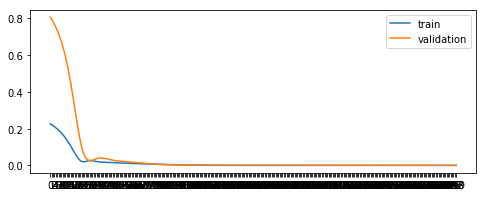

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
ax.plot(fitted.history['loss'], label='train')
if 'val_loss' in fitted.history.keys():
    ax.plot(fitted.history['val_loss'], label='validation')
ax.legend()
ax.set_xticks(np.arange(EPOCH_NUM))
fig.show()

In [23]:
train_Y_real = scalerY.inverse_transform(train_Y)
train_Y_hat = scalerY.inverse_transform(fitted.model.predict(train_X))

train_score = np.sqrt(mean_squared_error(train_Y_real, train_Y_hat))
print('Training Score: %.3f RMSE' % train_score)

Training Score: 0.354 RMSE


### Testing

In [24]:
test_Y_real = scalerY.inverse_transform(test_Y)
test_Y_hat = scalerY.inverse_transform(fitted.model.predict(test_X))

test_score = np.sqrt(mean_squared_error(test_Y_real, test_Y_hat))
print('Test Score: %.3f RMSE' % test_score)
print('Real\t:\n %s,\nPredict\t:\n %s' % (test_Y_real[-1][0], test_Y_hat[-1][0]))

Test Score: 0.332 RMSE
Real	:
 19.8,
Predict	:
 20.077


In [27]:
test_Y_real[-5:]

array([[ 19.        ],
       [ 19.20000076],
       [ 19.39999962],
       [ 19.60000038],
       [ 19.79999924]], dtype=float32)

In [28]:
test_Y_hat[-5:]

array([[ 19.34609985],
       [ 19.73358727],
       [ 19.99500084],
       [ 20.0727005 ],
       [ 20.07702065]], dtype=float32)

Done.